# Exercises

In [5]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

### Data preparation

To better organize the workflow and manage the numerous datasets in this notebook, we have created a loop that iterates through the datasets stored in the folder assigned to our group. It loads each dataset into a DataFrame object and stores them in a list of DataFrames. This allows us to iterate over the list if we want to perform operations on all 10 datasets, avoiding the need to read the datasets repeatedly.

In [6]:
# Create list to hold all DataFrames
dataframes = []

# Iterate over files in the directory
for f in os.listdir('./ProjectDatasets/Team_7'):
    if f.endswith('.csv'):  # Check if it's a CSV file
        df = pd.read_csv(os.path.join('./ProjectDatasets/Team_7', f))
        df['Company'] = os.path.splitext(f)[0]  # Add a Company column using the filename (without extension)
        # Ensure the 'Date' column is parsed as datetime
        df['Date'] = pd.to_datetime(df['Date'])
        dataframes.append(df)

In [7]:
for i, df in enumerate(dataframes):
    company_name = df['Company'].iloc[0]  # Get the company name (unique for each DataFrame)
    print(f"DataFrame {i + 1}: {company_name}")


DataFrame 1: SBUX
DataFrame 2: DPZ
DataFrame 3: MCD
DataFrame 4: LKNCY
DataFrame 5: QSR
DataFrame 6: WEN
DataFrame 7: PZZA
DataFrame 8: YUM
DataFrame 9: BRK-A
DataFrame 10: DNUT


We want to ensure that the order of the dataframes is the same every time we load the dataframes 

In [8]:
# Desired order of company names
desired_order = ['LKNCY', 'DPZ', 'QSR', 'WEN', 'YUM', 'MCD', 'BRK-A', 'PZZA', 'SBUX', 'DNUT']

# Create a mapping of company names to their respective dataframes
company_to_dataframe = {df['Company'].iloc[0]: df for df in dataframes}

# Reorder the dataframes list based on the desired order
dataframes = [company_to_dataframe[company] for company in desired_order if company in company_to_dataframe]

# Verify the new order
print("Reordered dataframes:")
for i, df in enumerate(dataframes):
    print(f"DataFrame {i + 1}: {df['Company'].iloc[0]}")


Reordered dataframes:
DataFrame 1: LKNCY
DataFrame 2: DPZ
DataFrame 3: QSR
DataFrame 4: WEN
DataFrame 5: YUM
DataFrame 6: MCD
DataFrame 7: BRK-A
DataFrame 8: PZZA
DataFrame 9: SBUX
DataFrame 10: DNUT


We define the columns that are numerical and relative to the stock price, so we can call this list when we need it to iterate through these columns to make transformations. In some cases que will only use some of the columns, for example we won't use "Volume". In that case we will use list slicing to access the elements we want.

In [9]:
num_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

#### Data Observation

First, we consider it necessary to visualize the raw data at this point to begin addressing it appropriately. To do this, we plot the variables 'Open', 'High', 'Low', 'Close', and 'Adj Close' in a combined line chart, allowing us to observe the evolution of these variables over time for each company. 

As for the "Volume" variable, it is visualized in a separate chart because it does not represent price information, has a different scale, and is much more variable. Therefore, visualizing it alongside the other numeric variables would not be feasible.


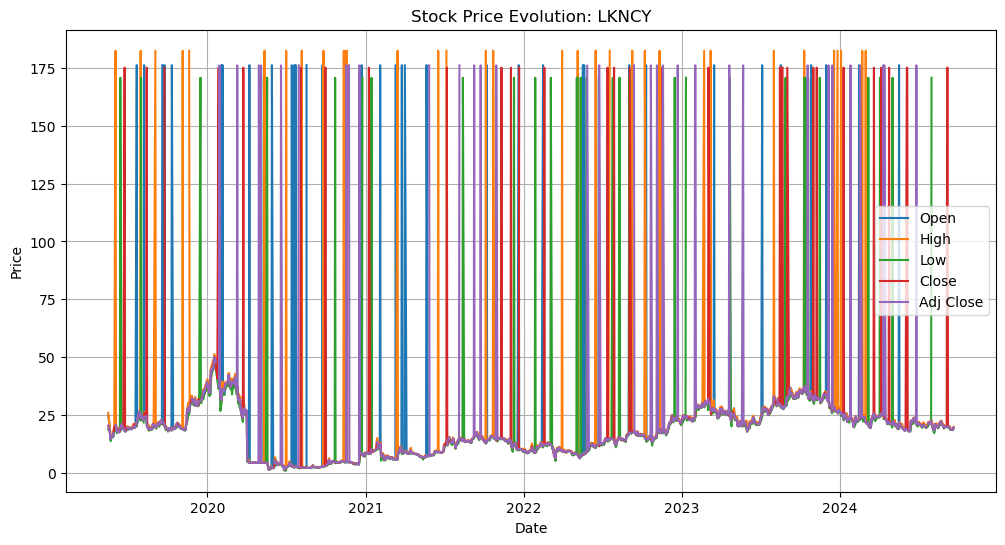

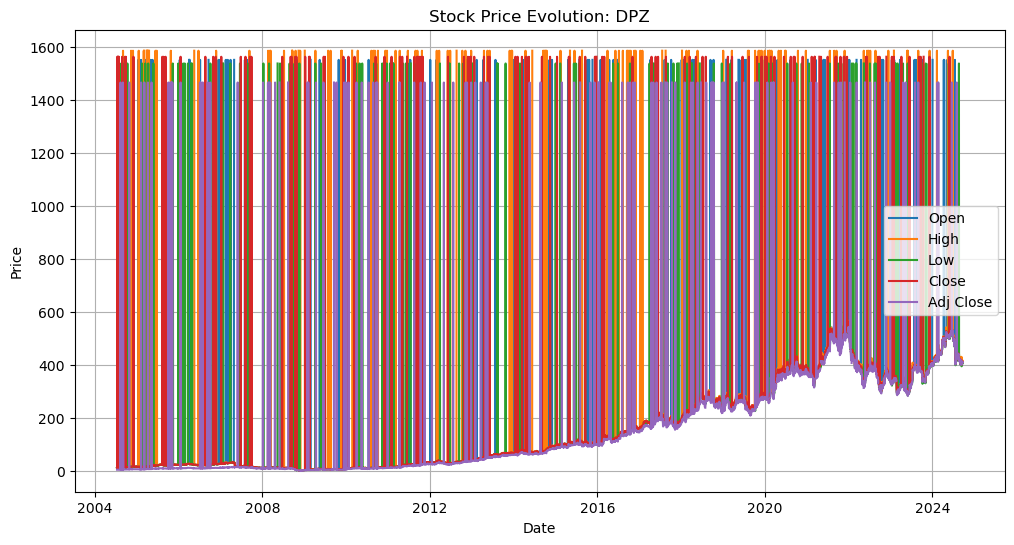

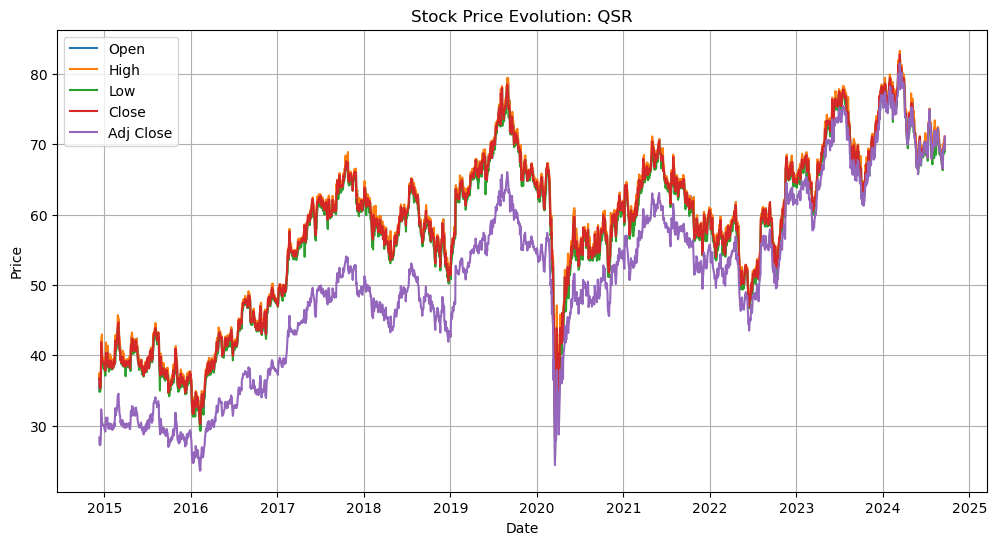

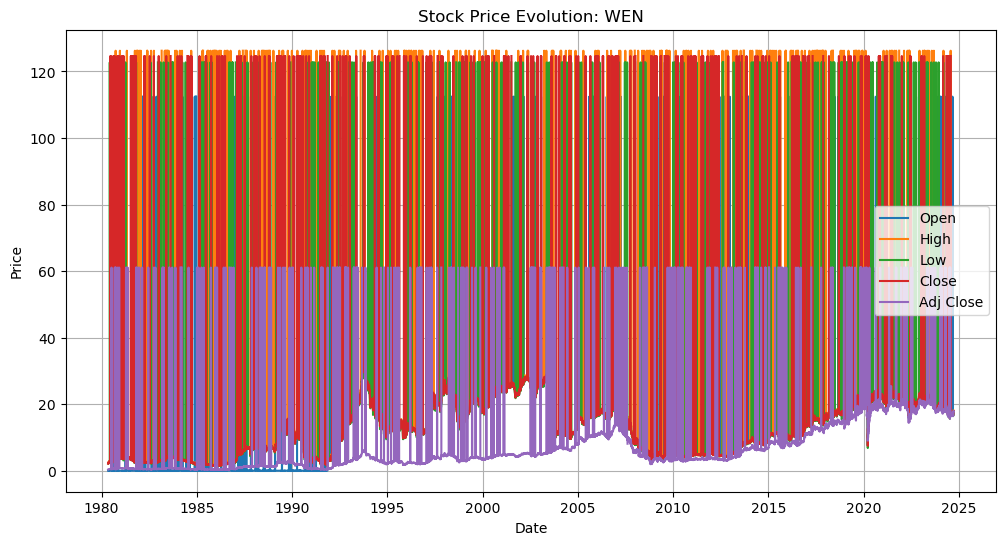

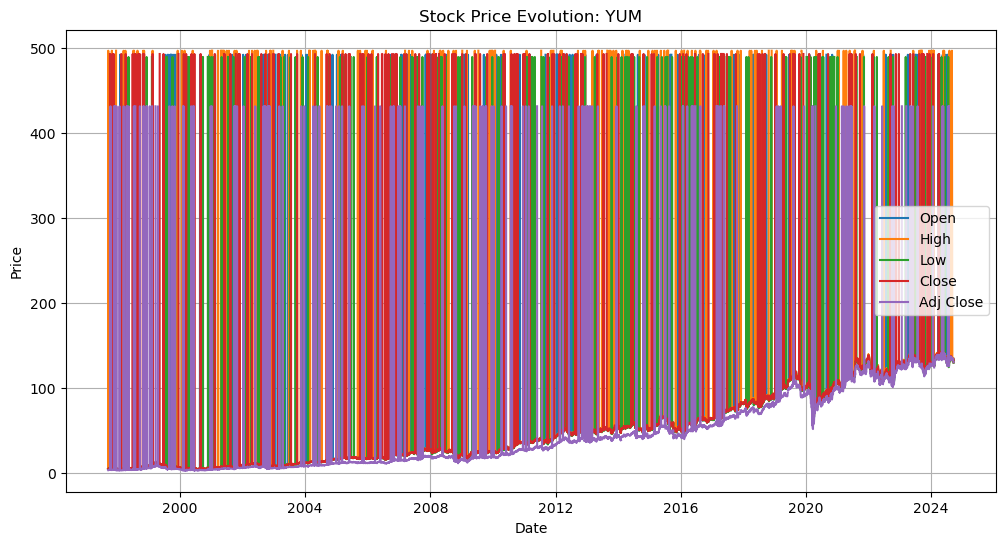

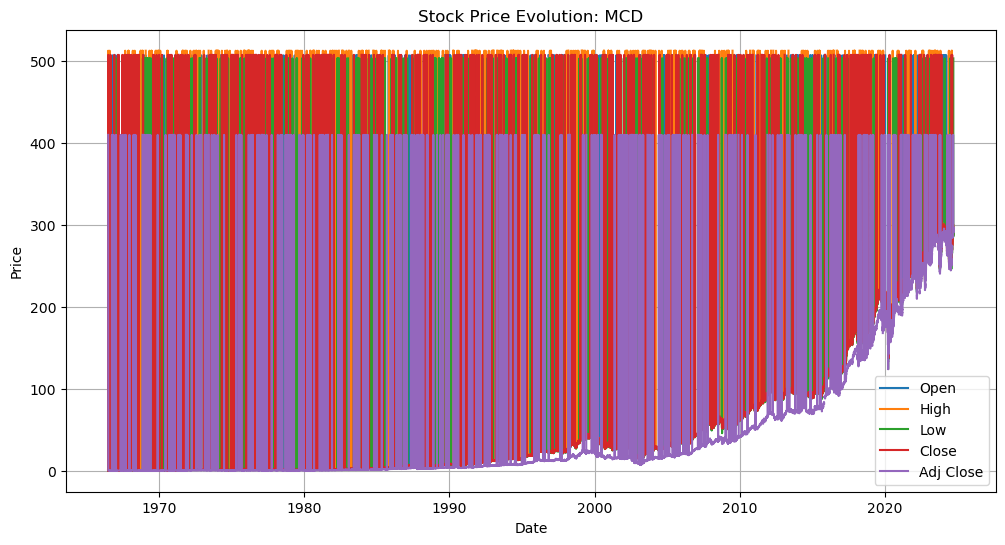

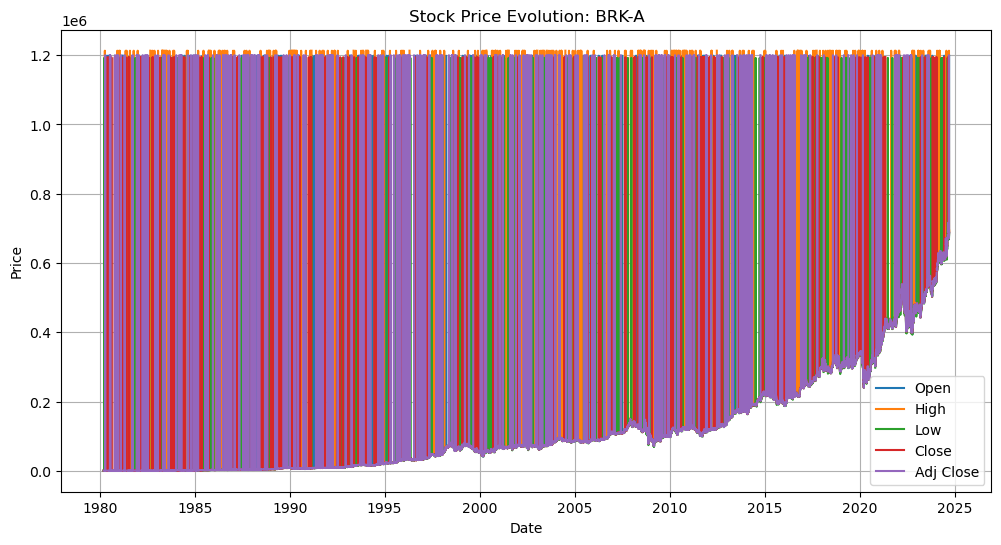

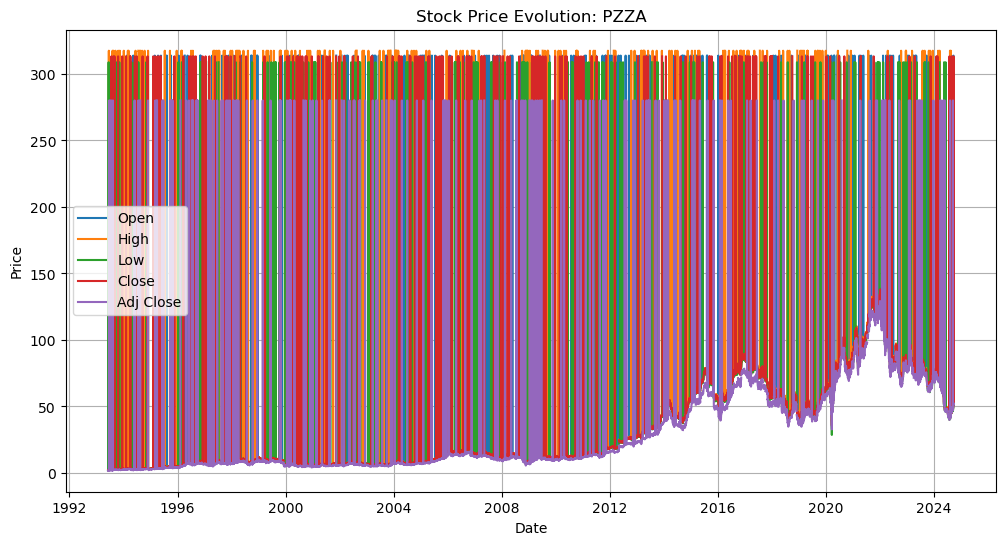

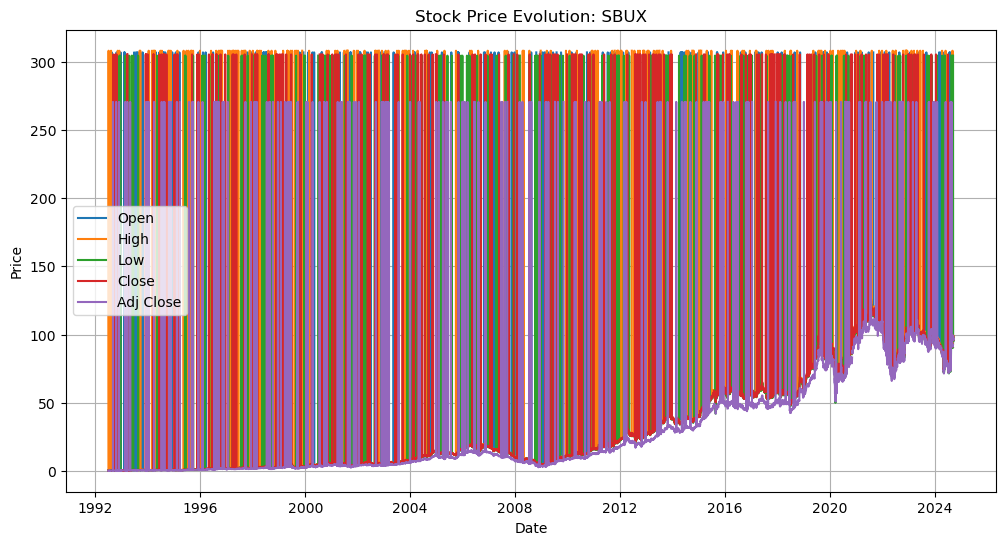

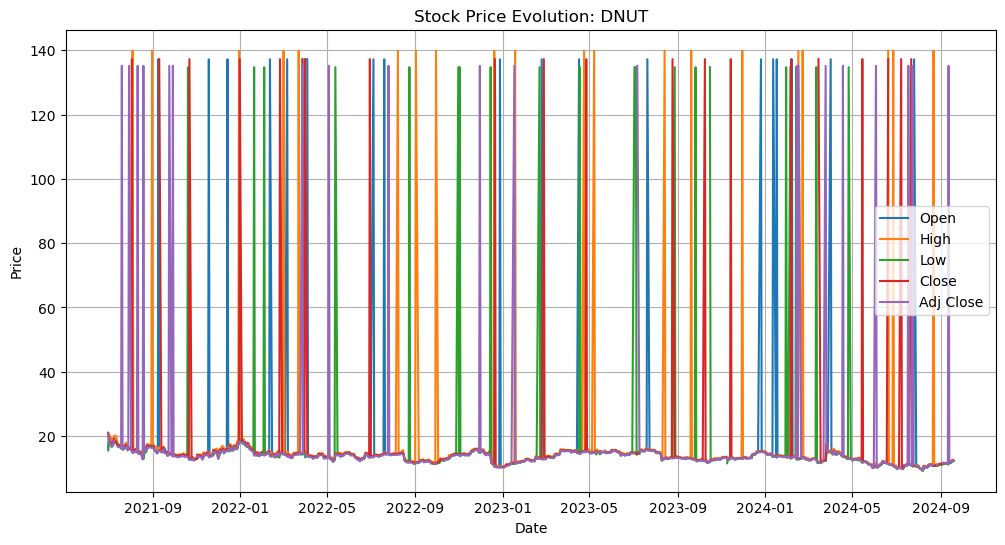

In [10]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    for variable in num_columns[:-1]:
        plt.plot(df["Date"], df[variable], label=variable)
    
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

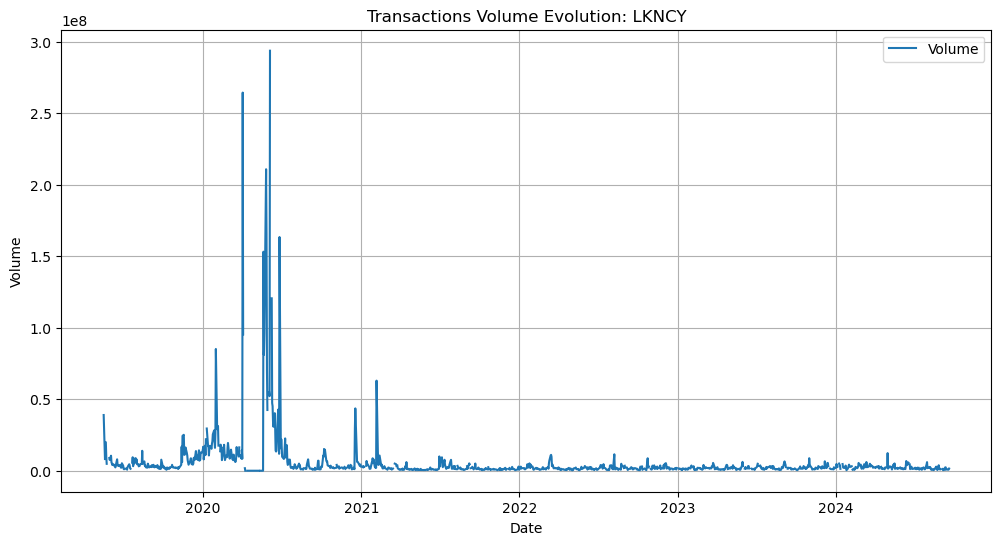

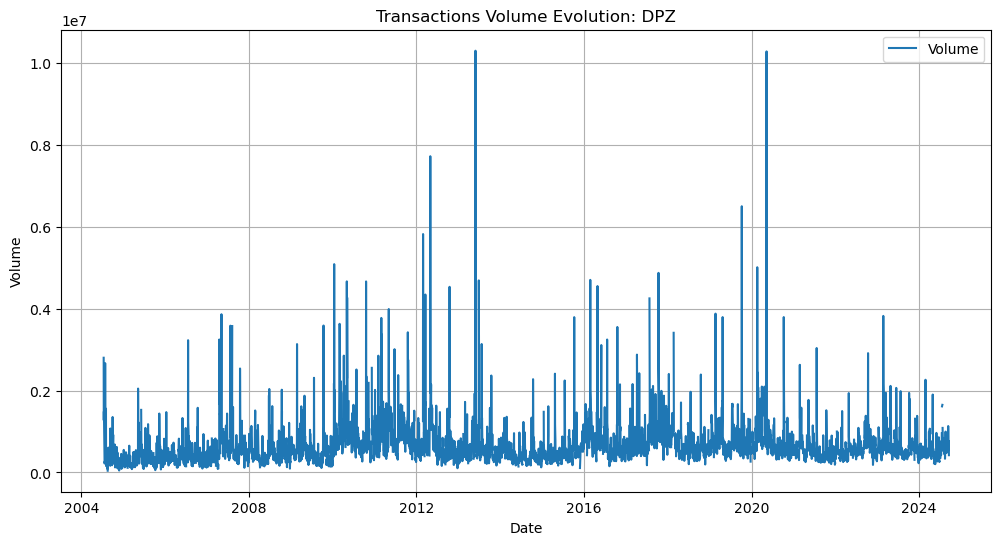

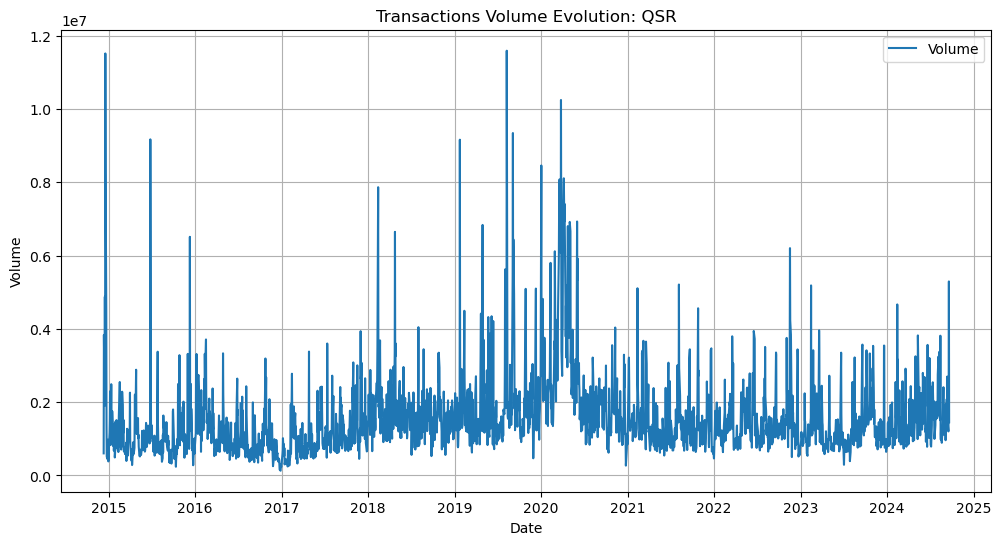

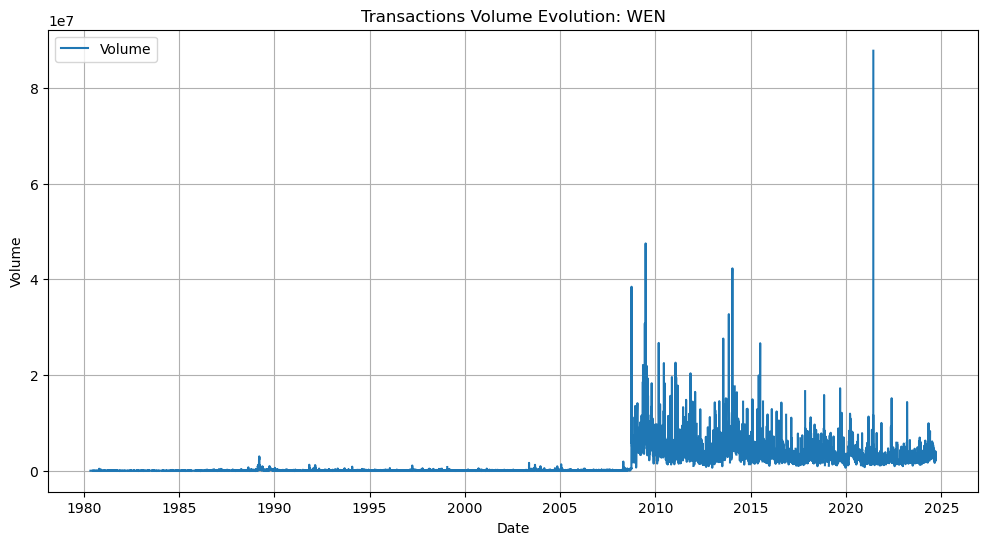

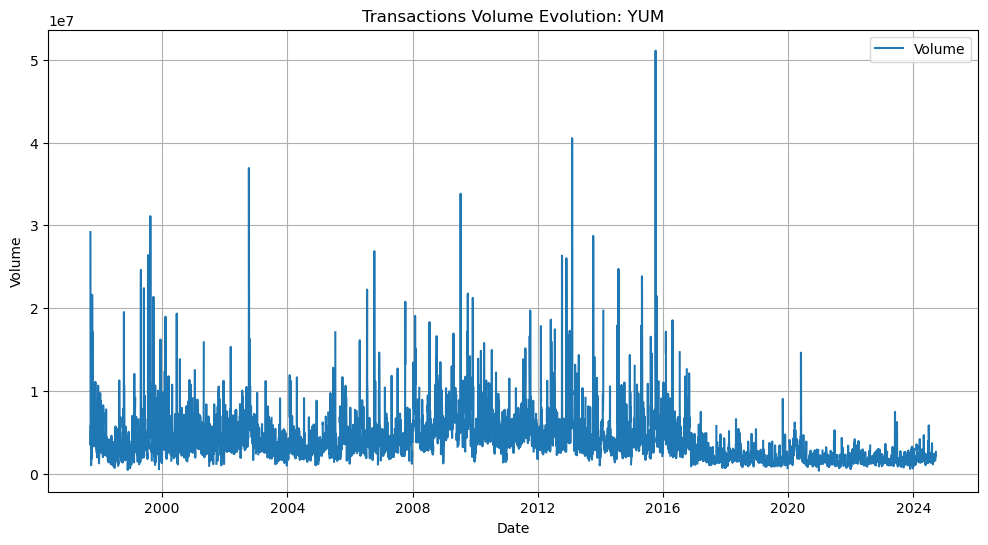

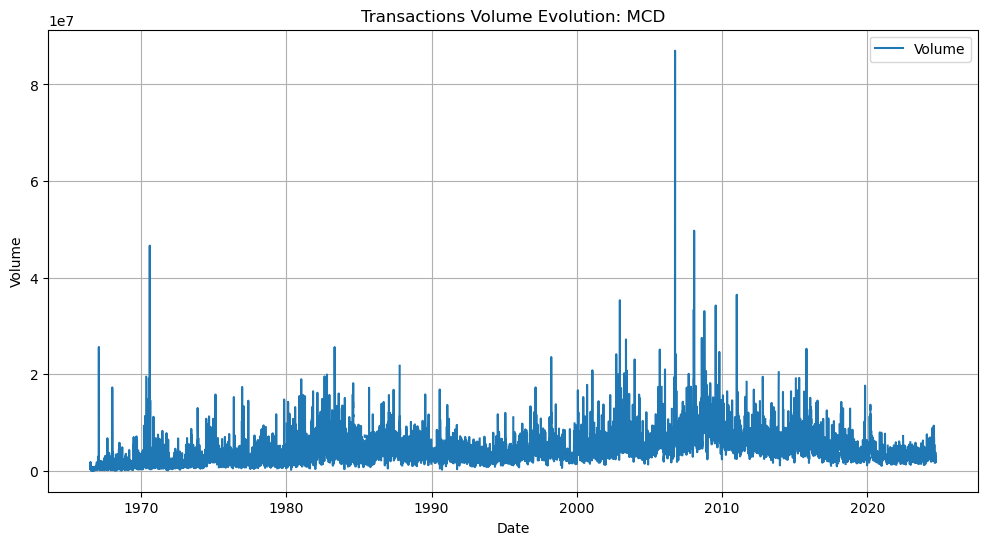

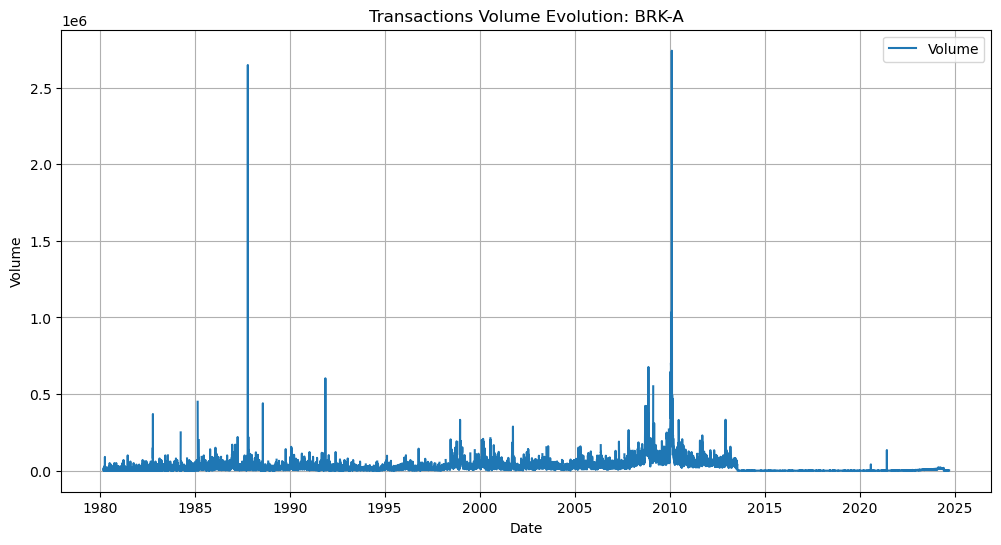

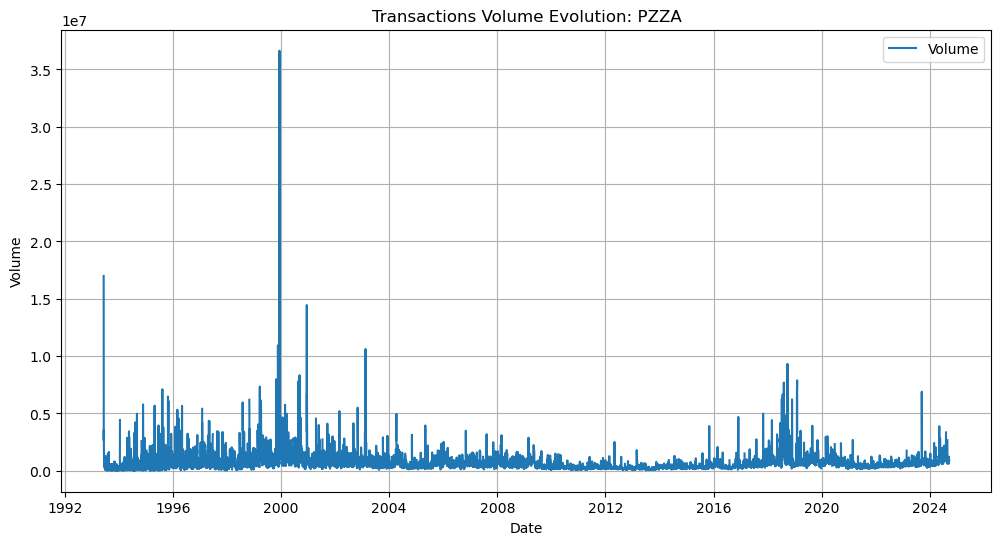

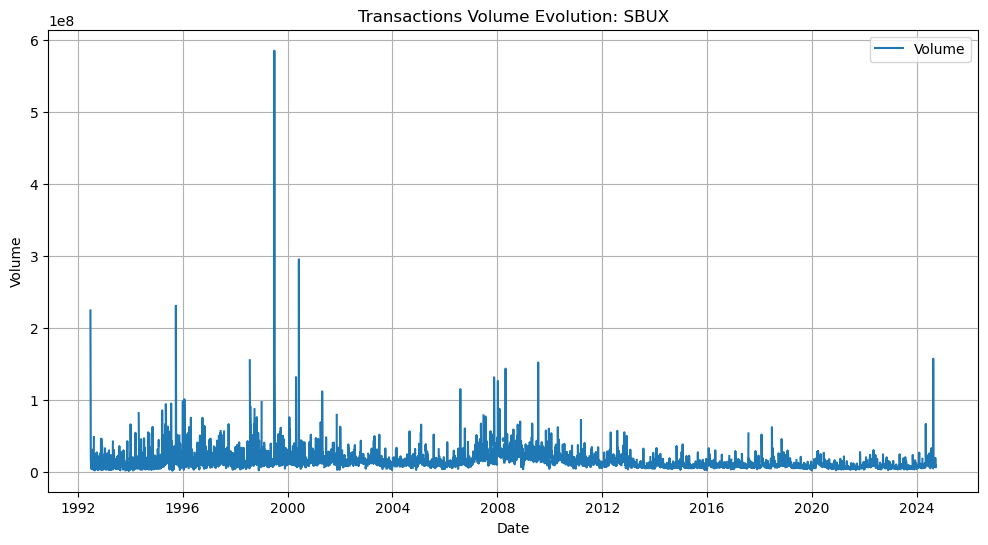

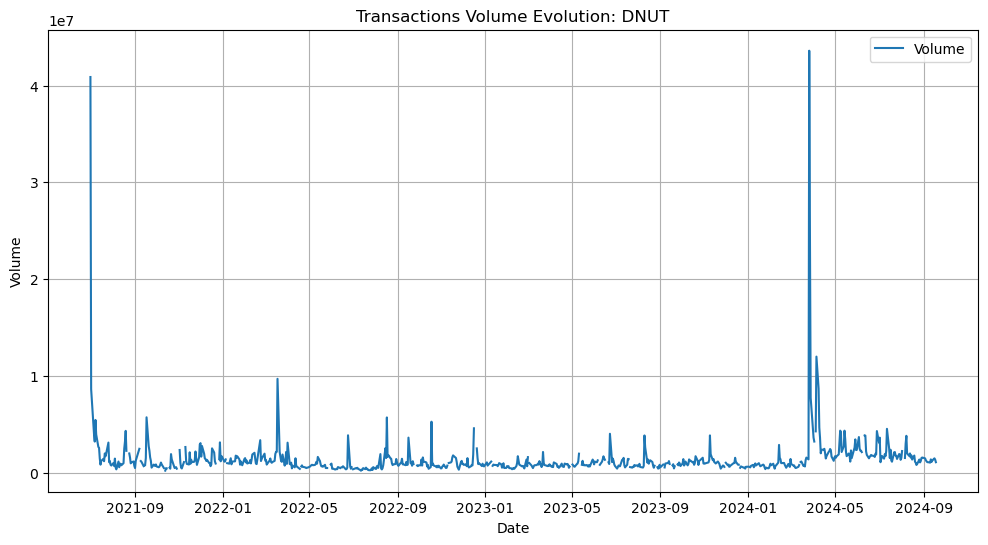

In [11]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Volume'], label='Volume')
        
    # Chart formatting
    plt.title(f"Transactions Volume Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

We can clearly observe how outliers in the datasets result in visualizations with completely vertical lines, caused by anomalous changes in price. We also notice certain peculiar details regarding changes in the scale of the "Volume" variable for specific companies, which we will address later.

#### Missing data

We created a summary table that displays the percentage of missing values (NaN) for each variable and company.

In [12]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date  Open  High   Low  Close  Adj Close  Volume
LKNCY      0.0   0.0  4.81  4.96  4.89   4.67       4.89    4.96
DPZ        0.0   0.0  4.83  4.87  4.89   4.87       4.91    4.99
QSR        0.0   0.0  0.00  0.00  0.00   0.00       0.00    0.00
WEN        0.0   0.0  4.89  4.83  4.86   4.91       4.88    4.99
YUM        0.0   0.0  4.90  4.87  4.88   4.94       4.87    5.01
MCD        0.0   0.0  4.90  4.88  4.89   4.81       4.89    5.00
BRK-A      0.0   0.0  4.89  4.85  4.93   4.87       4.85    5.00
PZZA       0.0   0.0  4.76  4.83  4.88   4.90       4.86    5.00
SBUX       0.0   0.0  4.85  4.84  4.88   4.95       4.88    5.00
DNUT       0.0   0.0  5.03  4.79  4.91   4.79       4.91    4.91

As we can observe, there are around 5% missing observations for each variable in each company, except for the company QSR, which has no missing data.

#### Manually manipulated data ranges

With the help of the visualizations above, we identified some manually manipulated ranges of data, where the scale for Volume variable was clearly changed applying what we think is probably a multiplier. Specifically, we detected this in the case of the company WEN, where the numbers shift abruptly from large values to very small ones, and the opposite situation with BRK-A, where the volume transitions suddenly from smaller values to much larger ones.

In the case of WEN, apart from the Volume, we think the Open Price variable was also manipulated setting to 0 the values for the first years.

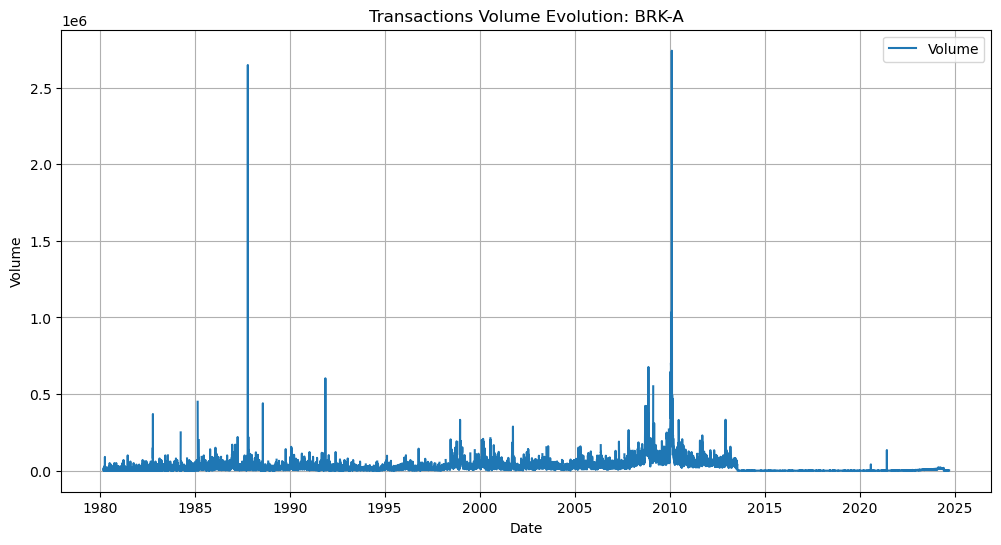

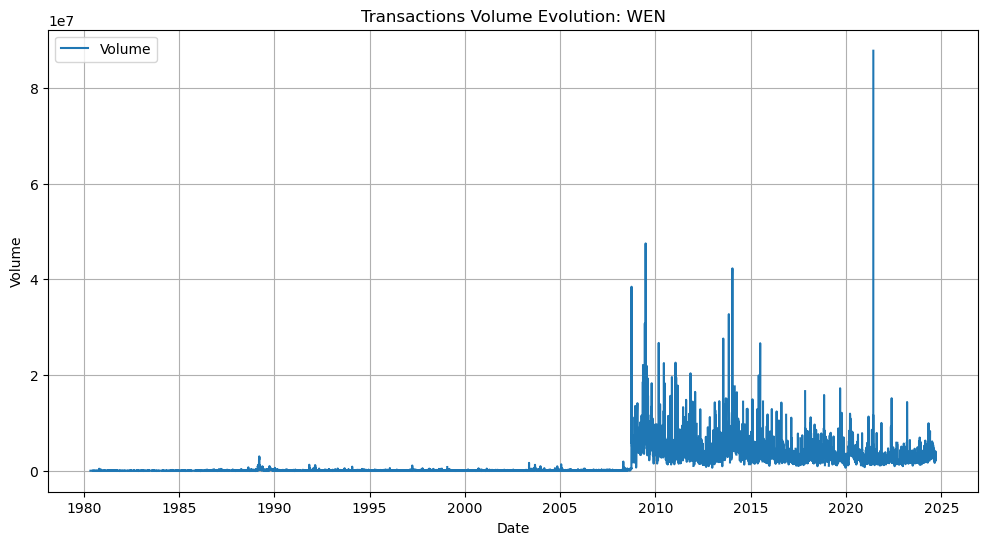

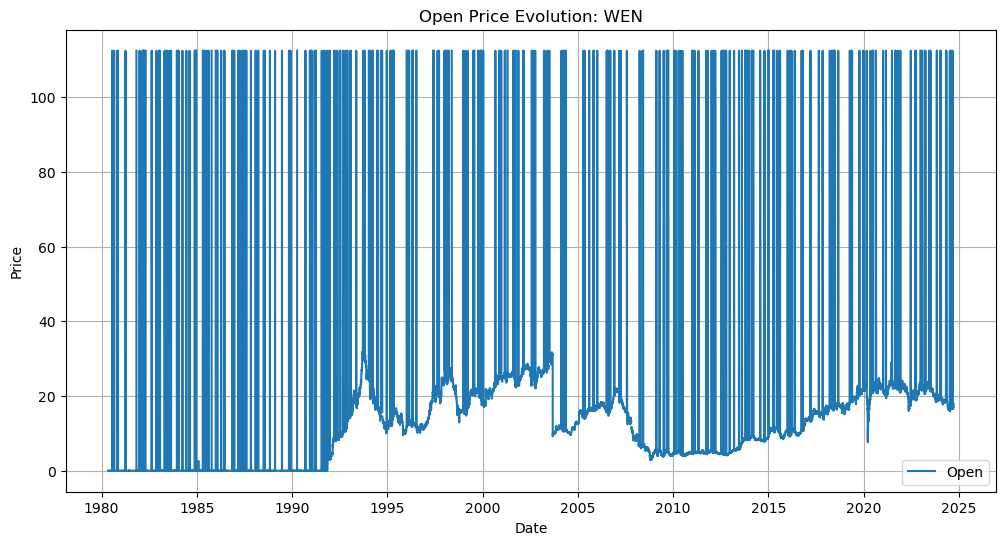

In [13]:
# Plot Volume for BRK-A
# Ensure the 'Date' column is parsed as datetime
dataframes[6]['Date'] = pd.to_datetime(dataframes[6]['Date'])

# Sort the data by date for proper plotting
dataframes[6].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[6]['Date'], dataframes[6]['Volume'], label='Volume')
    
# Chart formatting
plt.title(f"Transactions Volume Evolution: {dataframes[6]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Plot Volume for WEN
# Ensure the 'Date' column is parsed as datetime
dataframes[3]['Date'] = pd.to_datetime(dataframes[3]['Date'])

# Sort the data by date for proper plotting
dataframes[3].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[3]['Date'], dataframes[3]['Volume'], label='Volume')
    
# Chart formatting
plt.title(f"Transactions Volume Evolution: {dataframes[3]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Plot Open Price for WEN
# Ensure the 'Date' column is parsed as datetime
dataframes[3]['Date'] = pd.to_datetime(dataframes[3]['Date'])

# Sort the data by date for proper plotting
dataframes[3].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[3]['Date'], dataframes[3]['Open'], label='Open')


# Chart formatting
plt.title(f"Open Price Evolution: {dataframes[3]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

First, we handle the case of the scale change in the Volume variable for BRK-A. To do this, we focus on the time range where the abrupt change was identified, specifically from 2012 to 2013 inclusive. We then use rolling windows to calculate the relative change for each observation in the Volume variable with respect to the mean of the corresponding rolling window.

Once the row (its index) where the abrupt change occurs is identified, we calculate the ratio used to alter the scale. For this, we select the last 3 values with the old scale and the first 3 values with the "new" (incorrect) scale, and compute their means. Dividing these means gives us the ratio, which is then used to revert the modified values to their normal scale starting from the identified index. This adjustment is performed using a combination of the `apply()` function and a `lambda`.

As observed in the chart, the scale change has been successfully corrected.

In [14]:
window_size = 3
threshold = 0.80

change_range_df = dataframes[6][(dataframes[6]["Date"].dt.year > 2011) & (dataframes[6]["Date"].dt.year <= 2013)]

rolling_mean = change_range_df["Volume"].rolling(window=window_size, center=True).mean()


# rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')

relative_change = abs(change_range_df["Volume"] - rolling_mean) / rolling_mean
change_scaling_index = relative_change.sort_values(ascending=False).index[0]

# Calculate the proportion
former_scale = dataframes[6].loc[change_scaling_index-3:change_scaling_index-1]["Volume"].mean()
new_scale = dataframes[6].loc[change_scaling_index:change_scaling_index+2]["Volume"].mean()
proportion = former_scale / new_scale

# Apply the scaling to the "Volume" column from index 8416 onward
dataframes[6].loc[change_scaling_index:, "Volume"] = dataframes[6].loc[change_scaling_index:, "Volume"].apply(lambda x: x * proportion)


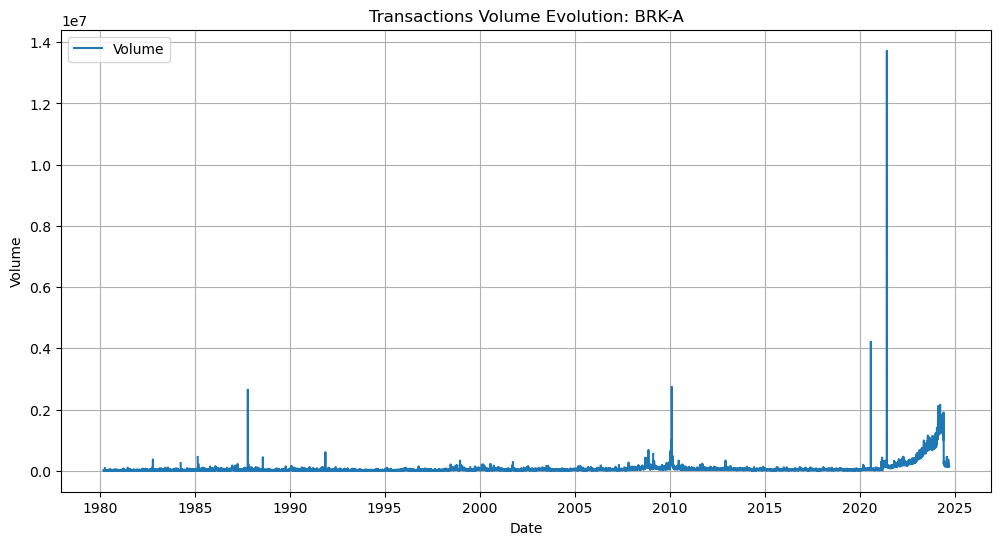

In [15]:
# Ensure the 'Date' column is parsed as datetime
dataframes[6]['Date'] = pd.to_datetime(dataframes[6]['Date'])

# Sort the data by date for proper plotting
dataframes[6].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[6]['Date'], dataframes[6]['Volume'], label='Volume')
    
# Chart formatting
plt.title(f"Transactions Volume Evolution: {dataframes[6]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In the case of the WEN scale change, we follow the same logic but focus on the range from 2007 to 2010, inclusive. The result can be observed in the new chart.

In [16]:
window_size = 3
threshold = 0.80

change_range_df = dataframes[3][(dataframes[3]["Date"].dt.year >= 2007) & (dataframes[3]["Date"].dt.year <= 2010)]

rolling_mean = change_range_df["Volume"].rolling(window=window_size, center=True).mean()


# rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')

relative_change = abs(change_range_df["Volume"] - rolling_mean) / rolling_mean
change_scaling_index = relative_change.sort_values(ascending=False).index[0]

# Calculate the proportion
former_scale = dataframes[3].loc[change_scaling_index-3:change_scaling_index-1]["Volume"].mean()
new_scale = dataframes[3].loc[change_scaling_index:change_scaling_index+2]["Volume"].mean()
proportion = former_scale / new_scale

# Apply the scaling to the "Volume" column from index 8416 onward
dataframes[3].loc[change_scaling_index:, "Volume"] = dataframes[3].loc[change_scaling_index:, "Volume"].apply(lambda x: x * proportion)


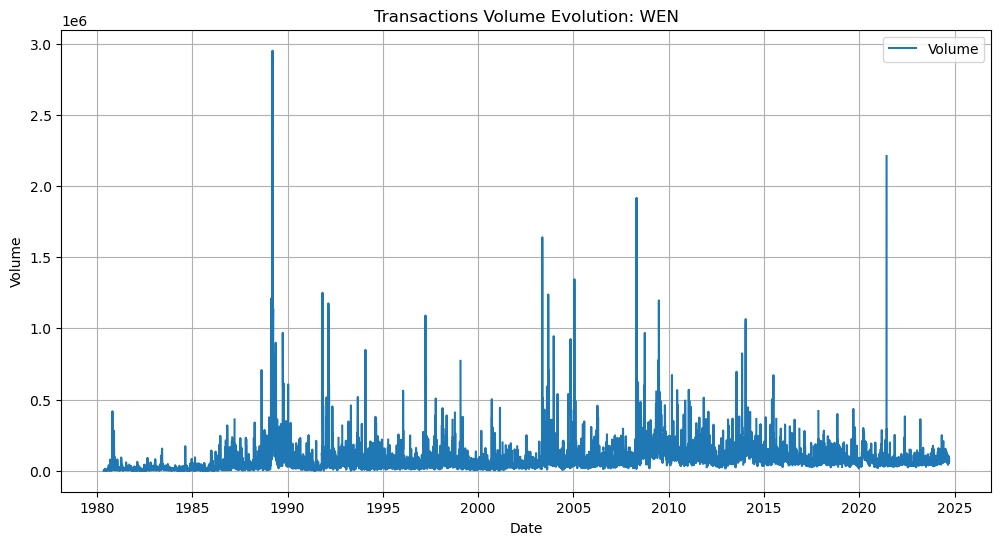

In [17]:
# Ensure the 'Date' column is parsed as datetime
dataframes[3]['Date'] = pd.to_datetime(dataframes[3]['Date'])

# Sort the data by date for proper plotting
dataframes[3].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[3]['Date'], dataframes[3]['Volume'], label='Volume')
    
# Chart formatting
plt.title(f"Transactions Volume Evolution: {dataframes[3]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

To handle the missing data in the "Open" variable during the early years of trading for WEN, we decided to assign the value of the "Close" variable to the range of missing "Open" values. This approach provides a closer approximation to reality compared to leaving the values as 0. 

To implement this, we identify the index where the zeros end and replace all zeros in the "Open" variable up to that index with the corresponding values from "Close."

In [18]:
# Get the index up to where the column ‘Open’ has a value of 0.
zero_indices = dataframes[3][dataframes[3]['Open'] == 0].index

# If indices are found, modify the ‘Open’ column.
if not zero_indices.empty:
    max_index = zero_indices[-1]
    dataframes[3].loc[:max_index, 'Open'] = dataframes[3].loc[:max_index, 'Close']


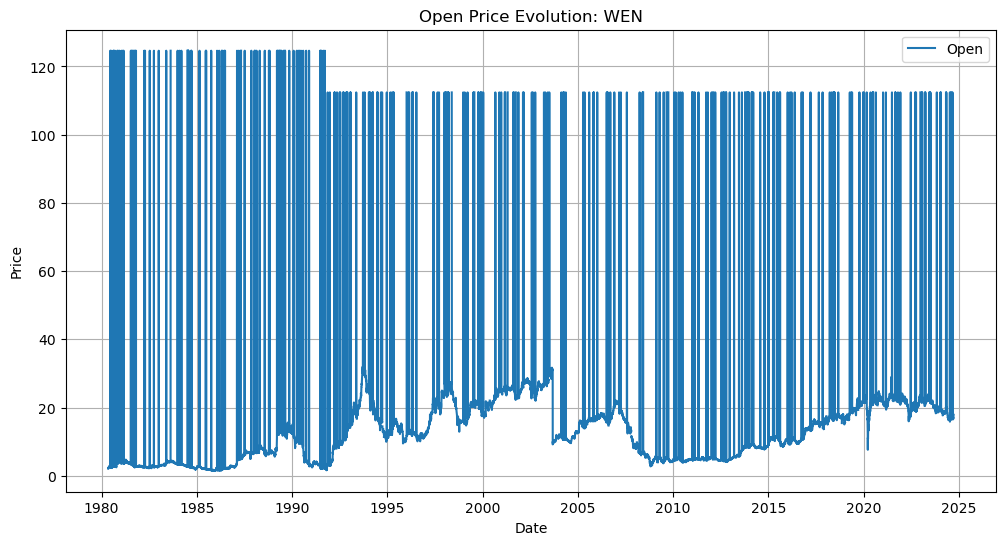

In [19]:
# Plot Open Price for WEN
# Ensure the 'Date' column is parsed as datetime
dataframes[3]['Date'] = pd.to_datetime(dataframes[3]['Date'])

# Sort the data by date for proper plotting
dataframes[3].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[3]['Date'], dataframes[3]['Open'], label='Open')


# Chart formatting
plt.title(f"Open Price Evolution: {dataframes[3]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Outliers

As we have seen, there are clear outliers in our datasets. To manage them, first, we need to visualize them and se how they are distributed. To do this, we use boxplots for each variable and each company.

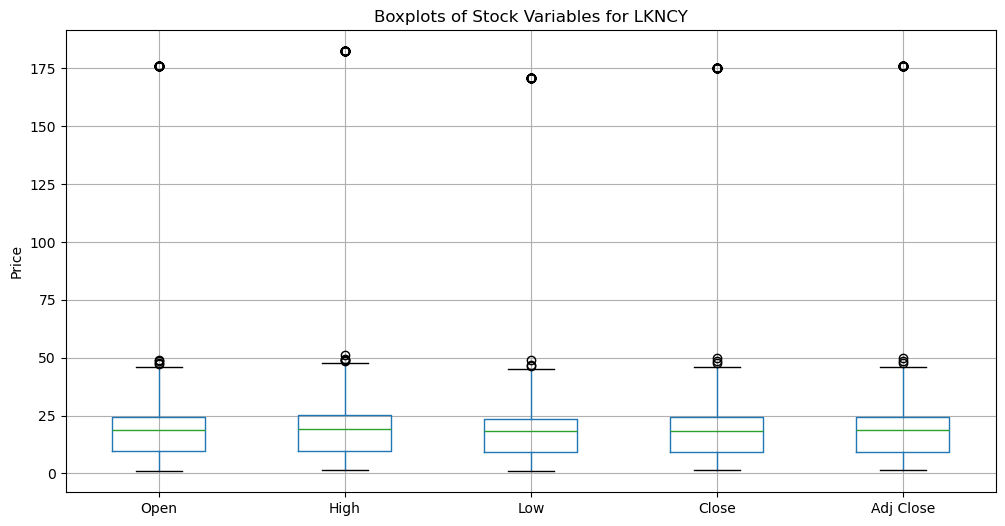

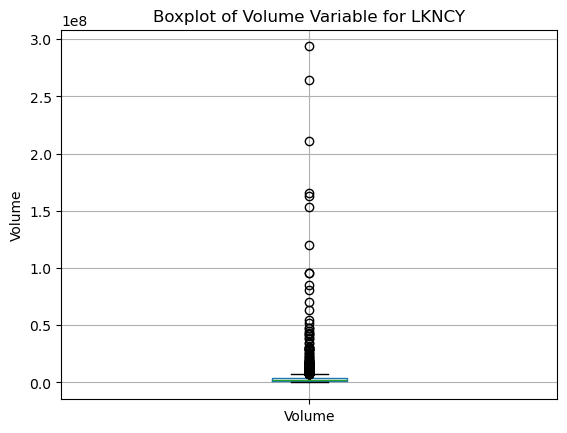

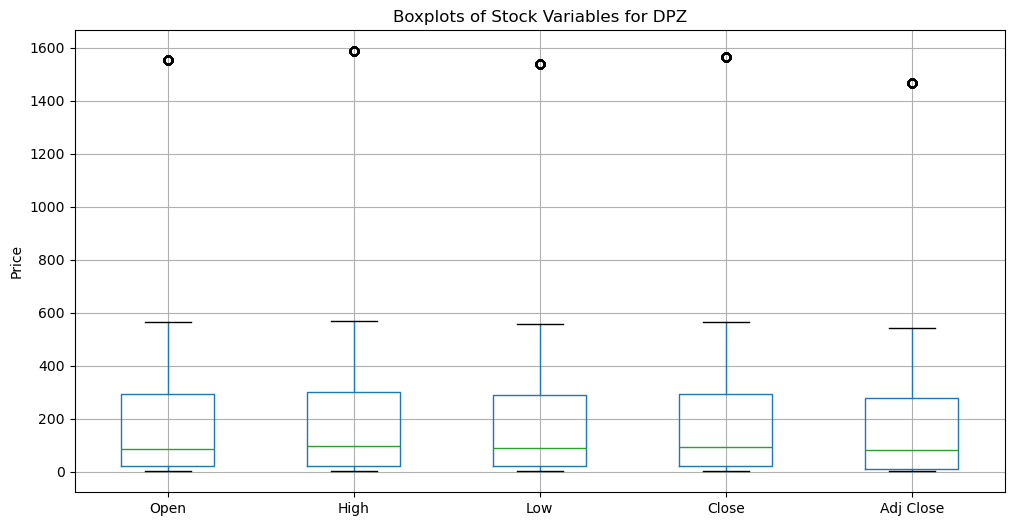

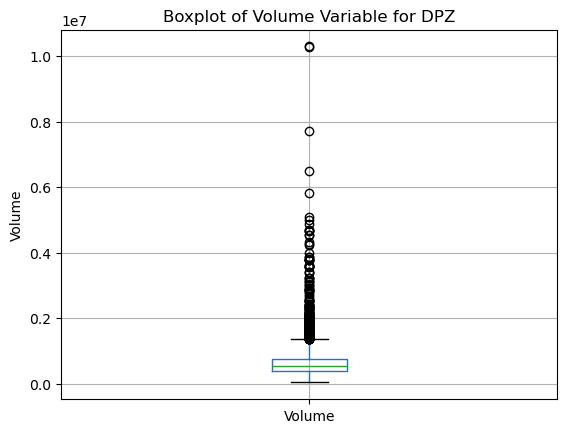

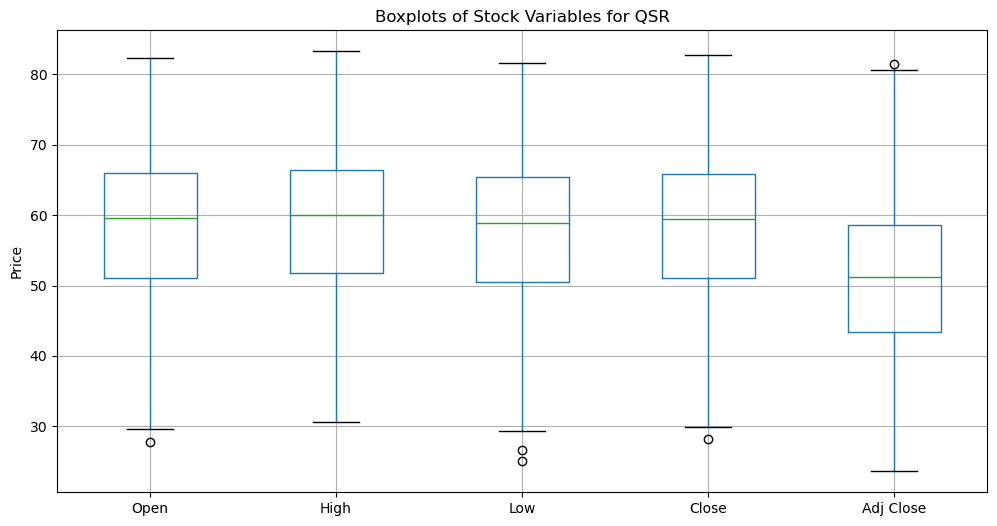

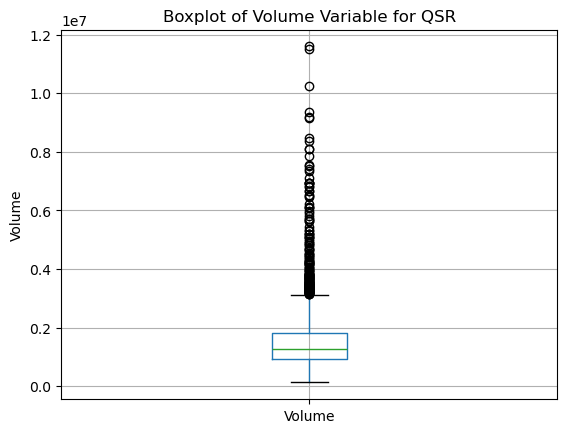

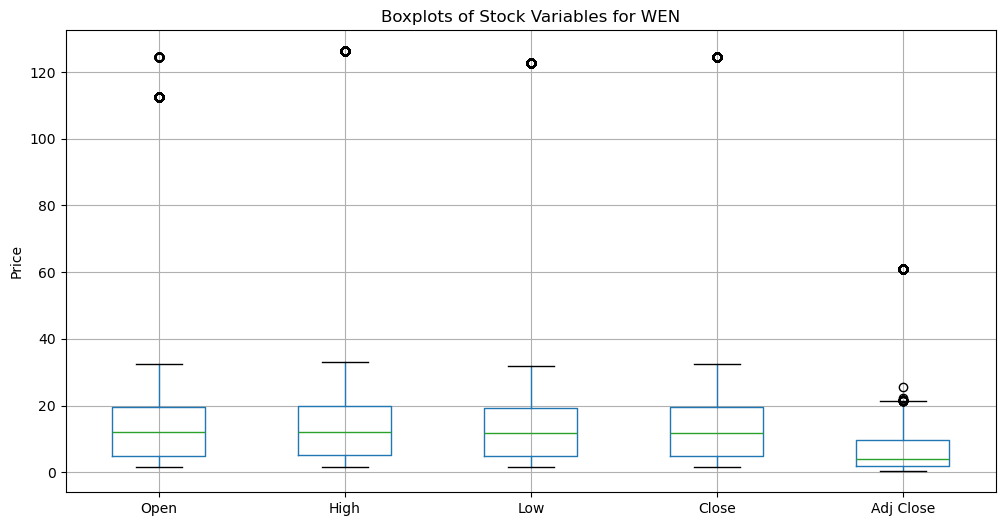

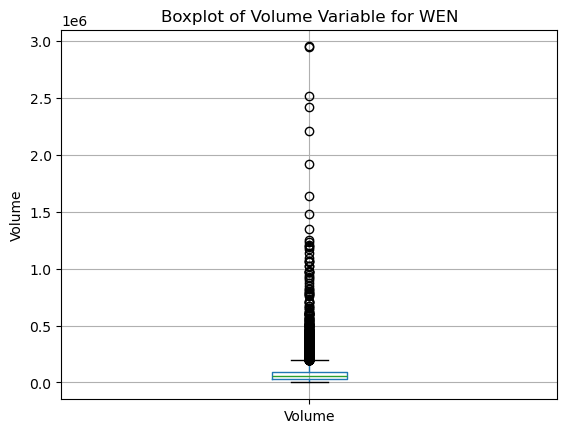

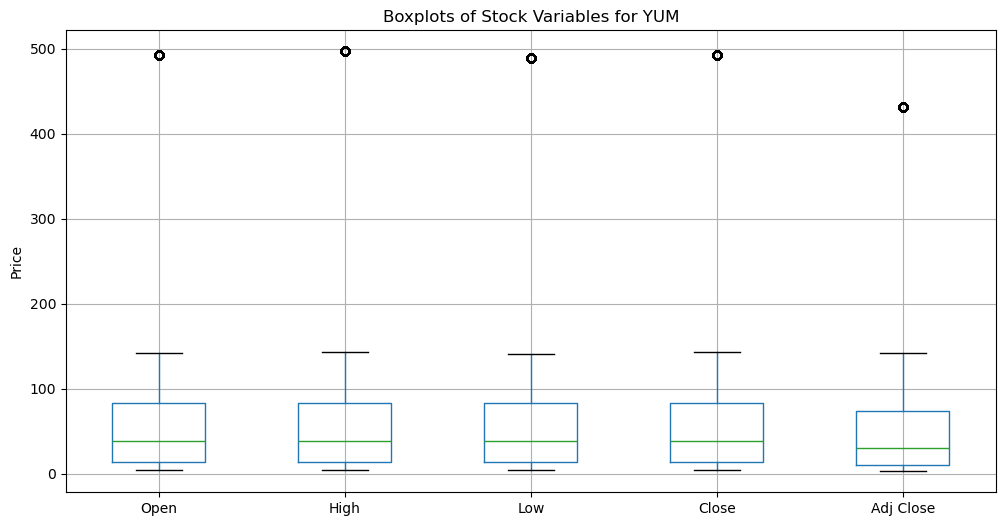

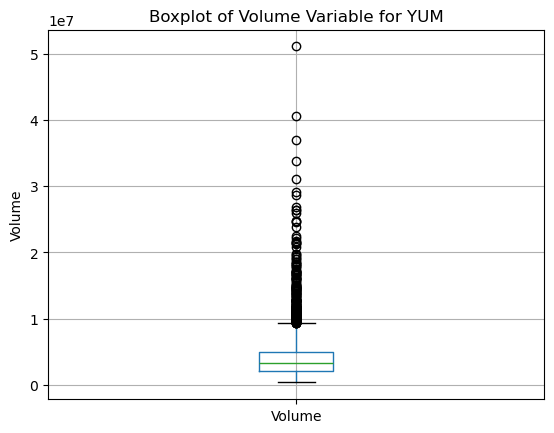

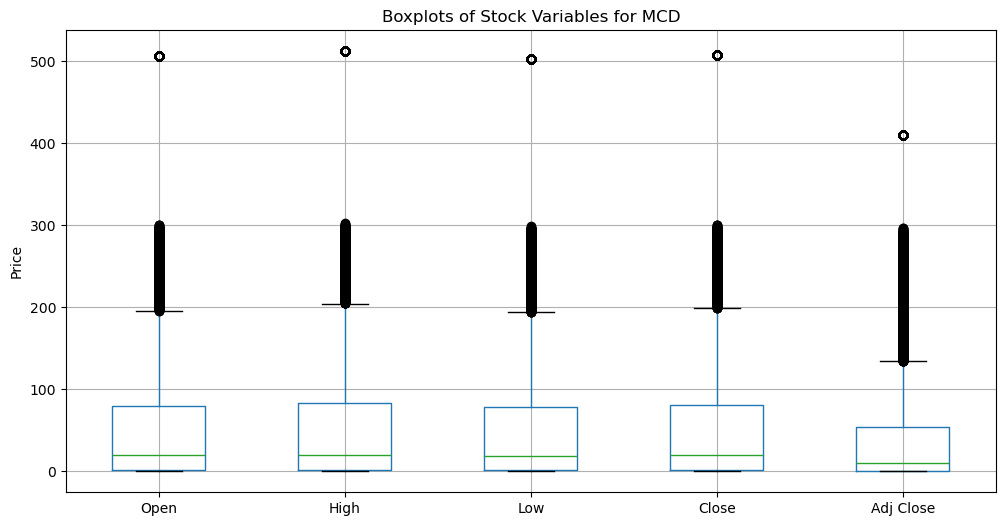

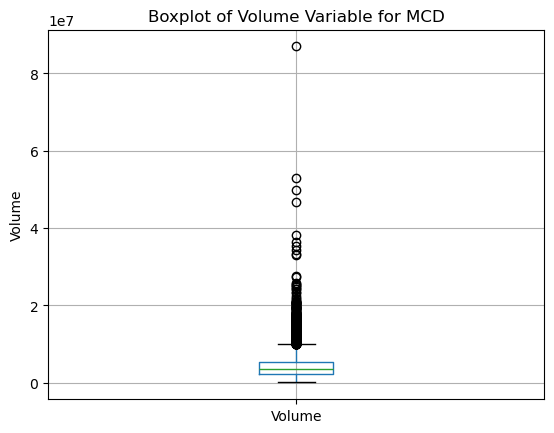

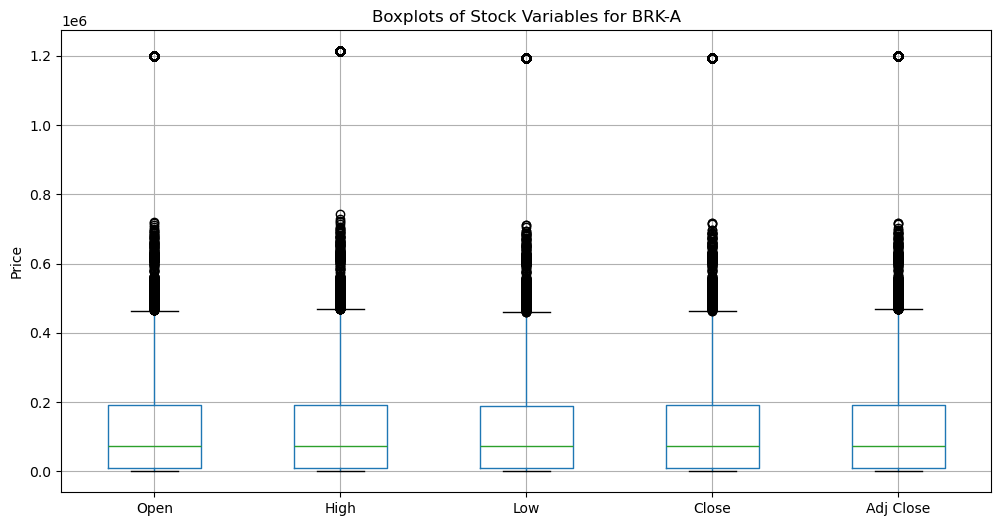

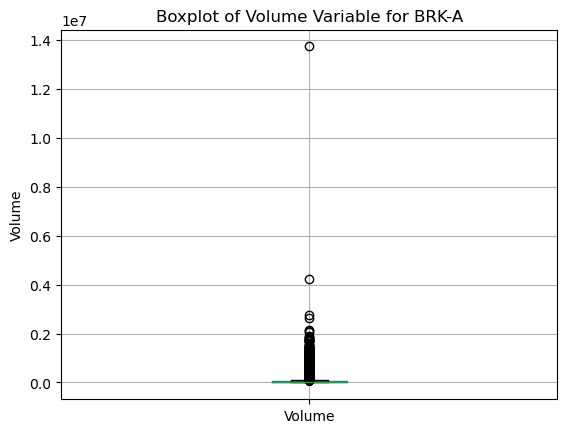

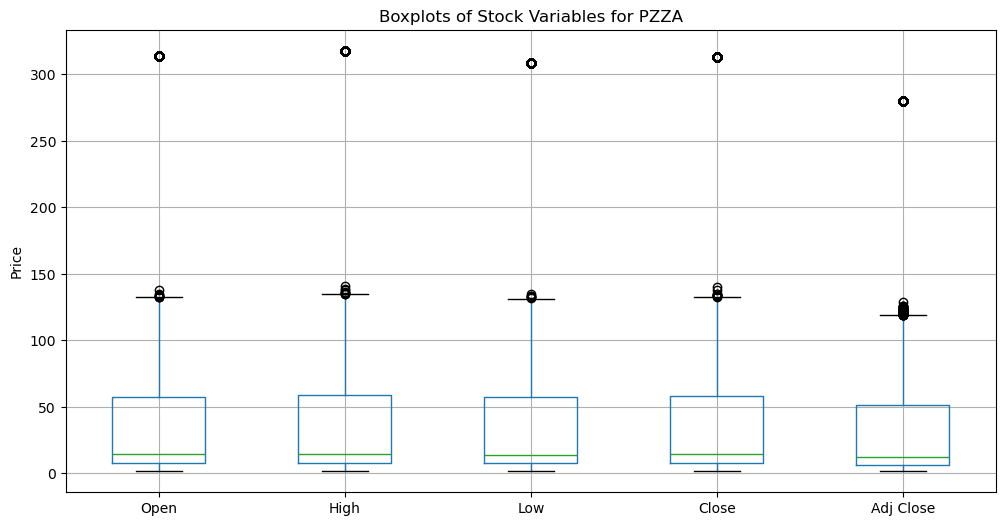

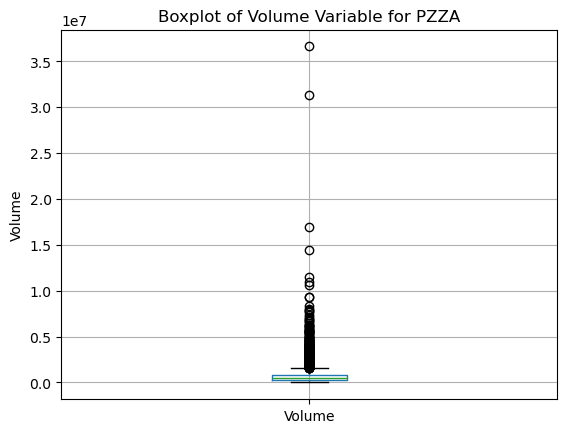

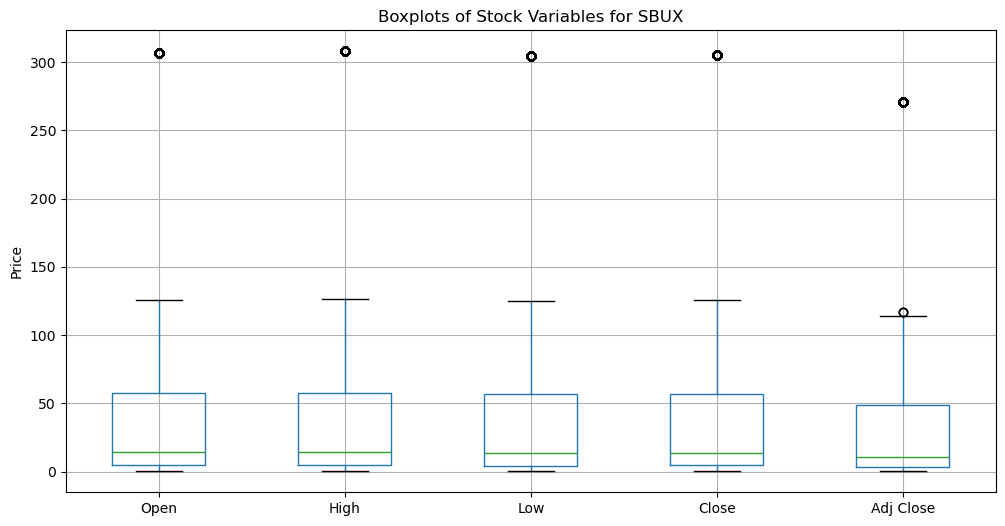

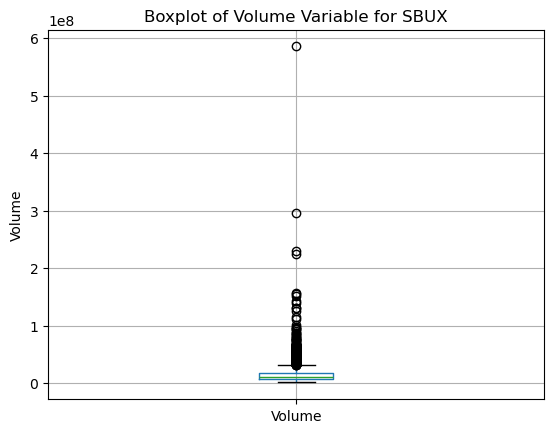

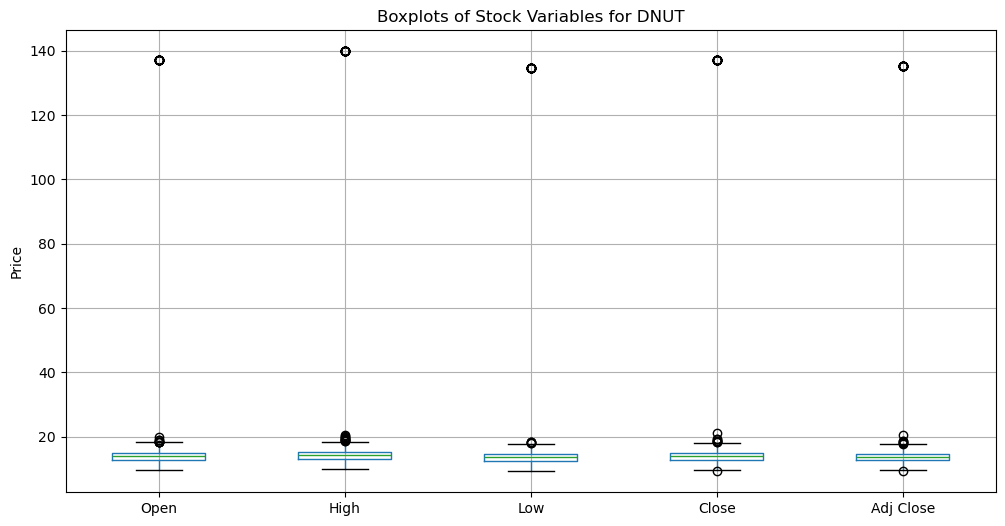

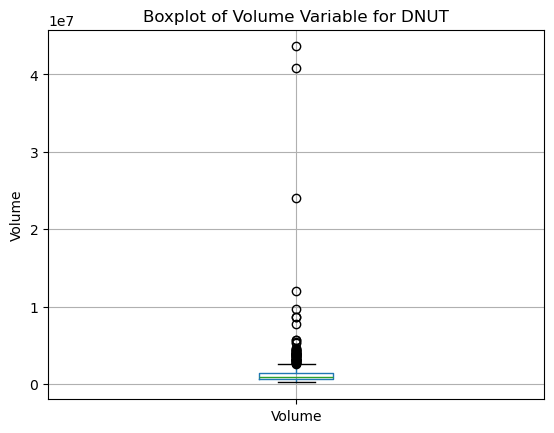

In [20]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Volume')
    plt.grid(True, axis='y')
    plt.show()

It can be observed that all datasets, except for the one from the company QSR, exhibit significant outliers. For the other nine companies, these outliers are located above the 75th percentile, falling into specific ranges considerably higher than this threshold.

To detect outliers and replace them with missing values, given the context of financial time series, we have opted for an approach utilizing sliding windows. The use of sliding windows in financial time series allows us to capture local trends and adapt to dynamic changes in the data, such as seasonal variations or periods of high volatility. This is achieved by using a sliding window (`rolling window`) to calculate the **local median** of each numeric column and comparing the current values to this central trend.

The criterion for identifying an outlier is based on the **relative change**, which measures how much a value deviates from the median relative to its magnitude. If the relative change exceeds a predefined threshold, the value is considered an outlier.

Process Steps
1. **Calculate the sliding median (`rolling_median`)**:
   - A sliding window of size `window_size` is used to calculate the median at each point in the time series.
   - The median is chosen instead of the mean because it is more robust to extreme values (outliers), preventing these values from affecting the central reference.

2. **Fill NaN values at the edges**:
   - Sliding windows produce `NaN` values at the edges of the series, so these are filled using forward (`bfill`) and backward (`ffill`) interpolations to maintain continuity.

3. **Calculate the relative change**:
   - The relative change is defined as:
     $$
     \text{Relative Change} = \frac{|x_t - \text{rolling\_median}|}{\text{rolling\_median}}
     $$
   - This value measures how far a point is from the local central trend.

4. **Identify outliers**:
   - A value is considered an outlier if its relative change exceeds a predefined threshold (`threshold`, e.g., 0.25 or 25%, making the detection highly sensitive).

5. **Replace outliers with `NaN`**:
   - Values identified as outliers are replaced with `NaN` in the DataFrame to prevent them from impacting future analyses.

We used higher `window_size` and `threshold` to manage outliers on the Volume variable, as the scale is different, and we want to be less sensitive.

We print the count of null values for each company and variable before and after the detection and replacing of outliers by NaN. As expected, the count of null value increases.

In [21]:
window_size = 10
threshold = 0.25

for df in dataframes:
    print(df["Company"][0])
    print(f"Rows in {df["Company"][0]}: {df.shape[0]}")
    print(df.isnull().sum())

    for column in num_columns[:-1]:

        rolling_median = df[column].rolling(window=window_size, center=True).median()
        rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')

        relative_change = abs(df[column] - rolling_median) / rolling_median

        outliers = relative_change > threshold
        print(f"Outliers detected in {column}: {outliers.sum()}")

        df.loc[outliers, column] = np.nan

    print(df.isnull().sum())
    print("******************************************************************************")

LKNCY
Rows in LKNCY: 1350
Date          0
Open         65
High         67
Low          66
Close        63
Adj Close    66
Volume       67
Company       0
dtype: int64
Outliers detected in Open: 71
Outliers detected in High: 79
Outliers detected in Low: 65
Outliers detected in Close: 77
Outliers detected in Adj Close: 74
Date           0
Open         136
High         146
Low          131
Close        140
Adj Close    140
Volume        67
Company        0
dtype: int64
******************************************************************************
DPZ
Rows in DPZ: 5088
Date           0
Open         246
High         248
Low          249
Close        248
Adj Close    250
Volume       254
Company        0
dtype: int64
Outliers detected in Open: 146
Outliers detected in High: 134
Outliers detected in Low: 140
Outliers detected in Close: 130
Outliers detected in Adj Close: 137
Date           0
Open         392
High         382
Low          389
Close        378
Adj Close    387
Volume       254


/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna 

Outliers detected in High: 281
Outliers detected in Low: 285
Outliers detected in Close: 281
Outliers detected in Adj Close: 281
Date           0
Open         830
High         826
Low          838
Close        828
Adj Close    826
Volume       561
Company        0
dtype: int64
******************************************************************************
PZZA
Rows in PZZA: 7883
Date           0
Open         375
High         381
Low          385
Close        386
Adj Close    383
Volume       394
Company        0
dtype: int64
Outliers detected in Open: 205
Outliers detected in High: 212
Outliers detected in Low: 201
Outliers detected in Close: 218
Outliers detected in Adj Close: 207
Date           0
Open         580
High         593
Low          586
Close        604
Adj Close    590
Volume       394
Company        0
dtype: int64
******************************************************************************
SBUX
Rows in SBUX: 8122
Date           0
Open         394
High         393
Low    

/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/3816146069.py:12: FutureWarning: Series.fillna 

In [22]:
window_size = 30
threshold = 1

for df in dataframes:
    print(df["Company"][0])
    print(f"Rows in {df["Company"][0]}: {df.shape[0]}")
    print(df.isnull().sum())

    rolling_median = df["Volume"].rolling(window=window_size, center=True).median()
    rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')

    relative_change = abs(df["Volume"] - rolling_median) / rolling_median

    outliers = relative_change > threshold
    print(f"Outliers detected in {"Volume"}: {outliers.sum()}")

    df.loc[outliers, "Volume"] = np.nan

    print(df.isnull().sum())
    print("******************************************************************************")


/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')


LKNCY
Rows in LKNCY: 1350
Date           0
Open         136
High         146
Low          131
Close        140
Adj Close    140
Volume        67
Company        0
dtype: int64
Outliers detected in Volume: 143
Date           0
Open         136
High         146
Low          131
Close        140
Adj Close    140
Volume       210
Company        0
dtype: int64
******************************************************************************
DPZ
Rows in DPZ: 5088
Date           0
Open         392
High         382
Low          389
Close        378
Adj Close    387
Volume       254
Company        0
dtype: int64
Outliers detected in Volume: 425
Date           0
Open         392
High         382
Low          389
Close        378
Adj Close    387
Volume       679
Company        0
dtype: int64
******************************************************************************
QSR
Rows in QSR: 2459
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Compa

/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/1254363800.py:10: FutureWarning: Series.fillna 

We can now check again the outliers present in the boxplots. We can observe how there considerably less outliers.

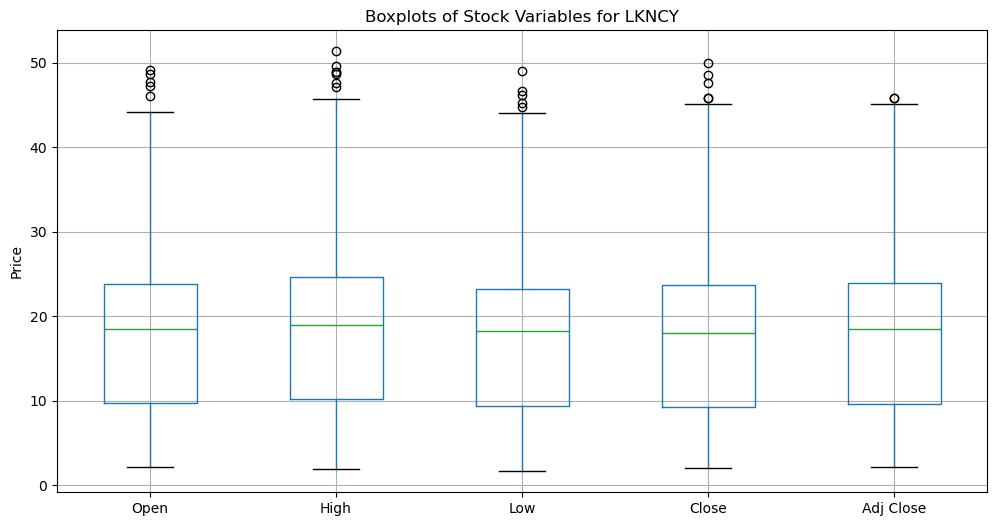

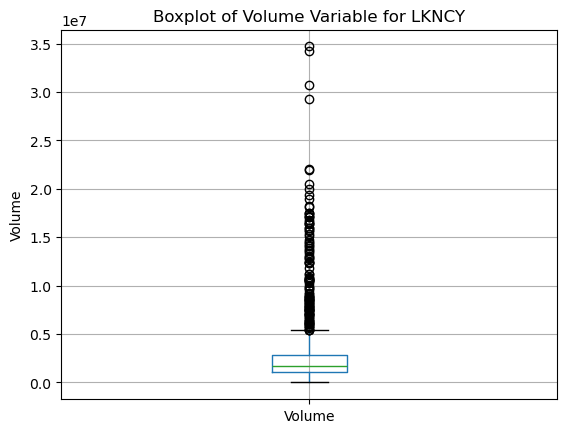

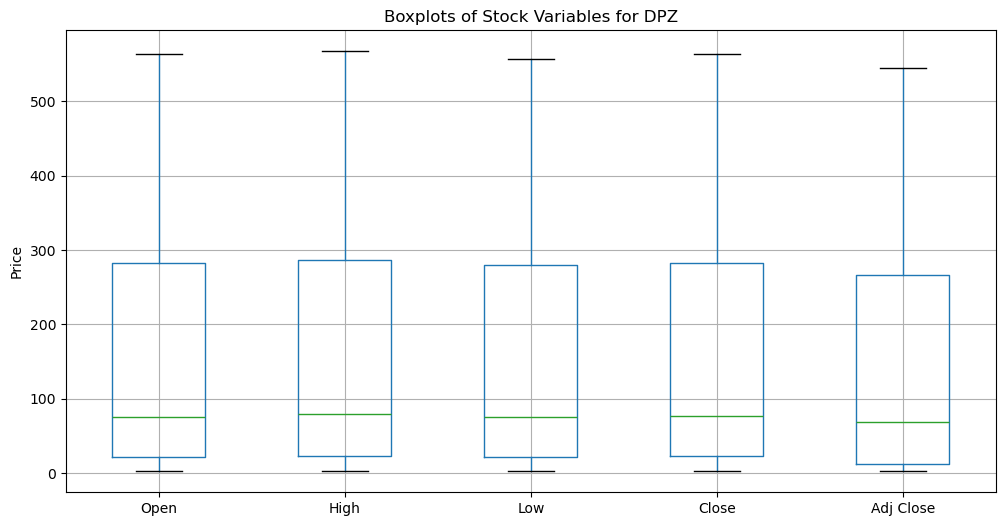

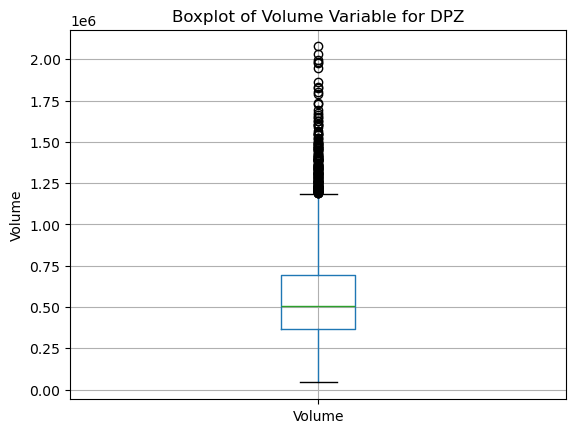

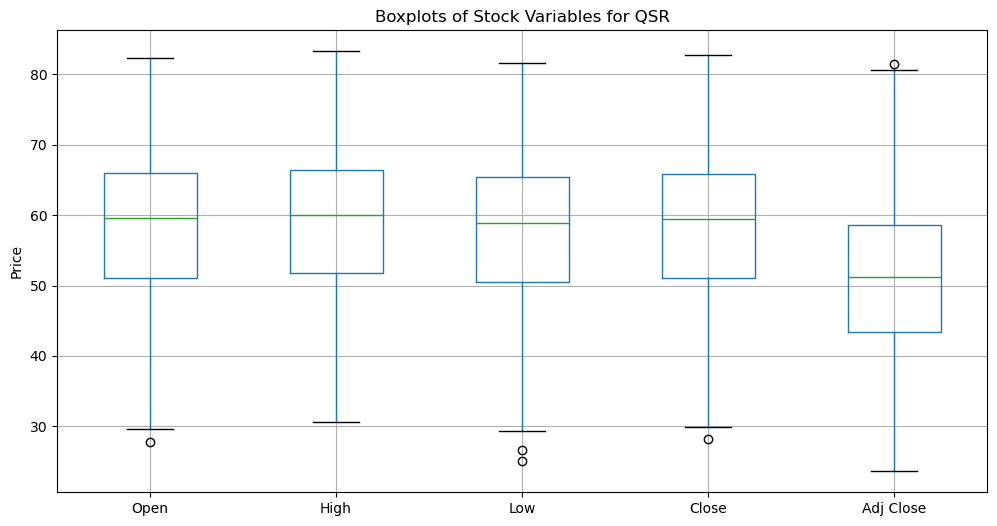

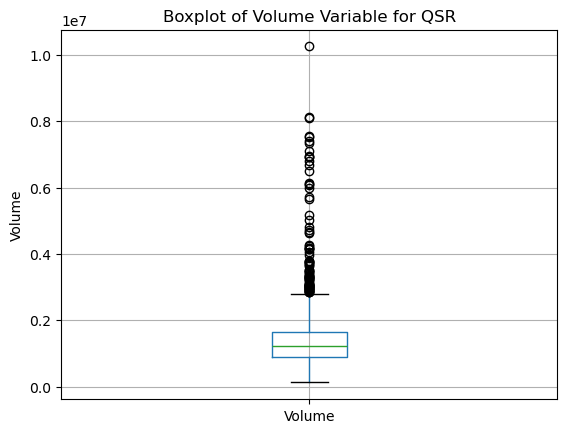

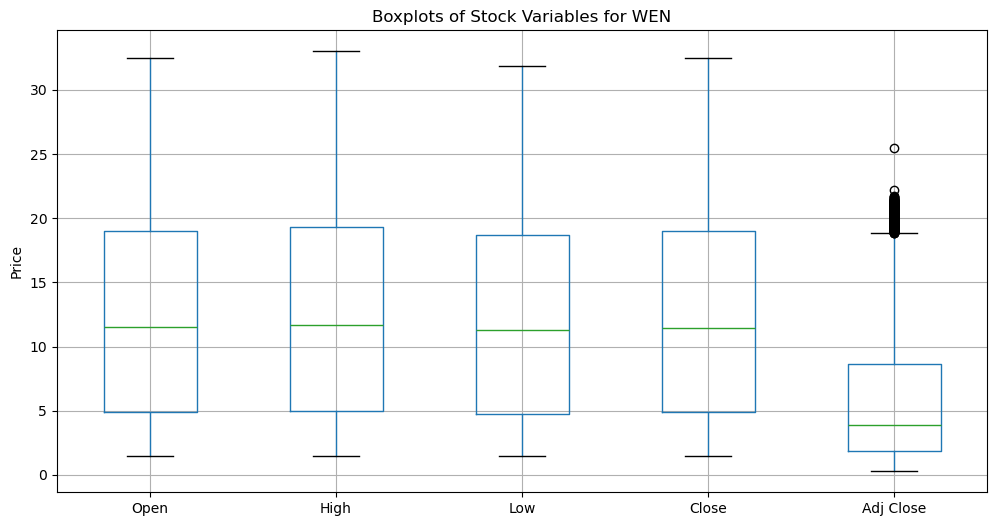

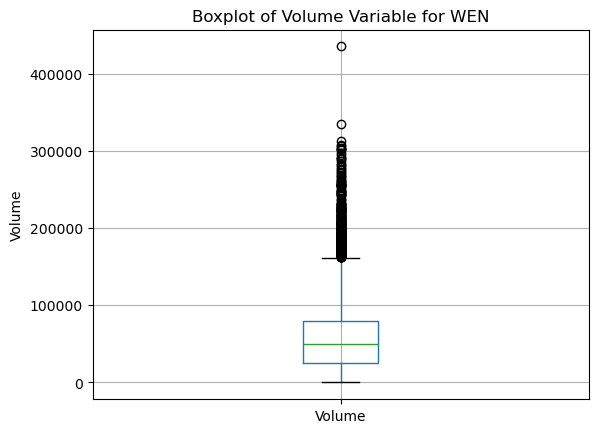

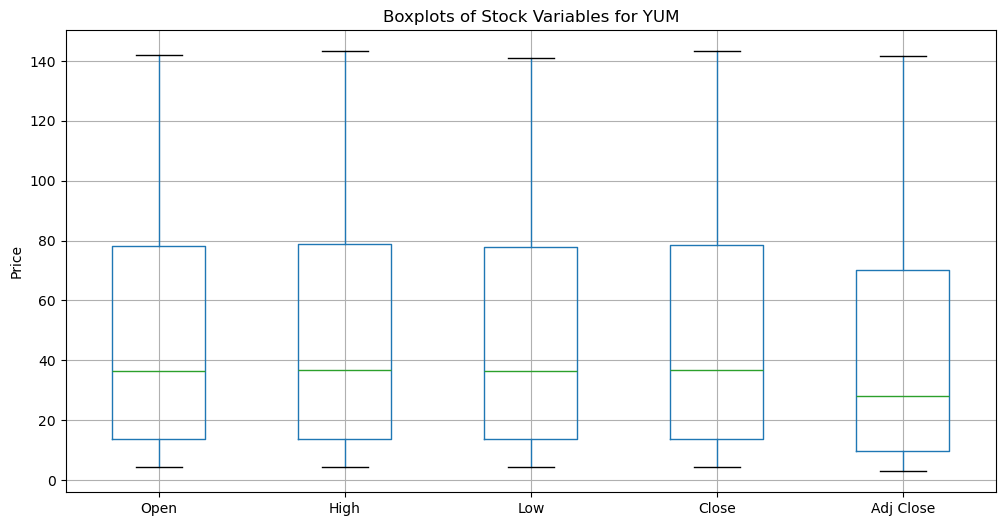

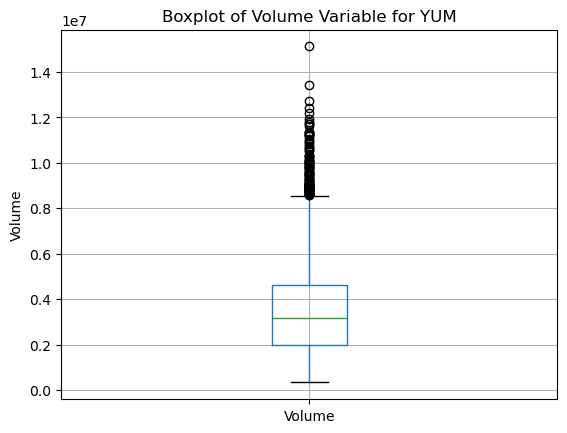

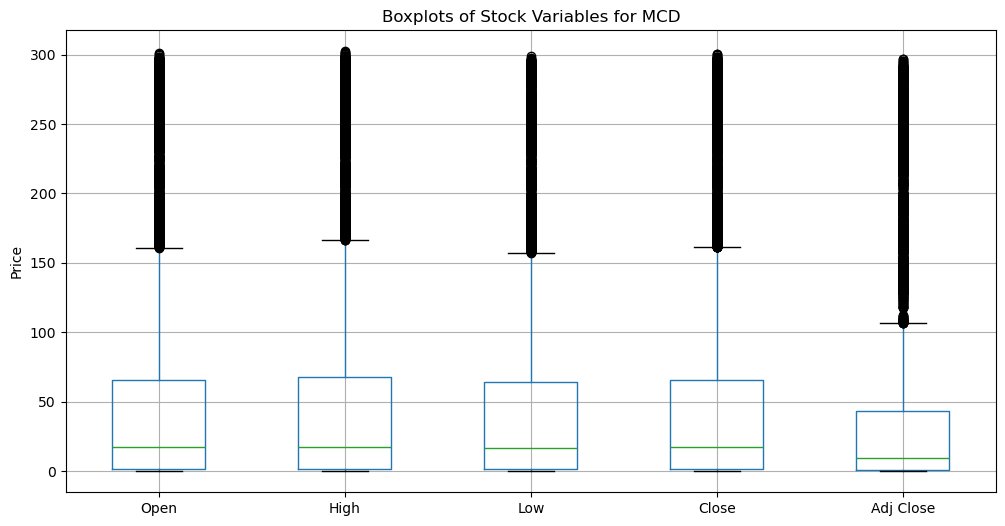

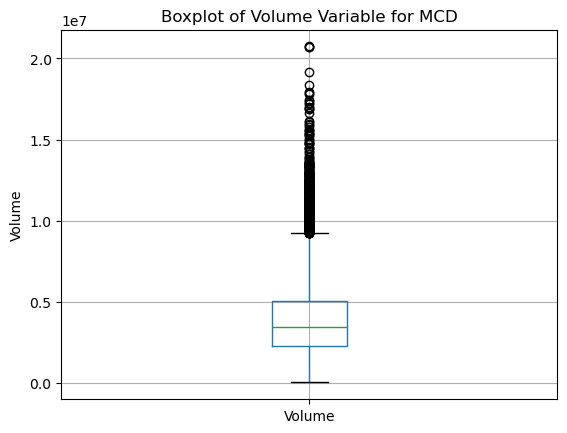

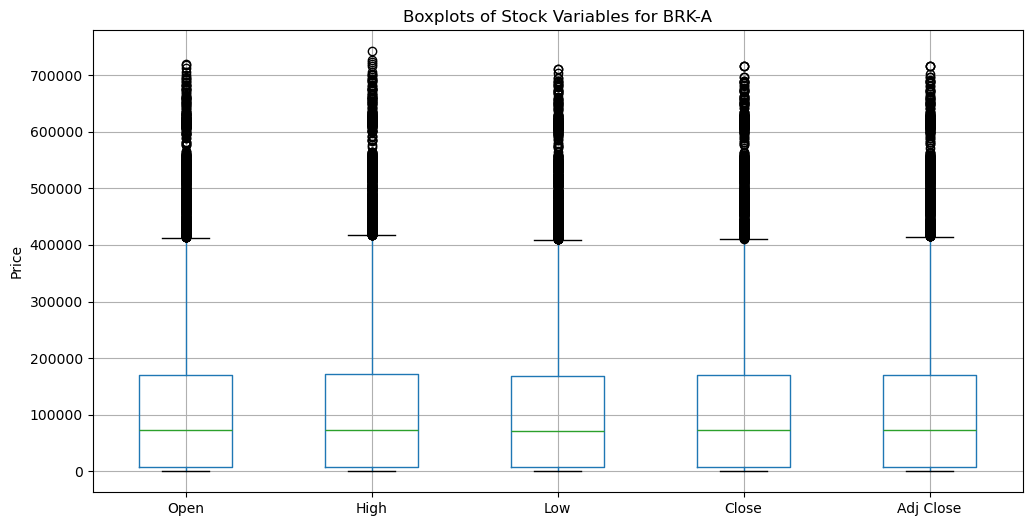

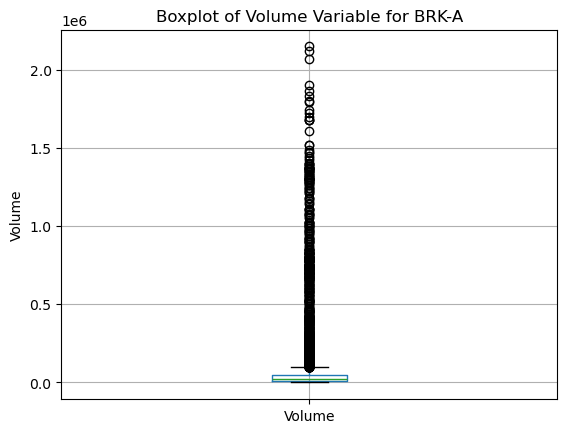

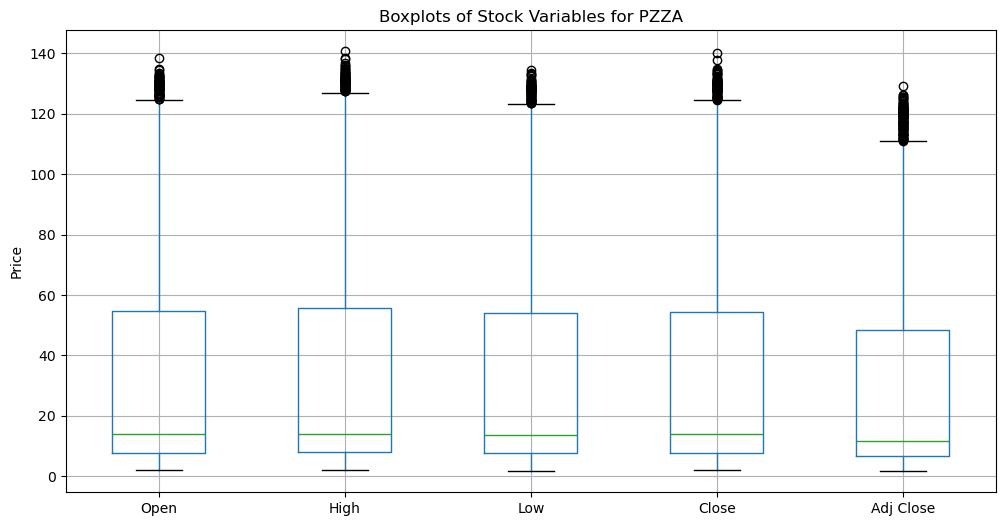

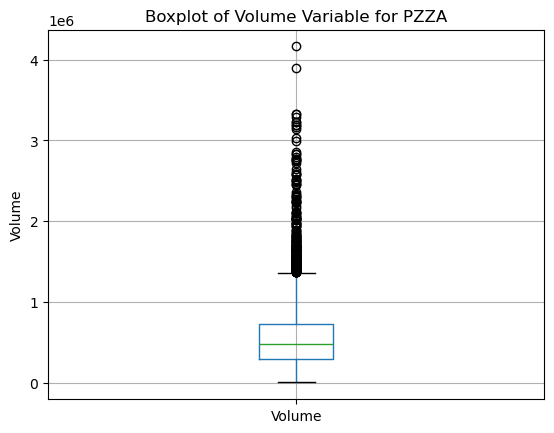

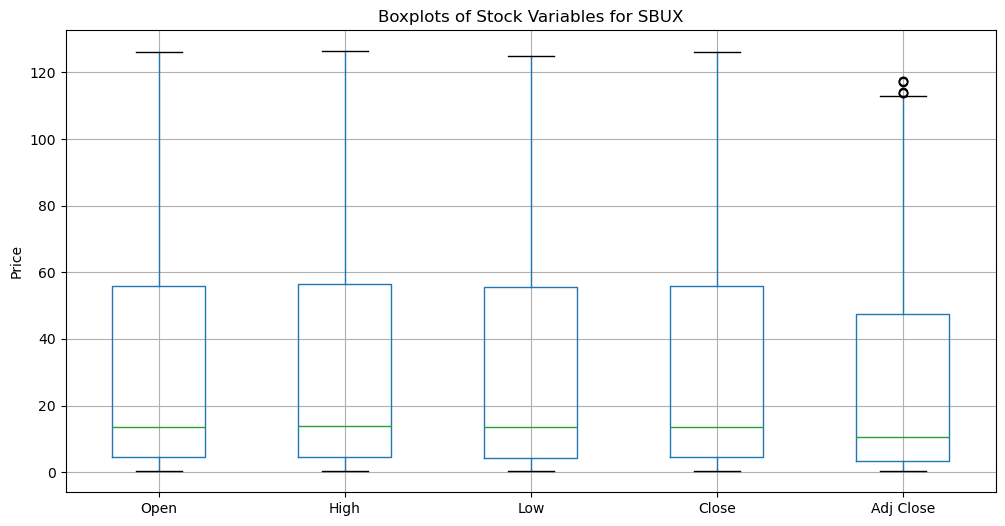

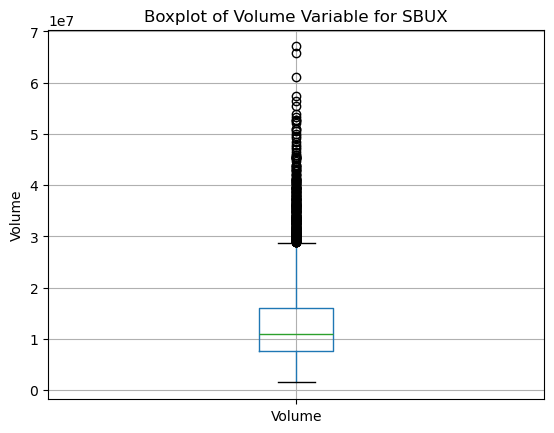

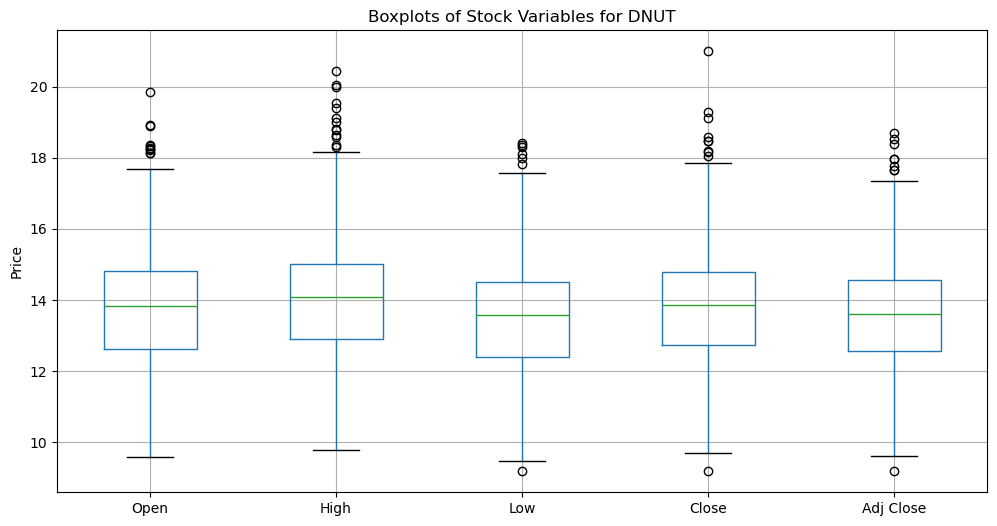

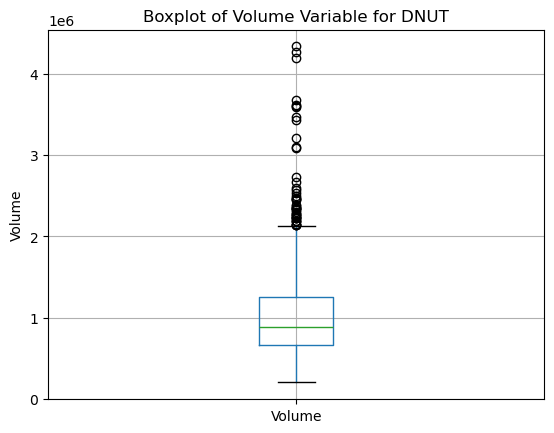

In [23]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Volume')
    plt.grid(True, axis='y')
    plt.show()

As expected, after detecting outliers and transforming them into missing values, we now observe a higher count of missing values for each variable and company. We are now dealing with around 10% missing values for the numeric variables, except for "Volume," which shows approximately 15% missing values.

In [24]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date   Open   High   Low  Close  Adj Close  Volume
LKNCY      0.0   0.0  10.07  10.81  9.70  10.37      10.37   15.56
DPZ        0.0   0.0   7.70   7.51  7.65   7.43       7.61   13.35
QSR        0.0   0.0   0.00   0.00  0.00   0.00       0.00    7.36
WEN        0.0   0.0   7.84   7.43  7.76   7.53       7.61   20.76
YUM        0.0   0.0   7.40   7.54  7.68   7.54       7.40   12.15
MCD        0.0   0.0   7.55   7.39  7.40   7.32       7.42   11.46
BRK-A      0.0   0.0   7.39   7.36  7.46   7.38       7.36   18.87
PZZA       0.0   0.0   7.36   7.52  7.43   7.66       7.48   15.87
SBUX       0.0   0.0   7.56   7.44  7.92   7.70       7.51   12.50
DNUT       0.0   0.0   7.48   8.22  9.69   7.61       7.48   17.06

#### Handling Missing Data

To address missing values in the dataset, we employed three distinct imputation techniques tailored to the nature and characteristics of each variable:

1. **Linear Interpolation**:  
   - **Variables**: `Open`, `High`, `Low`  
   - **Description**: Linear interpolation was used to estimate missing values by assuming a uniform change between adjacent known data points. This method is ideal for variables with smooth and stable patterns, such as price-related data, where continuity and gradual transitions are expected.  
   - **Process**: Missing values were calculated using the slope between the nearest known points. For edge cases where sufficient data was unavailable, forward and backward propagation techniques were applied.

2. **Adjusted Close-to-Close Ratio Estimation**:  
   - **Variables**: `Adj Close`, `Close`  
   - **Description**: For these interrelated variables, missing values were handled using a derived ratio between them. Since `Adj Close` reflects `Close` adjusted for dividends and splits, their strong relationship allowed us to calculate missing values for one variable when the other was available.  
   - **Process**: The ratio (`Adj Close / Close`) was computed for each observation, and missing values were inferred by applying this ratio to the available counterpart. This approach ensures consistency between the two variables and preserves their logical relationship.  

3. **Rolling Median Imputation**:  
   - **Variable**: `Volume`  
   - **Description**: Missing values in `Volume` were replaced using a 30-day rolling median. This choice reflects the high daily variability and event-driven nature of trading volume, making linear interpolation unsuitable.  
   - **Rationale**: The rolling median smooths out extreme values and captures typical behavior over a time window, providing a robust estimate for missing data without assuming a predictable trend.

In [25]:
# Adjusted Close-to-Close Ratio Estimation

for df in dataframes:
    print(f"Procesando: {df['Company'][0]}")
    print(f"Initial empty Close count: {df['Close'].isna().sum()}")
    print(f"Initial empty Adj Close count: {df['Adj Close'].isna().sum()}")
    
    # Round all numerical columns to 2 decimal places
    df.update(df.round(2))
    
    # Create 'Close/Adj Close Ratio' column
    df['Close/Adj Close Ratio'] = df['Close'] / df['Adj Close']

    # Fill missing 'Close' and 'Adj Close' cells using the ratio from the row above
    for index in range(1, len(df)):
        if pd.isna(df.loc[index, 'Close']) and not pd.isna(df.loc[index, 'Adj Close']):
            df.loc[index, 'Close'] = df.loc[index, 'Adj Close'] * df.loc[index - 1, 'Close/Adj Close Ratio']
        elif pd.isna(df.loc[index, 'Adj Close']) and not pd.isna(df.loc[index, 'Close']):
            df.loc[index, 'Adj Close'] = df.loc[index, 'Close'] / df.loc[index - 1, 'Close/Adj Close Ratio']

    # # Recalculate 'Close/Adj Close Ratio' and round again
    # df['Close/Adj Close Ratio'] = df['Close'] / df['Adj Close']
    # df.update(df.round(2))

    df.drop(columns=['Close/Adj Close Ratio'], inplace=True)

    # Count the number of empty 'Close' and 'Adj Close' cells
    empty_close_count = df['Close'].isna().sum()
    empty_adj_close_count = df['Adj Close'].isna().sum()    
    print(f"Final empty Close count: {df['Close'].isna().sum()}")
    print(f"Final empty Adj Close count: {df['Adj Close'].isna().sum()}")
    print("******************************************************************************")

Procesando: LKNCY
Initial empty Close count: 140
Initial empty Adj Close count: 140
Final empty Close count: 69
Final empty Adj Close count: 64
******************************************************************************
Procesando: DPZ
Initial empty Close count: 378
Initial empty Adj Close count: 387
Final empty Close count: 74
Final empty Adj Close count: 79
******************************************************************************
Procesando: QSR
Initial empty Close count: 0
Initial empty Adj Close count: 0
Final empty Close count: 0
Final empty Adj Close count: 0
******************************************************************************
Procesando: WEN
Initial empty Close count: 843
Initial empty Adj Close count: 852
Final empty Close count: 207
Final empty Adj Close count: 213
******************************************************************************
Procesando: YUM
Initial empty Close count: 513
Initial empty Adj Close count: 503
Final empty Close count: 107
Final e

In [26]:
# Rolling Median Imputation for "Volume"

window_size = 30

for df in dataframes:
    df['Volume'] = df['Volume'].combine_first(
        df['Volume'].rolling(window=window_size, min_periods=1).median()
    )

In [27]:
# Linear Interpolation

for df in dataframes:
    print(f"Processing: {df['Company'][0]}")
    print("NaN values before interpolation:")
    print(df.isnull().sum())

    for column in num_columns:
        df[column] = df[column].interpolate(method='linear', limit_direction='both')

    print("NaN values after interpolation:")
    print(df.isnull().sum())
    print("******************************************************************************")


Processing: LKNCY
NaN values before interpolation:
Date           0
Open         136
High         146
Low          131
Close         69
Adj Close     64
Volume         1
Company        0
dtype: int64
NaN values after interpolation:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Company      0
dtype: int64
******************************************************************************
Processing: DPZ
NaN values before interpolation:
Date           0
Open         392
High         382
Low          389
Close         74
Adj Close     79
Volume         6
Company        0
dtype: int64
NaN values after interpolation:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Company      0
dtype: int64
******************************************************************************
Processing: QSR
NaN values before interpolation:
Date         0
Open         0
High         0
Low          0
Close

Finally, we can observe the null values count and time series graphics obtained for each dataset after the mising data handling process.

In [28]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date  Open  High  Low  Close  Adj Close  Volume
LKNCY      0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
DPZ        0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
QSR        0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
WEN        0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
YUM        0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
MCD        0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
BRK-A      0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
PZZA       0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
SBUX       0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0
DNUT       0.0   0.0   0.0   0.0  0.0    0.0        0.0     0.0

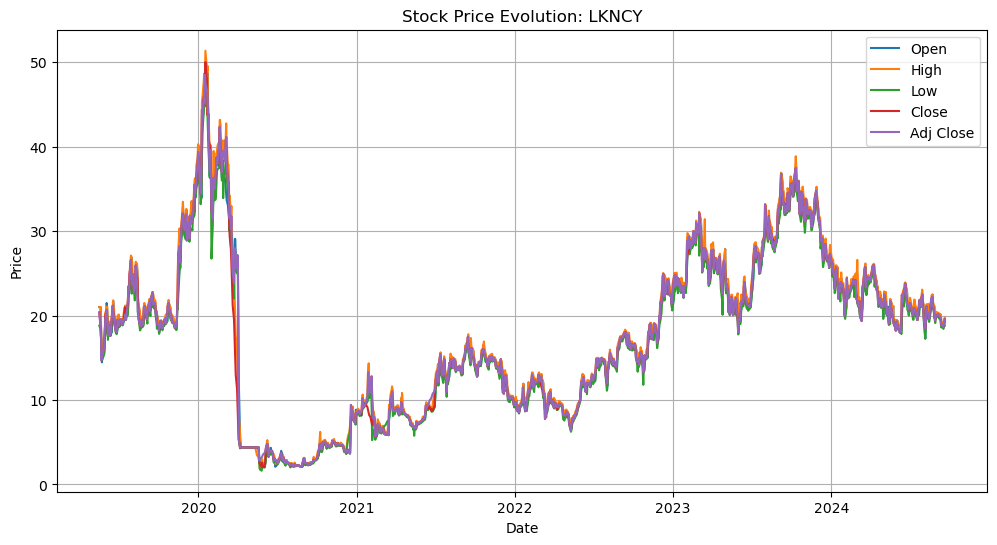

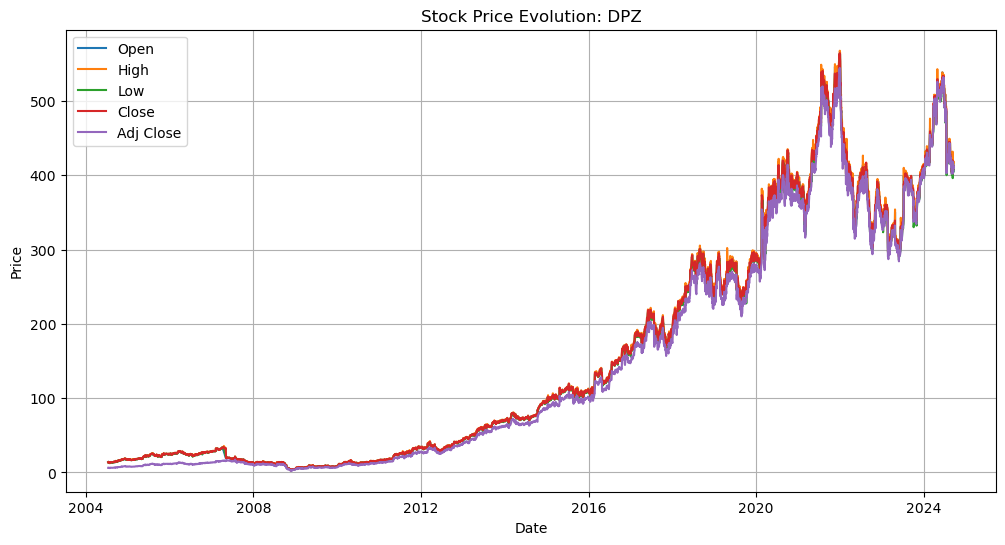

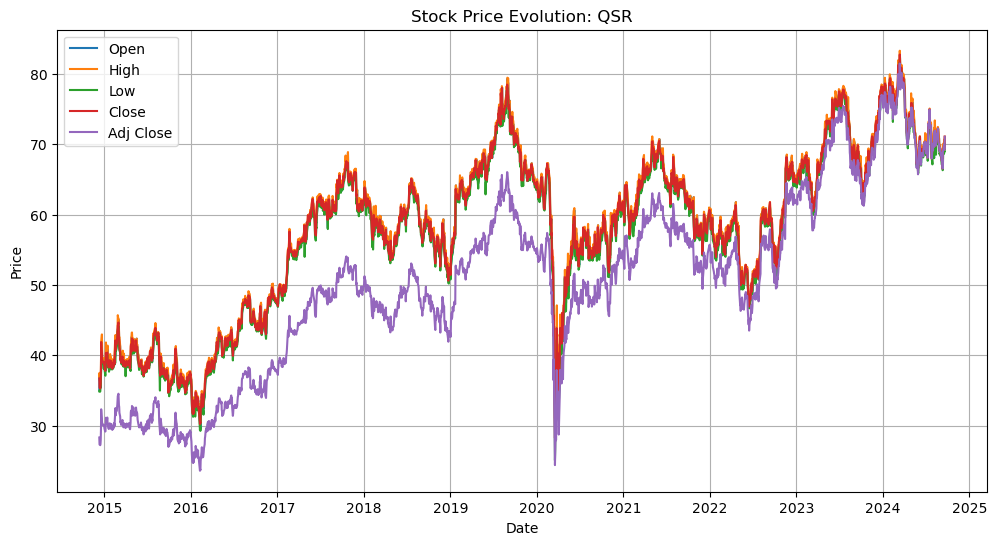

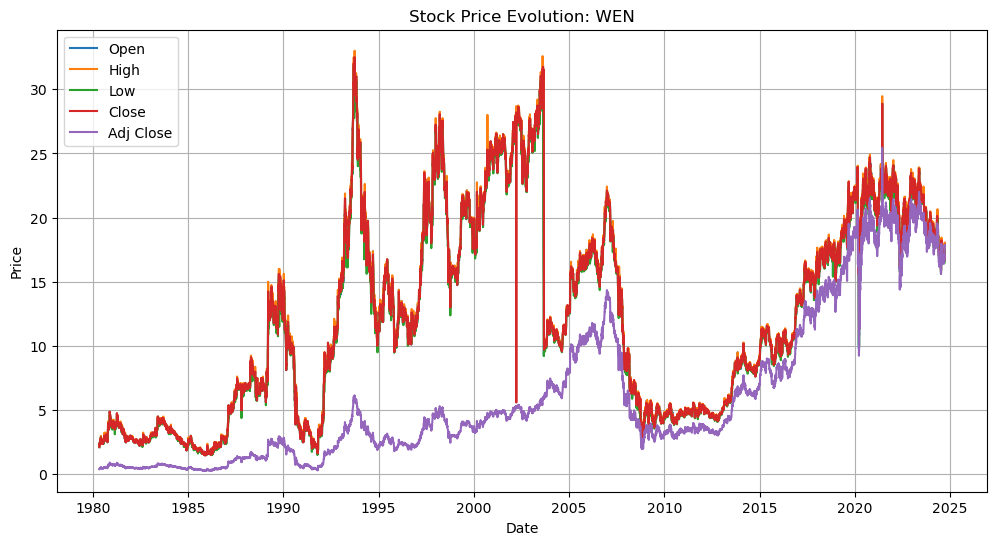

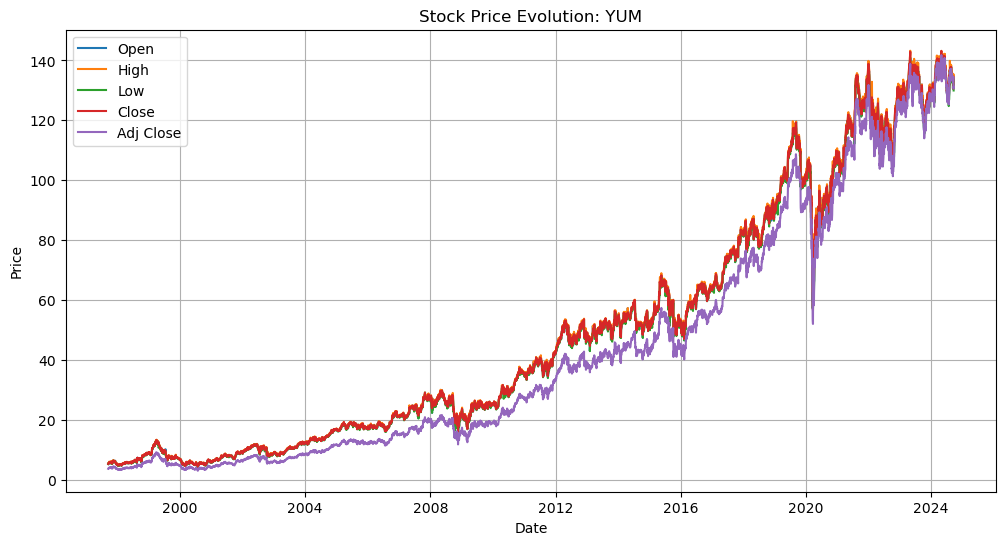

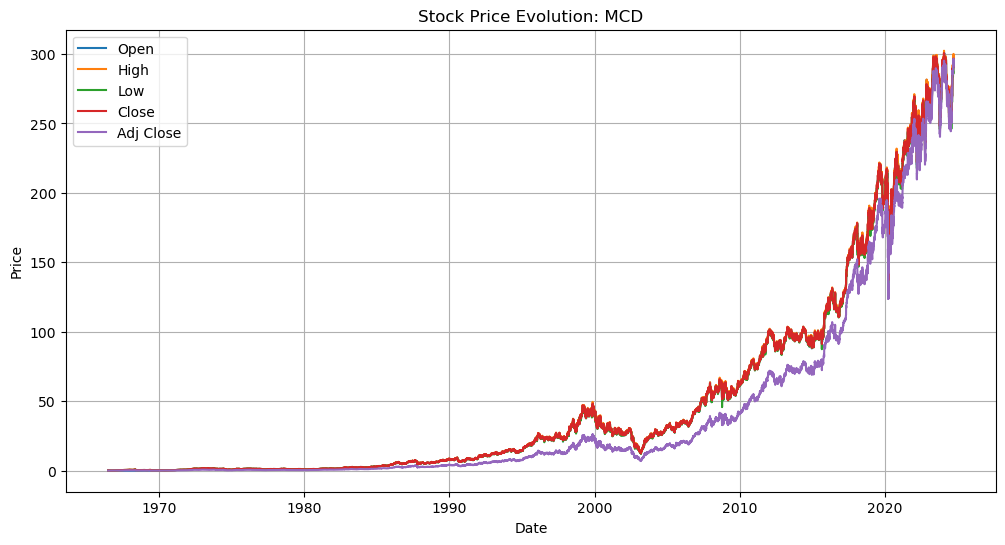

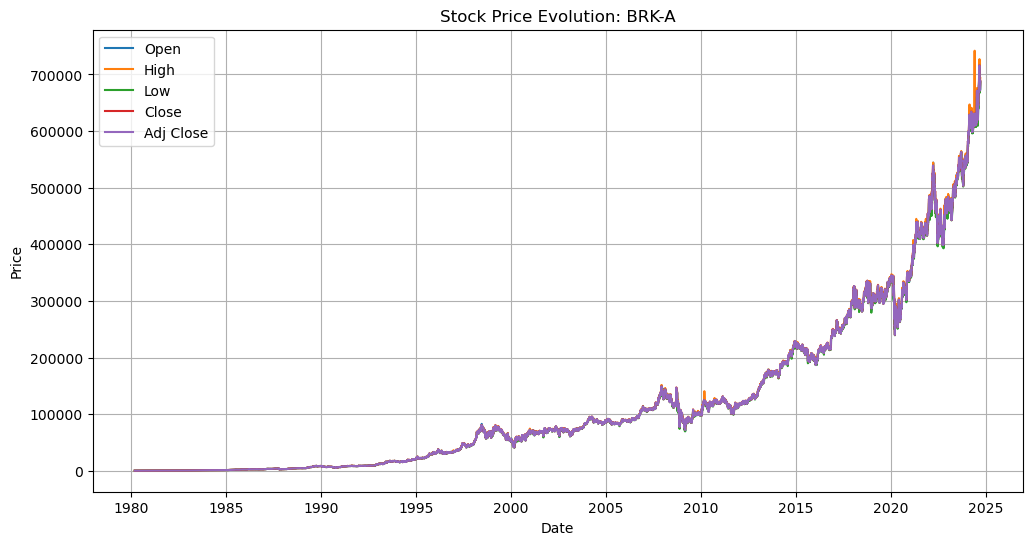

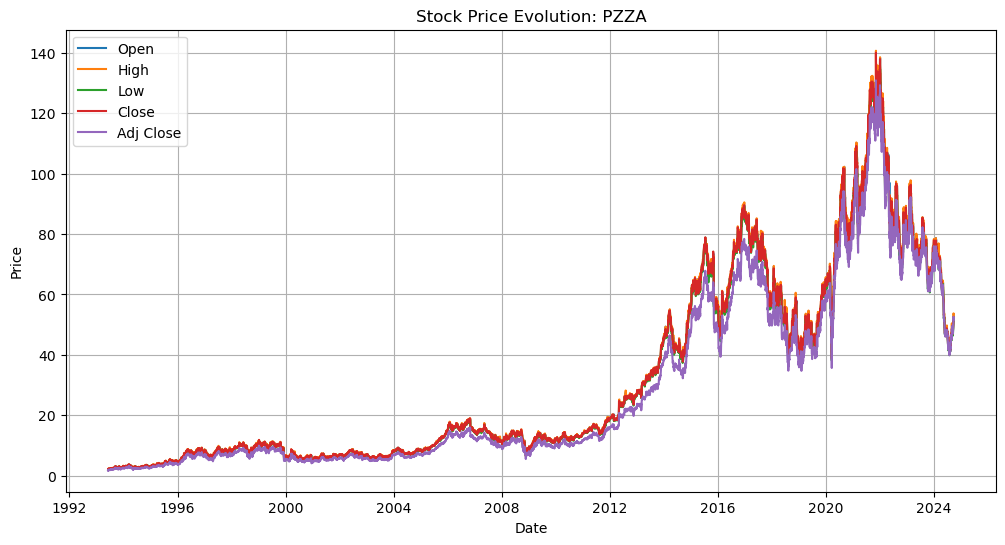

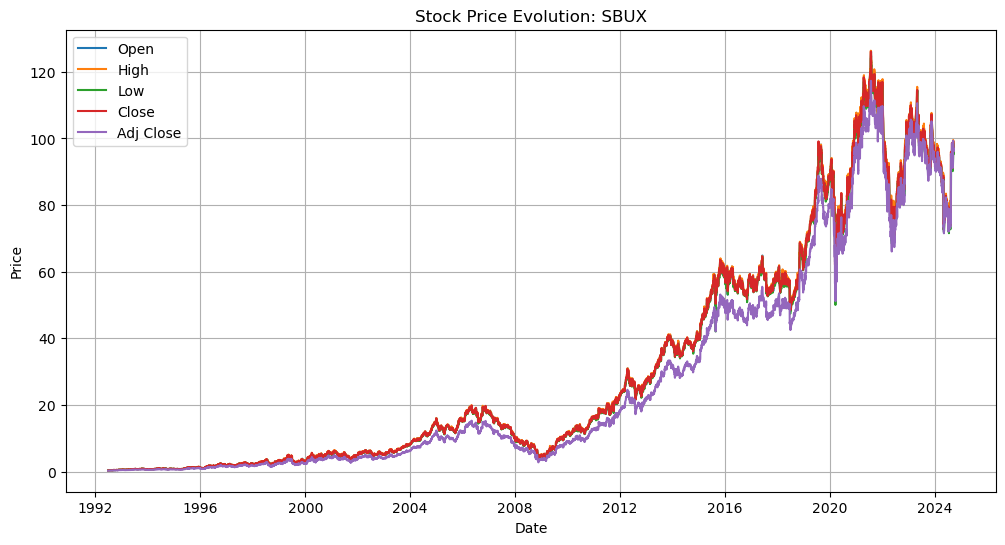

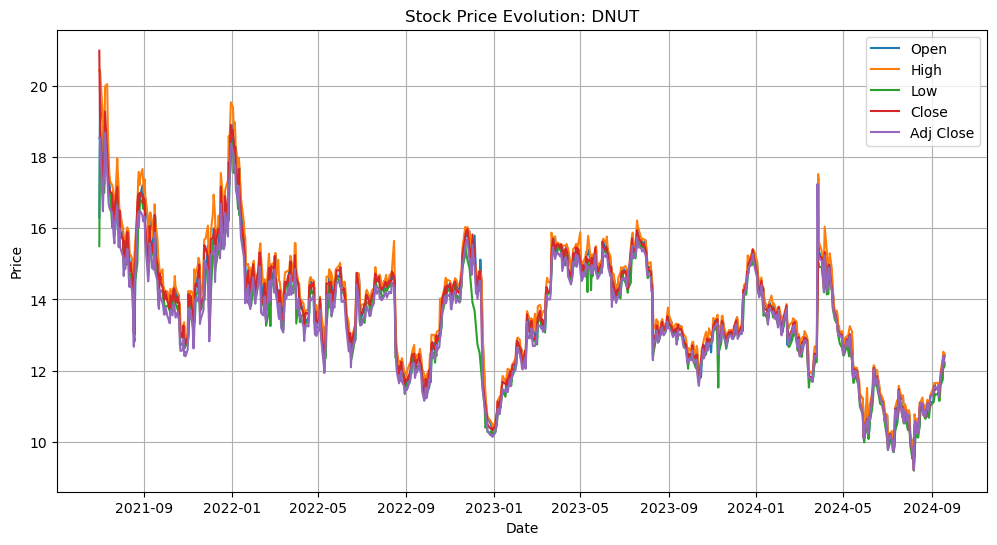

In [29]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    for variable in num_columns[:-1]:
        plt.plot(df["Date"], df[variable], label=variable)
    
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## 1. For each dataset:
Print the number of rows and columns.
Display the column names and their data types.

In [30]:
# Iterate over files in the directory
for df in dataframes:
    # Print the dataset name
    print(f"{df["Company"][0]}:")
    # Print the shape of the DataFrame
    print(f"- Number of rows and columns: {df.shape}")
    # Print the column names
    print(f"- Columns: {list(df.columns)}")
    # Print the data types of each column
    print(f"- Data types:")
    print(df.dtypes)
    print("-" * 50)  # Separator for readability

LKNCY:
- Number of rows and columns: (1350, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
DPZ:
- Number of rows and columns: (5088, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
QSR:
- Number of rows and columns: (2459, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']

### 2. Extract all rows where the date is in the year 2023.
Print the number of rows.
Visualize the Close price trend for this period.

In [31]:
sum_n_rows_2023 = []
for df in dataframes:
    company_name = df["Company"][0]
    df_2023 = df[df["Date"].dt.year == 2023]
    sum_n_rows_2023.append(df_2023.shape[0])
    print(f"The number of observations for {company_name} for year 2023 is {df_2023.shape[0]}")
sum_n_rows_2023 = sum(sum_n_rows_2023)
print(f"The number of observations in the merged dataframe for year 2023 is {sum_n_rows_2023}")

The number of observations for LKNCY for year 2023 is 251
The number of observations for DPZ for year 2023 is 250
The number of observations for QSR for year 2023 is 250
The number of observations for WEN for year 2023 is 251
The number of observations for YUM for year 2023 is 250
The number of observations for MCD for year 2023 is 250
The number of observations for BRK-A for year 2023 is 250
The number of observations for PZZA for year 2023 is 250
The number of observations for SBUX for year 2023 is 250
The number of observations for DNUT for year 2023 is 252
The number of observations in the merged dataframe for year 2023 is 2504


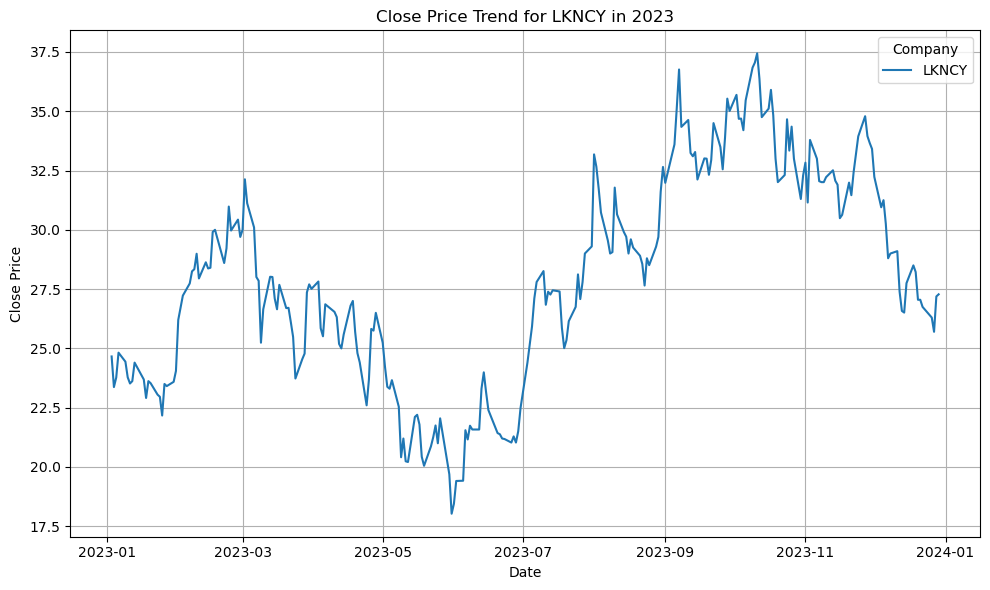

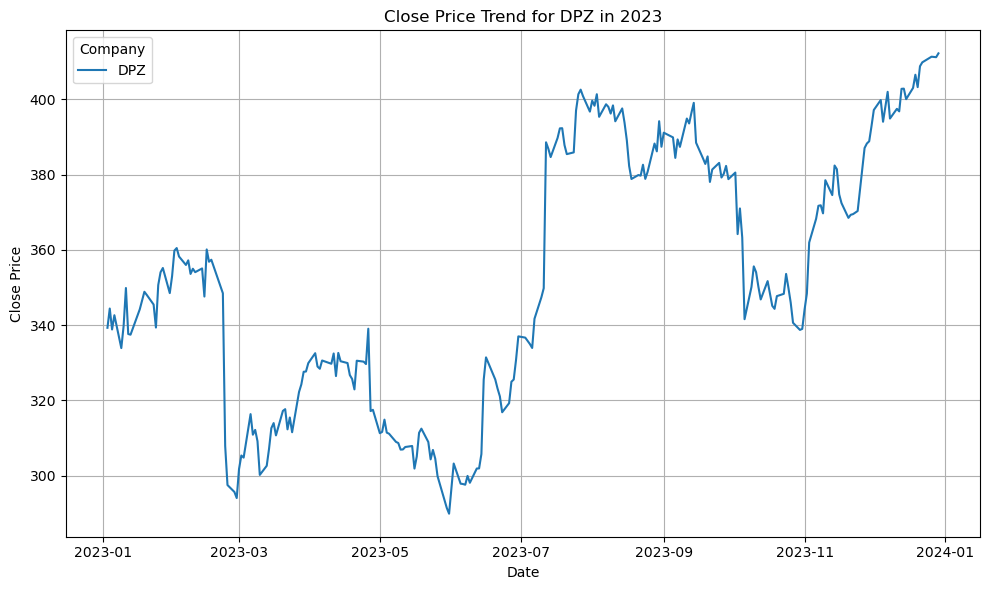

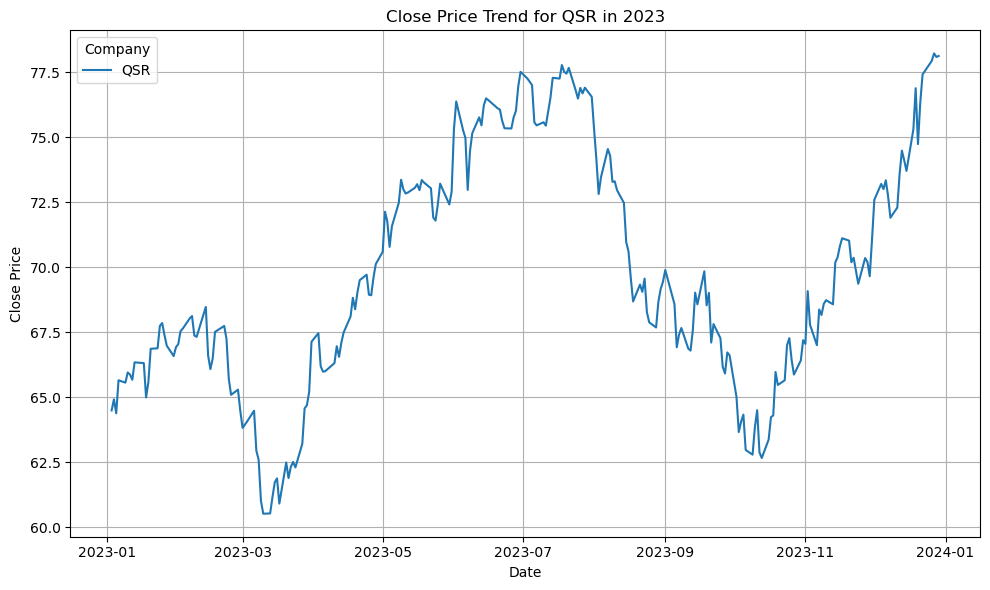

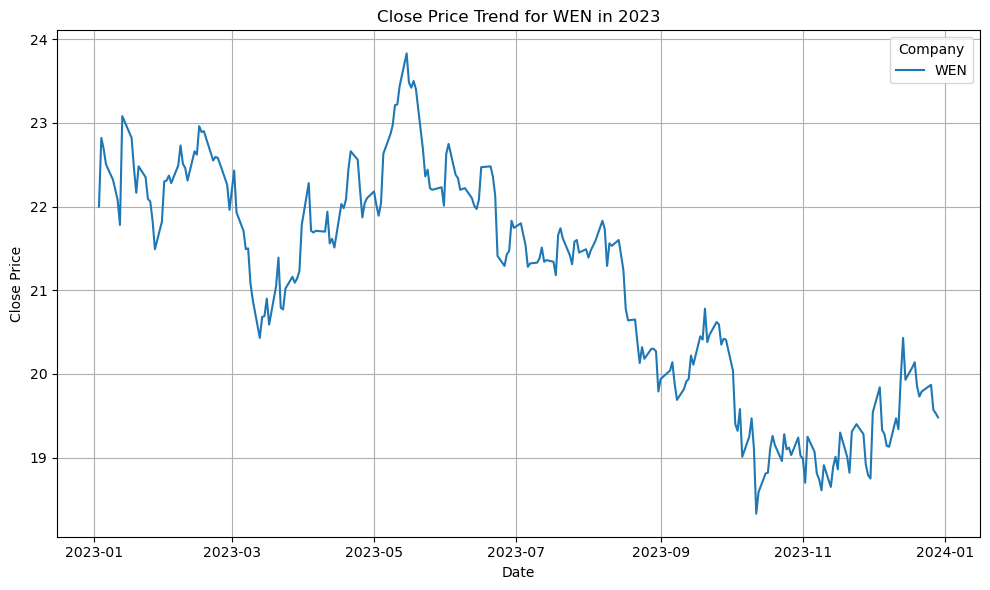

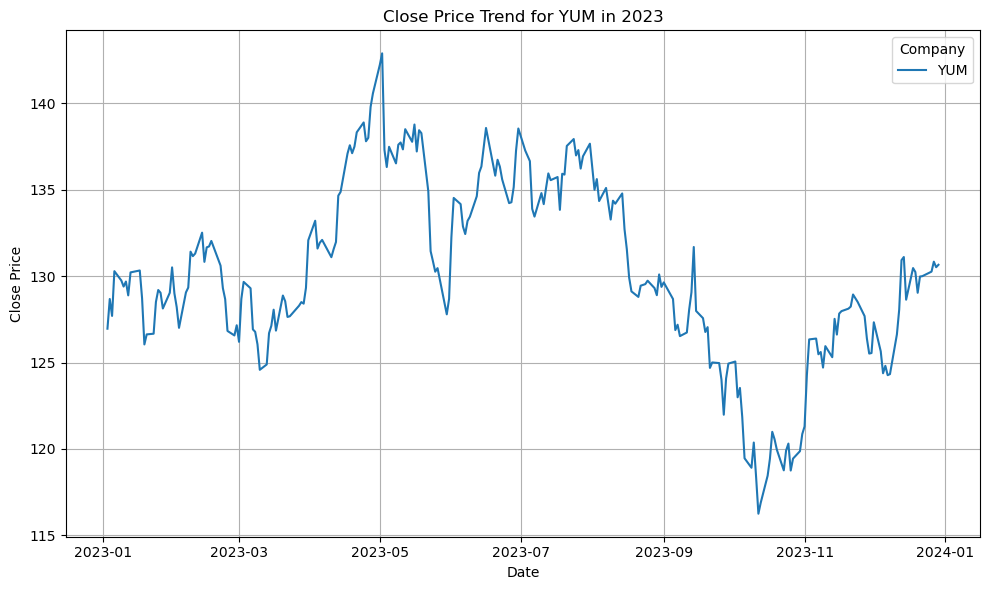

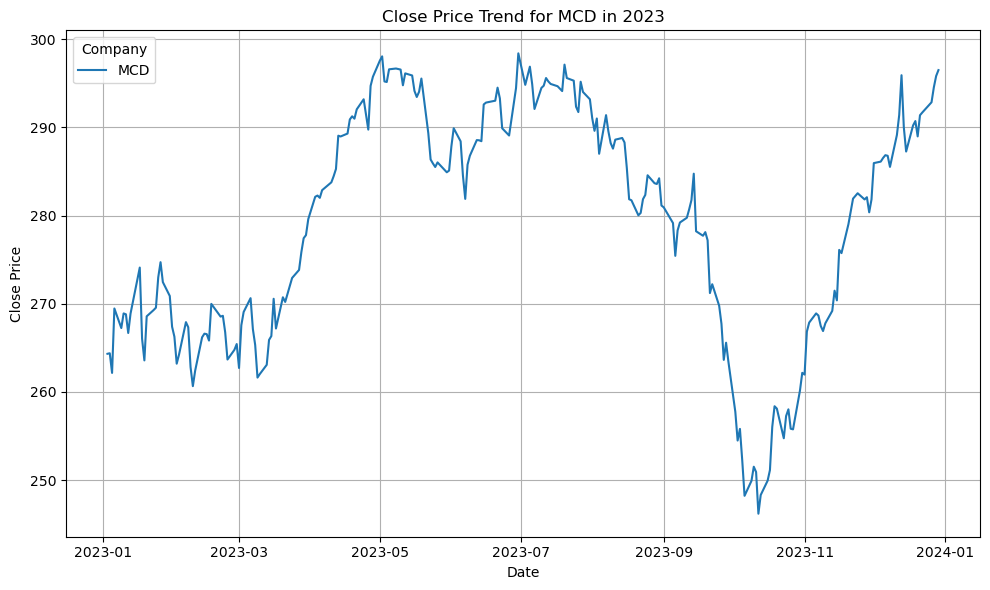

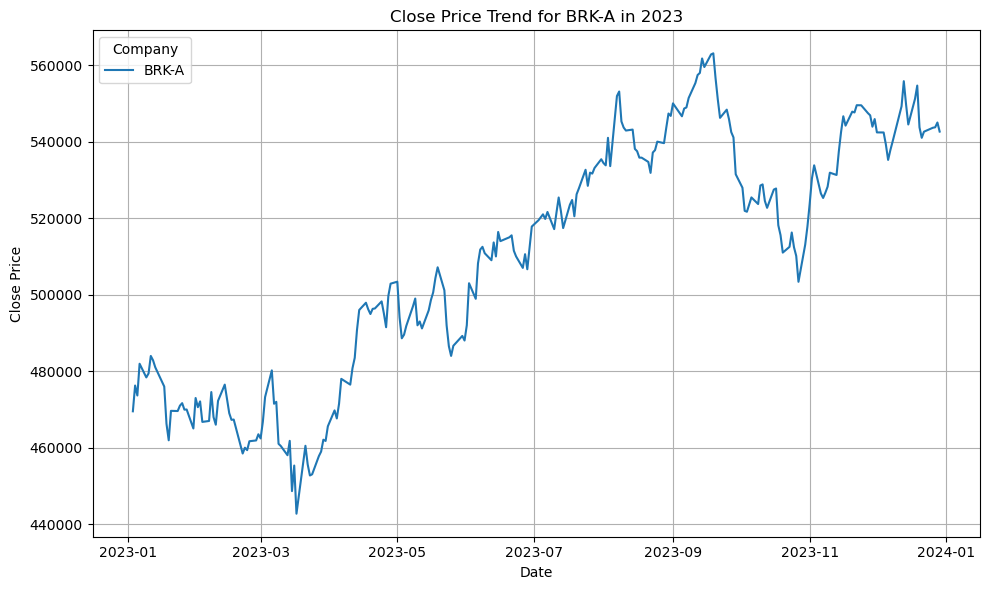

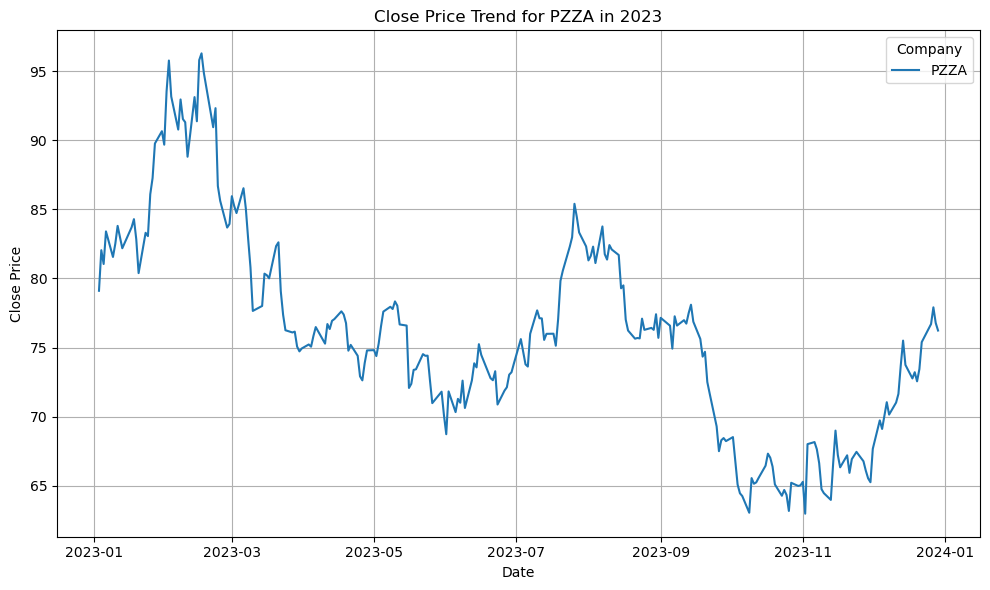

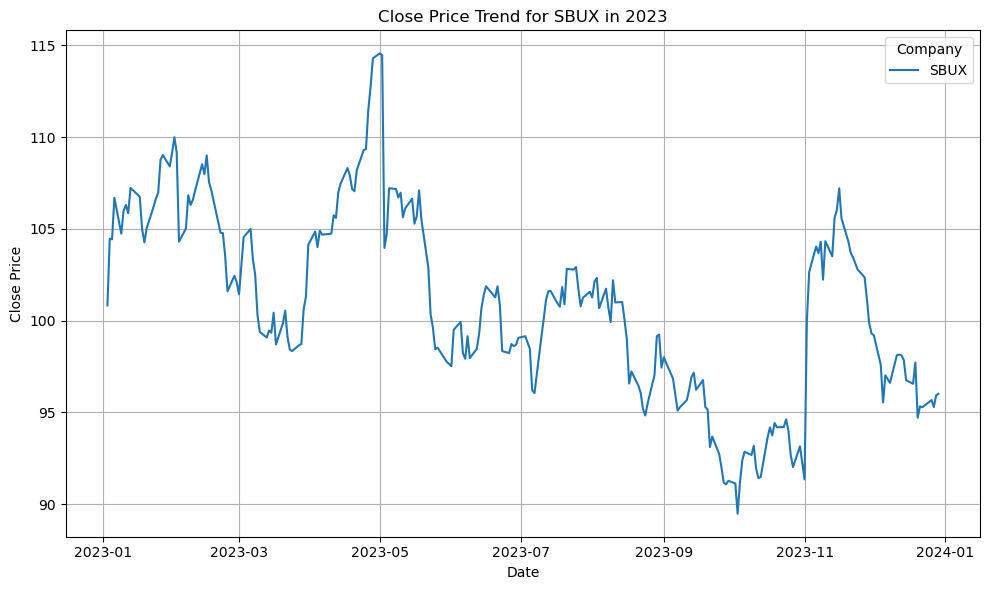

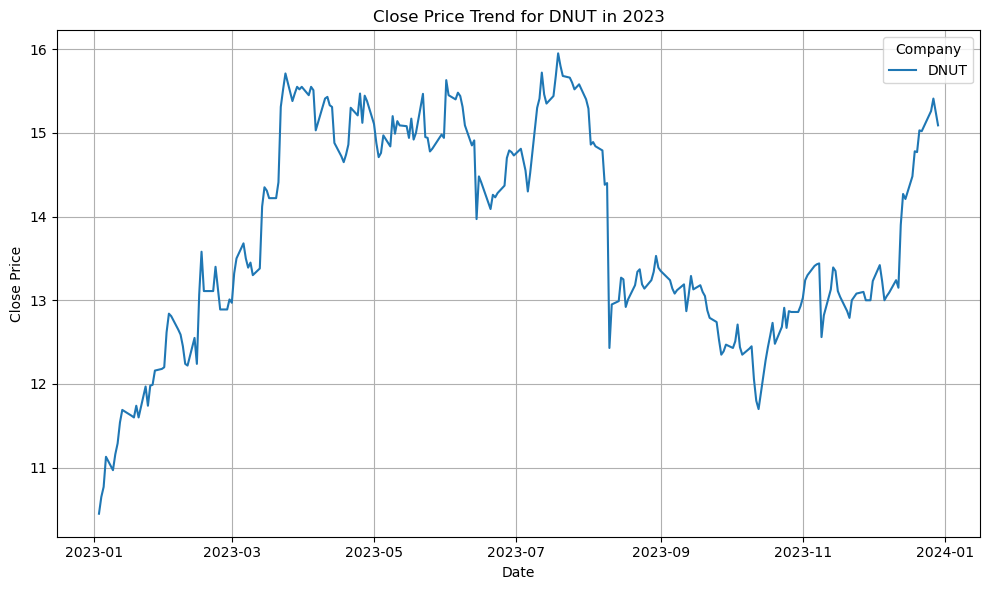

In [32]:
# Combine all DataFrames for simplicity
all_data = pd.concat(dataframes, ignore_index=True)

# Ensure 'Date' is in datetime format
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Extract rows where the year is 2023
data_2023 = all_data[all_data['Date'].dt.year == 2023]

# Plot the Close price trend for each company in separate graphs
for company in data_2023['Company'].unique():
    company_data = data_2023[data_2023['Company'] == company]
    
    plt.figure(figsize=(10, 6))
    plt.plot(company_data['Date'], company_data['Close'], label=company,)
    
    # Customize each chart
    plt.title(f"Close Price Trend for {company} in 2023")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.legend(title="Company")
    plt.tight_layout()
    
    # Display each chart
    plt.show()



### 3. For each company, find the day with the highest `Close` price.
- Display the date alongside the price.

In [33]:
# Dictionary to store results
results = {"Company": [], "Close": [], "Date": []}

for df in dataframes:
    # Extract the company name
    company_name = df["Company"].iloc[0]
    
    # Find the day with the highest Close price
    max_close_row = df.loc[df["Close"].idxmax()]
    max_date = max_close_row["Date"]
    max_close_price = max_close_row["Close"]
    
    # Append to results dictionary
    results["Company"].append(company_name)
    results["Close"].append(max_close_price)
    results["Date"].append(max_date)

# Display the results

results_df = pd.DataFrame(results)
print(results_df)


  Company      Close       Date
0   LKNCY      50.02 2020-01-17
1     DPZ     564.33 2021-12-31
2     QSR      82.75 2024-03-13
3     WEN      32.50 1993-09-29
4     YUM     143.19 2024-04-29
5     MCD     300.53 2024-01-19
6   BRK-A  715910.00 2024-09-03
7    PZZA     140.01 2021-11-04
8    SBUX     126.06 2021-07-26
9    DNUT      21.00 2021-07-01


### 4. Group the data by month and calculate the average `Close` price for each company.
- Plot these monthly averages for 3 companies and compare them.
- Justify the chart selection.

In [34]:
monthly_averages = []

for df in dataframes:
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    # Extract Year-Month for grouping
    df['YearMonth'] = df['Date'].dt.to_period('M')
    # Group by YearMonth and calculate average Close price
    company_avg = df.groupby('YearMonth')['Close'].mean().reset_index()
    # Add the Company column
    company_avg['Company'] = df['Company'].iloc[0]
    # Append to the results list
    monthly_averages.append(company_avg)

# monthly_averages is a list that contains 10 DataFrames, 1 for each company

# Combine all processed DataFrames into one
final_monthly_avg = pd.concat(monthly_averages, ignore_index=True)

# Display the result
print(final_monthly_avg)

     YearMonth      Close Company
0      2019-05  17.414000   LKNCY
1      2019-06  19.004000   LKNCY
2      2019-07  21.125455   LKNCY
3      2019-08  21.639773   LKNCY
4      2019-09  20.809500   LKNCY
...        ...        ...     ...
3316   2024-05  11.886350    DNUT
3317   2024-06  11.137569    DNUT
3318   2024-07  10.573536    DNUT
3319   2024-08  10.555682    DNUT
3320   2024-09  11.733077    DNUT

[3321 rows x 3 columns]


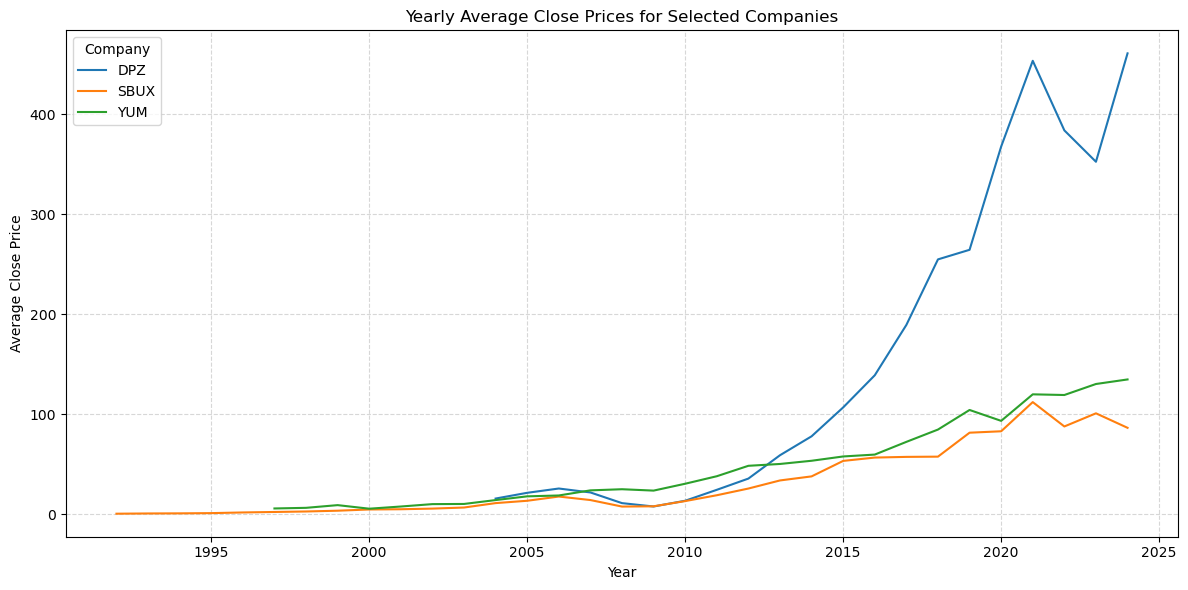

In [35]:


# Selected companies
selected_companies = ['DPZ', 'SBUX', 'YUM']

# Create an empty dictionary to store yearly average Close prices for each company
yearly_averages = {}

# Loop through the dataframes
for df in dataframes:
    # Check if the company is in the selected list
    company_name = df['Company'].iloc[0]
    # Ensure the 'Date' column is set as datetime and extract the year
    df['Year'] = df['Date'].dt.year  # Extract Year for grouping
    # Group by Year and calculate average Close prices
    yearly_avg = df.groupby('Year')['Close'].mean()
    # Store the result in the dictionary
    yearly_averages[company_name] = yearly_avg

# Combine all yearly averages into a single DataFrame for plotting
combined_df = pd.DataFrame(yearly_averages)

# Plotting
plt.figure(figsize=(12, 6))
for company in selected_companies:
    plt.plot(combined_df.index, combined_df[company], label=company)

# Chart details
plt.title('Yearly Average Close Prices for Selected Companies')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.legend(title="Company")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




### Commentary

We selected the companies DPZ, SBUX, and YUM to analyze their yearly average Close prices. The plot shows the trend of the average Close prices for each company over the years. The average Close price is calculated for each year based on the available data in the respective datasets. The chart provides a visual comparison of the yearly performance of the selected companies in terms of average Close prices.
The company selection is significant becuase we can observe that until 2010, the average close price of DPZ was lower or very close to SBUX and YUM. However, from 2010 onwards, the average close price of DPZ surpassed both SBUX and YUM, indicating a significant increase in the stock price of DPZ compared to the other two companies. This analysis can provide valuable insights into the performance and growth trends of the selected companies over the years.
Also, we can see that SBUX and YUM have a similar trend, whereas DPZ has a more distinct pattern with a noticeable increase in the average close price in recent years. This comparison can help investors and analysts understand the relative performance and valuation of these companies in the stock market.

### 5. For each company:
- Compute the yearly average of the `Close` price.
- Plot a comparison of yearly averages for all companies on a chart.
- Justify your chart selection.

In [36]:
for i, df in enumerate(dataframes):
    # Ensure the date column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract year from the Date column
    df['Year'] = df['Date'].dt.year
    
    # Calculate yearly average Close price
    yearly_avg = df.groupby('Year')['Close'].mean()
    
    # Store in dictionary with the company name (assuming a 'Company' column exists)
    company_name = df['Company'].iloc[0] if 'Company' in df.columns else f"Company {i + 1}"
    yearly_averages[company_name] = yearly_avg

# Combine the yearly averages into a single DataFrame
yearly_avg_df = pd.DataFrame(yearly_averages)

# Reset the index for display
yearly_avg_table = yearly_avg_df.reset_index()
yearly_avg_table = yearly_avg_table.rename(columns={'index': 'Year'})
yearly_avg_table.fillna("N/A", inplace=True)  # Handle missing data

# Display the table
print(yearly_avg_table)

    Year      LKNCY         DPZ        QSR        WEN         YUM         MCD  \
0   1966        N/A         N/A        N/A        N/A         N/A    0.203280   
1   1967        N/A         N/A        N/A        N/A         N/A    0.462357   
2   1968        N/A         N/A        N/A        N/A         N/A    0.574567   
3   1969        N/A         N/A        N/A        N/A         N/A    0.386254   
4   1970        N/A         N/A        N/A        N/A         N/A    0.318365   
5   1971        N/A         N/A        N/A        N/A         N/A    0.661973   
6   1972        N/A         N/A        N/A        N/A         N/A    1.356008   
7   1973        N/A         N/A        N/A        N/A         N/A    1.599238   
8   1974        N/A         N/A        N/A        N/A         N/A    1.089008   
9   1975        N/A         N/A        N/A        N/A         N/A    1.191676   
10  1976        N/A         N/A        N/A        N/A         N/A    1.425537   
11  1977        N/A         

/var/folders/tf/08rb0nn57m3d4r1xtf8cs9l80000gn/T/ipykernel_93086/2417592428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  yearly_avg_table.fillna("N/A", inplace=True)  # Handle missing data


### Commentary:
Next, we aim to visualize the yearly percentage changes for all 10 companies with the use of the above-defined table `yearly_avg_table`. It's important to note that some companies were listed earlier than others, resulting in varying time horizons across the companies.

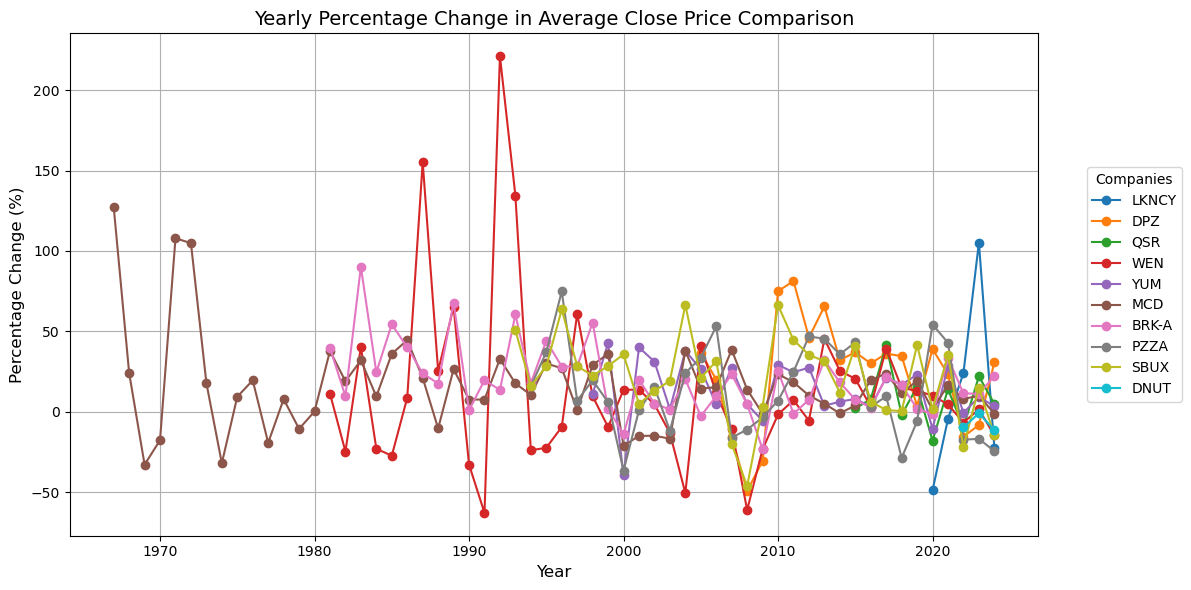

In [37]:
# Compute yearly percentage change in close prices
percentage_change_data = {}

for company in yearly_avg_table.columns[1:]:  # Exclude 'Year' column
    if company != "Company":  # Exclude the "Company" column
        yearly_avg_table[company] = pd.to_numeric(yearly_avg_table[company], errors='coerce')  # Ensure numeric values
        percentage_change = yearly_avg_table[company].pct_change() * 100
        percentage_change_data[company] = percentage_change

# Convert the percentage change data into a DataFrame
percentage_change_df = pd.DataFrame(percentage_change_data)
percentage_change_df['Year'] = yearly_avg_table['Year']

# Plotting the percentage change comparison
plt.figure(figsize=(12, 6))
for company in percentage_change_data.keys():
    valid_data = percentage_change_df[['Year', company]].dropna()  # Drop rows with NA values
    plt.plot(
        valid_data['Year'],
        valid_data[company],
        marker='o',
        label=company
    )

plt.title("Yearly Percentage Change in Average Close Price Comparison", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage Change (%)", fontsize=12)
plt.legend(
    title="Companies",
    bbox_to_anchor=(1.05, 0.5),  # Position legend to the right of the plot
    loc='center left',  # Centered vertically, left-aligned to the anchor
    borderaxespad=0.0
)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


## Trend Analysis

1. **Maturity**: The post-2000 era demonstrates a significant reduction in volatility for most companies, reflecting their transition into more mature phases of growth. For example, companies like McDonald's (MCD) and Starbucks (SBUX) had largely established their global footprints by the 2000s. With diversified revenue streams across multiple regions, these companies became less vulnerable to economic conditions in any single market. Additionally, their increased business scale and operational efficiency contributed to lower stock price volatility, as illustrated in the graph. 

2. **Economic Cycles (Booms and Recessions)**: The graph captures broader market trends and the influence of economic cycles on performance. The fast-food and beverage sectors, being closely tied to disposable income, are inherently cyclical. Recessionary periods, such as those in the 1980s and 2000s, likely led to earnings volatility and corresponding declines in stock performance, explaining the dips seen in certain years. Conversely, economic boom periods are also evident in the chart. For instance, during the 2010s, nearly all 10 companies displayed consistently positive annual performance, reflecting the favorable economic environment of that decade.

3. **Market Saturation and Innovation**: The stabilization in volatility post-2000 also reflects market saturation within the fast-food and beverage sectors. By this period, many companies had reached their peak expansion in developed markets, limiting opportunities for exponential growth. This saturation necessitated a shift toward innovation to maintain relevance and attract new customers. Strategies such as menu diversification, sustainability initiatives, and the adoption of digital tools (e.g., delivery apps and loyalty programs) likely played a role in sustaining performance. However, the reduced growth potential in saturated markets contributed to the more predictable and less volatile stock performance observed in the graph.


## Justification of Chart Selection
A line graph is the most effective visual tool for presenting the performance of all companies at a glance. As noted above, the differing IPO dates of the companies create challenges for direct comparison due to the varying time horizons. The line graph effectively illustrates these distinct time frames, providing a clear overview despite the differences.

Alternative visualizations, such as pie charts or bar graphs, are unsuitable for this analysis because they fail to capture the fluctuations in annual performance over time. Using these formats would require condensing each company's annual performance data into a single metric, obscuring valuable insights about their actual performance trends.

That said, a key drawback of line graphs is that they can become difficult to interpret when plotting data for 10 companies simultaneously. To address this, we created additional graphics to provide a clearer view of the data. Each graph is accompanied by a brief commentary to enhance understanding.

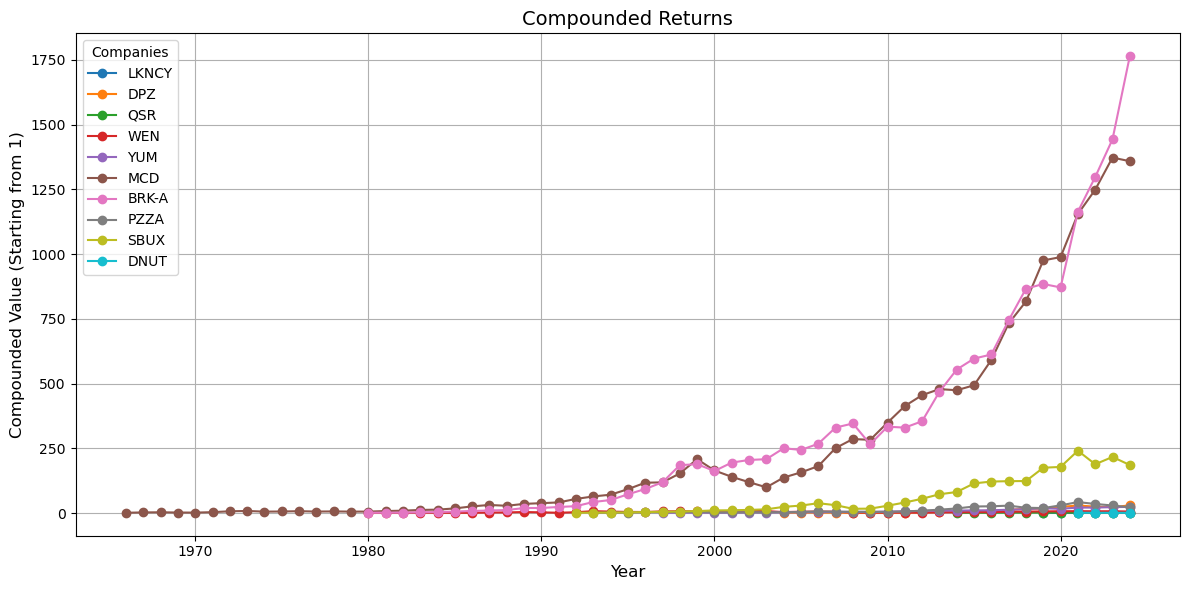

In [38]:
compounded_returns = {}

for company in yearly_avg_table.columns[1:]:  # Exclude 'Year' column
    yearly_avg_table[company] = pd.to_numeric(yearly_avg_table[company], errors='coerce')  # Ensure numeric values
    
    # Calculate percentage change and compounded returns
    percentage_change = yearly_avg_table[company].pct_change().fillna(0)
    compounded_return = (1 + percentage_change).cumprod()
    
    # Keep only the last occurrence of 1 before transitioning to non-1 values
    data = compounded_return.copy()
    one_mask = (data == 1)
    keep_last_one = one_mask & (~one_mask.shift(-1, fill_value=False))
    data[one_mask & ~keep_last_one] = None  # Remove all earlier 1s except the last one
    compounded_returns[company] = data

# Combine all compounded return data into a single DataFrame for plotting
compounded_returns_df = pd.DataFrame(compounded_returns)
compounded_returns_df['Year'] = yearly_avg_table['Year']

# Plotting the compounded returns comparison
plt.figure(figsize=(12, 6))
for company in compounded_returns_df.columns[:-1]:  # Exclude 'Year' column
    valid_data = compounded_returns_df[['Year', company]].dropna()  # Drop rows with NA values for each company
    if not valid_data.empty:  # Ensure data exists for the company
        plt.plot(
            valid_data['Year'],
            valid_data[company],
            marker='o',
            label=company
        )

plt.title("Compounded Returns", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Compounded Value (Starting from 1)", fontsize=12)
plt.legend(title="Companies")
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


### Commentary:
The diagram shows the compounded returns for the Closing Price of all 10 companies. Among these, McDonald's (MCD) demonstrates the highest overall performance, indicating it would have been the most profitable investment if purchased at its IPO. However, this conclusion may be misleading... The following shows a comparison of the performance when taking a look at the Adjusted Closing Price. 

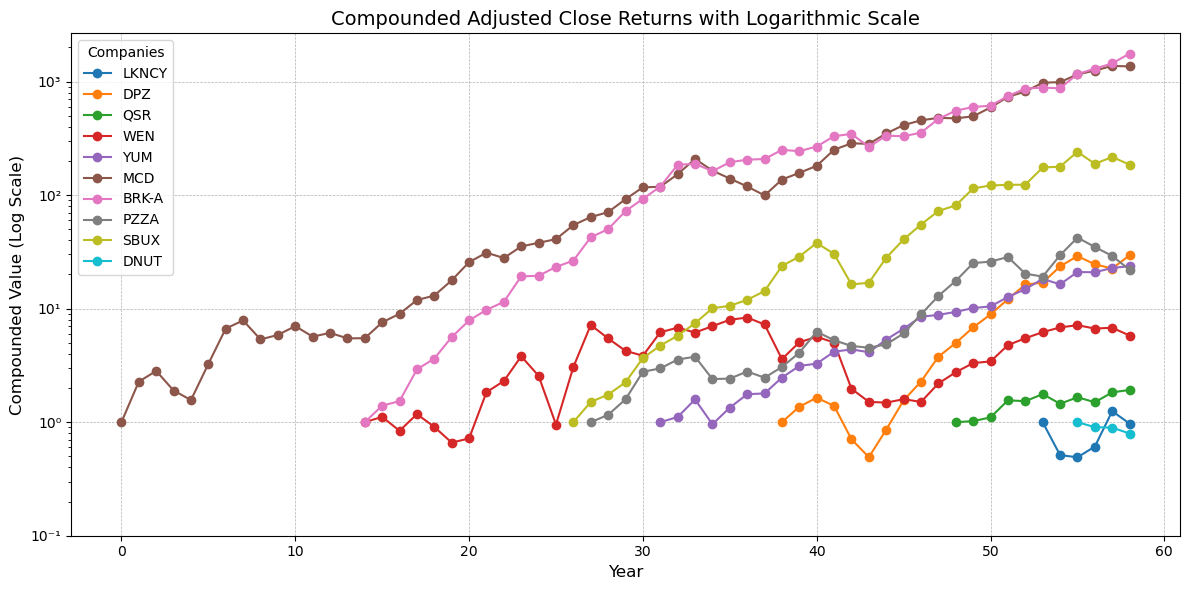

In [39]:
# Adjusting data for plotting (handling negative, zero, and equal-to-1 values except the last 1)
adjusted_compounded_returns_df = compounded_returns_df.copy()

# Iterate through columns to handle values
for column in adjusted_compounded_returns_df.columns:
    if column != 'Year' and column != 'Company':  # Exclude 'Year' and 'Company' columns
        # Work on a copy of the column to avoid SettingWithCopyWarning
        data = adjusted_compounded_returns_df[column].copy()
        
        # Replace non-positive values with NaN
        data[data <= 0] = None
        
        # Identify and keep only the last 1 before transition to non-1 values
        one_mask = (data == 1)
        keep_last_one = one_mask & (~one_mask.shift(-1, fill_value=False))
        data[one_mask & ~keep_last_one] = None  # Remove all other 1s except the last one
        
        # Assign the modified data back to the DataFrame
        adjusted_compounded_returns_df[column] = data

# Plotting the adjusted data with a logarithmic y-axis scale
plt.figure(figsize=(12, 6))
for company in adjusted_compounded_returns_df.columns:
    if company != 'Year' and company != 'Company':  # Exclude 'Year' and 'Company' columns
        plt.plot(
            adjusted_compounded_returns_df.index, 
            adjusted_compounded_returns_df[company], 
            marker='o', 
            label=company
        )

# Chart formattings
plt.title("Compounded Adjusted Close Returns with Logarithmic Scale", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Compounded Value (Log Scale)", fontsize=12)
plt.yscale("log")  # Logarithmic scale for the y-axis
plt.yticks(
    [10**-1, 10**0, 10**1, 10**2, 10**3],  # Define power-of-10 ticks
    labels=["10⁻¹", "10⁰", "10¹", "10²", "10³"]  # Custom labels for ticks
)
plt.grid(True, which="major", linestyle="--", linewidth=0.5)
plt.legend(title="Companies")
plt.tight_layout()

# Display the plot
plt.show()


### Commentary:
The compounded returns for the adjusted prices, presented on an exponential scale, reveal a different perspective. Notably, Berkshire Hathaway (BRK-A) emerges as the best-performing stock when measured from its IPO. Interestingly, a quick Google search clarifies the discrepancy between Close and Adjusted Close prices: since its IPO in 1965, McDonald's has undergone a total of 12 stock splits, artificially diluting the stock's nominal value. Consequently, relying solely on the Closing Price can provide a misleading representation of performance. Based on these findings, we have decided to compute and analyze both Close and Adjusted Close values in the following exercises.

### **NOTE**: 
The following shows diagrams for both the **Close and Adjusted Close values** to provide a comprehensive view of stock performance. The Adjusted Close offers a more comparable dataset as it accounts for the effects of dividends and stock splits, which can otherwise distort average returns and performance metrics.

Dividends and stock splits often obscure the true underlying stock performance by introducing fluctuations in the raw closing price. This is particularly relevant for companies like Wendy's (WEN) and Starbucks (SBUX), which have undergone multiple stock splits in the past. While these splits caused significant changes in the closing price, they did not impact the company’s market capitalization, highlighting the importance of using adjusted values for accurate analysis.

To ensure full transparency and present both perspectives, we have included graphs for both the Close and Adjusted Close values. This approach allows for a clear comparison between the raw price trends and the normalized, performance-adjusted data.

# Bar Graph

We decided to present the data in a different format because, so far, we have only analyzed it using a constant time scale starting from McDonald's IPO in 1965. However, this approach provides limited insights, as it does not account for the average annual performance of each company. To better understand which business has delivered the highest average returns, we created a bar graph analysis for both Close and Adjusted Close values. This approach offers a clearer comparison of annualized performance across companies.

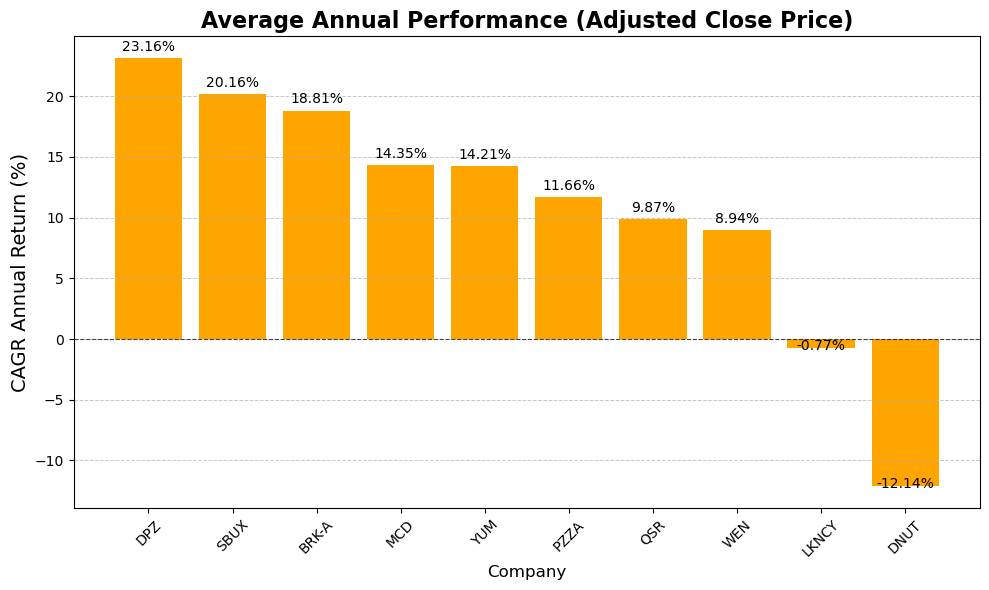

In [86]:

#Adjusted Close
# Function to calculate CAGR
def calculate_cagr(start_value, end_value, periods):
    return ((end_value / start_value) ** (1 / periods) - 1) * 100

# Function to compute CAGR for a single stock
def compute_cagr(data, company_name, threshold):
    # Convert Date to datetime and sort data by Date
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values(by='Date')
    
    # Filter out data points above the threshold
    data = data[data['Adj Close'] <= threshold]
    
    if data.empty:
        print(f"All 'Adj Close' values exceed the threshold for {company_name}.")
        return None  # Handle cases where filtered data is empty
    
    # Get first and last adjusted close values
    start_date = data['Date'].iloc[0]
    end_date = data['Date'].iloc[-1]
    start_value = data['Adj Close'].iloc[0]
    end_value = data['Adj Close'].iloc[-1]
    
    # Calculate the number of years between the first and last date
    periods = (end_date - start_date).days / 365.25  # Accounting for leap years
    if periods == 0:
        print(f"Insufficient data for {company_name}. Start and end dates are the same.")
        return None
    
    # Compute CAGR
    cagr = calculate_cagr(start_value, end_value, periods)
    return company_name, cagr

# Dictionary to store CAGR values
cagr_values = {}
outlier_thresholds = {
    "BRK-A": 500000  # Add specific outlier thresholds here if necessary
}

# Compute CAGR for each company in dataframes
for df in dataframes:
    company_name = df['Company'].iloc[0]
    
    # Apply special handling for BRK-A or other thresholds
    threshold = outlier_thresholds.get(company_name, np.inf)  # Use a high default threshold
    result = compute_cagr(df, company_name, threshold)
    
    if result and isinstance(result, tuple):
        company_name, cagr = result
        cagr_values[company_name] = cagr

# Sort CAGR values for better visualization
cagr_values = dict(sorted(cagr_values.items(), key=lambda item: item[1], reverse=True))

# Create a bar chart for CAGR values
plt.figure(figsize=(10, 6))
plt.bar(cagr_values.keys(), cagr_values.values(), color='orange')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)  # Reference line for 0%
plt.xlabel("Company", fontsize=12)
plt.ylabel("CAGR Annual Return (%)", fontsize=14)
plt.title("Average Annual Performance (Adjusted Close Price)", fontsize=16, fontweight="bold")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Add labels for each bar
for i, (company, cagr) in enumerate(cagr_values.items()):
    label_position = cagr + 0.35 if cagr > 0 else cagr - 0.35
    plt.text(i, label_position, f"{cagr:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Commentary:

This bar graph illustrates the CAGR returns and provides a different perspective on performance. It reveals that the best-performing stock, based on the CAGR of the Adjusted Close Price, is Dominos Pizza (DPZ), contrary to the earlier graphs that suggested SBUX and MCD as top performers. This is because DPZ has delivered its performance over a shorter period of time, leading to higher CAGR returns.

Interestingly, analyzing the Close Price values paints a slightly different picture. Starbucks (SBUX) emerges with the highest CAGR at 19.21%, followed by Domino's Pizza (DPZ) and Berkshire Hathaway (BRK-A) Again, these deviating results between Close and Adjusted Close can be explained by stock splits and dividends.

### 6. For each company, create a plot showing the range of prices for each month.
- Justify the chart selection.


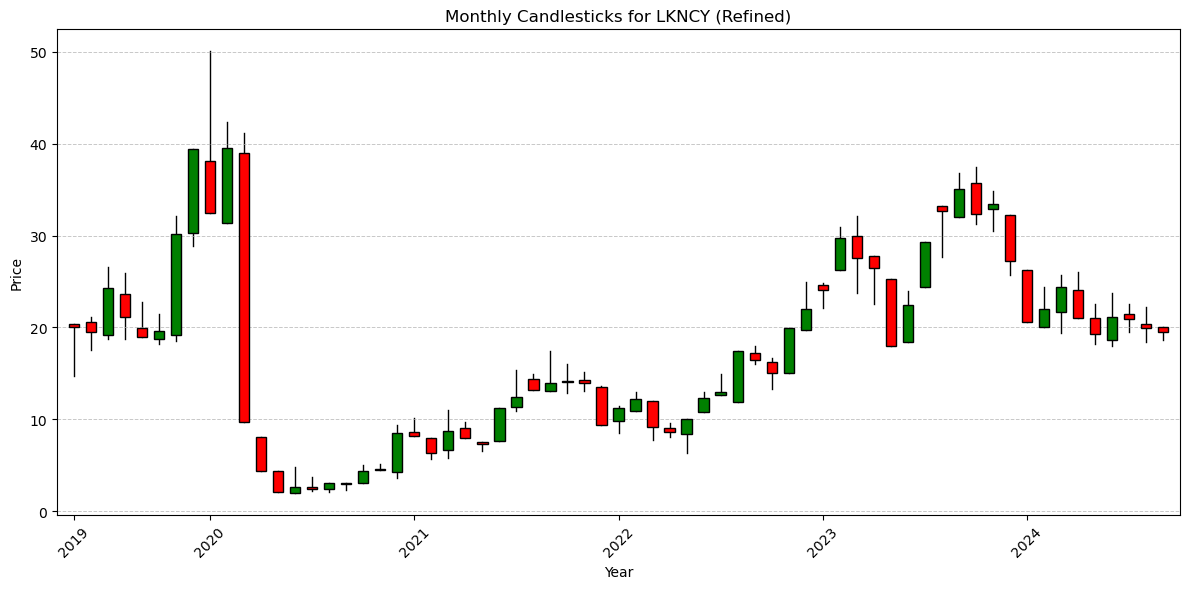

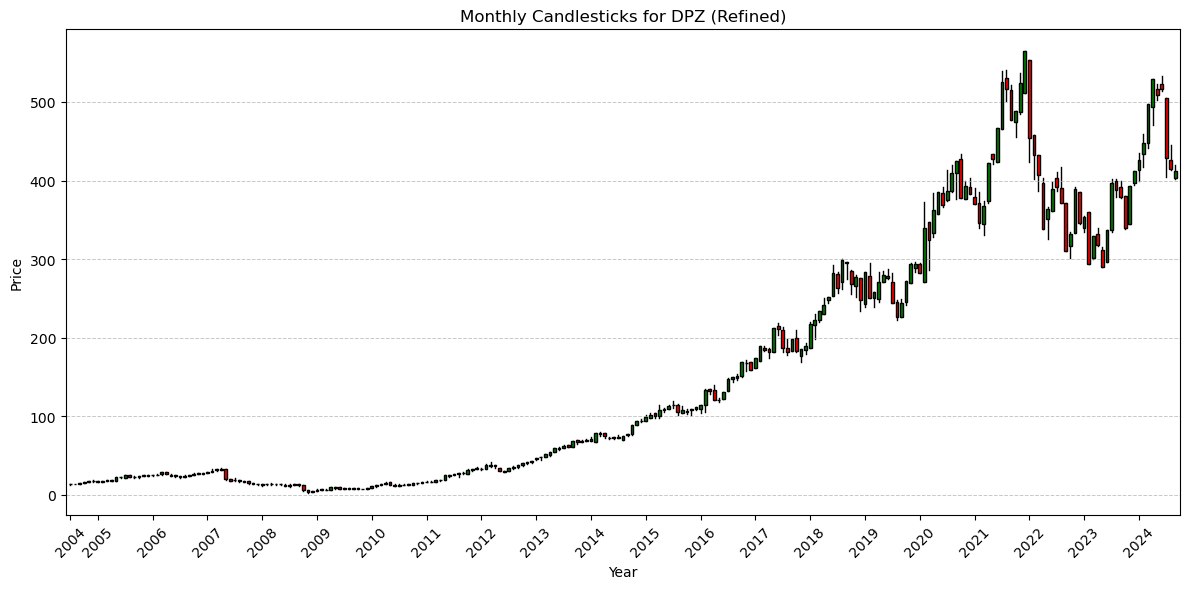

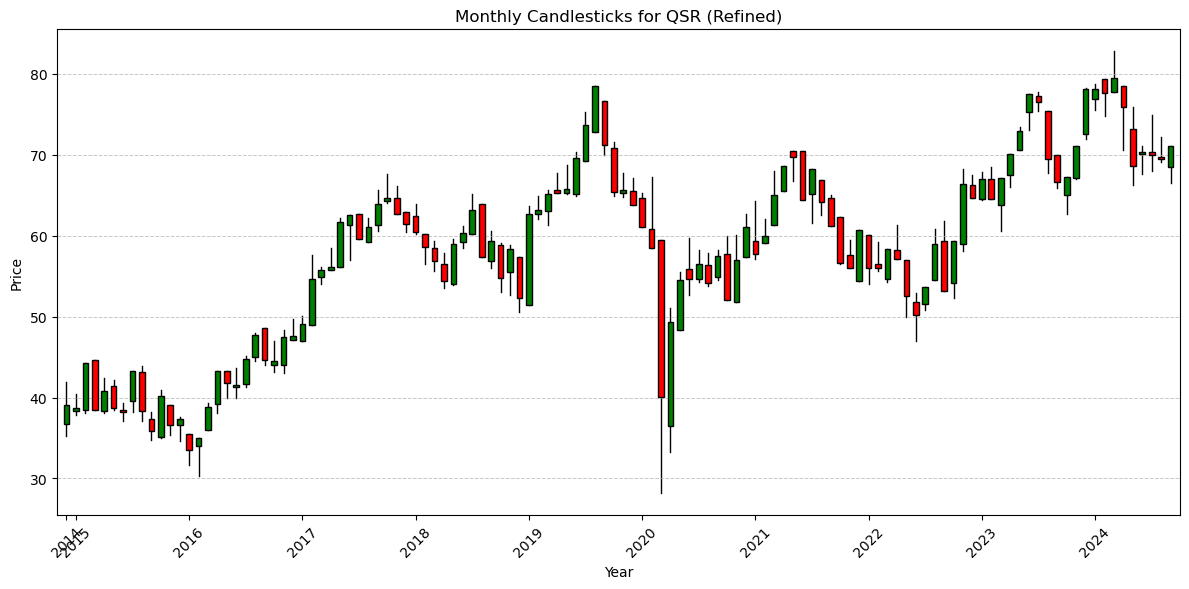

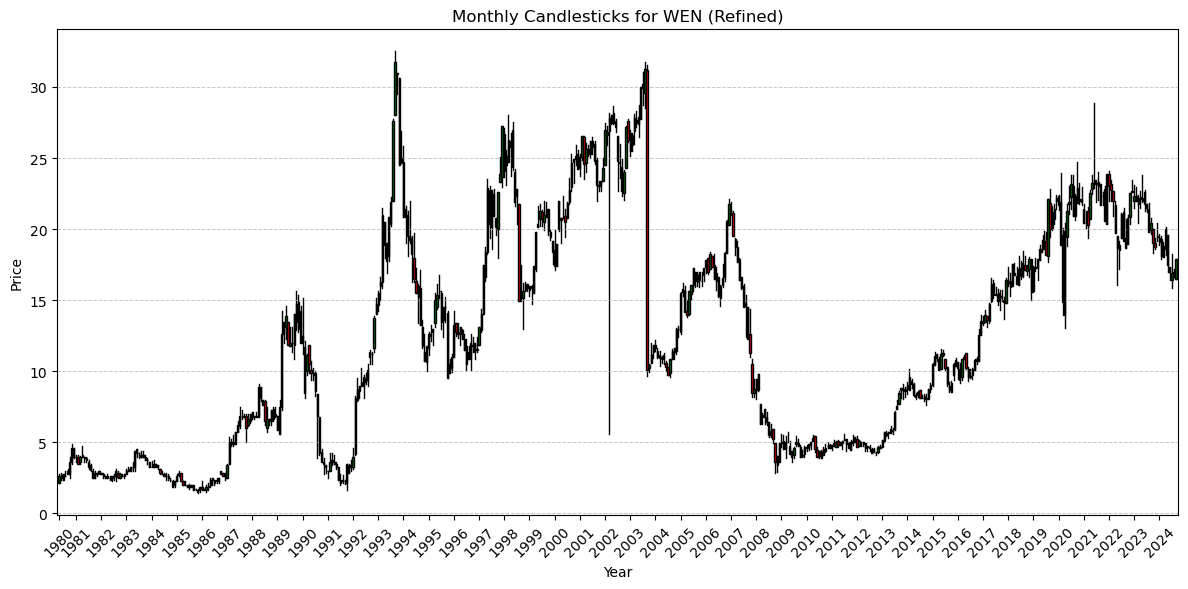

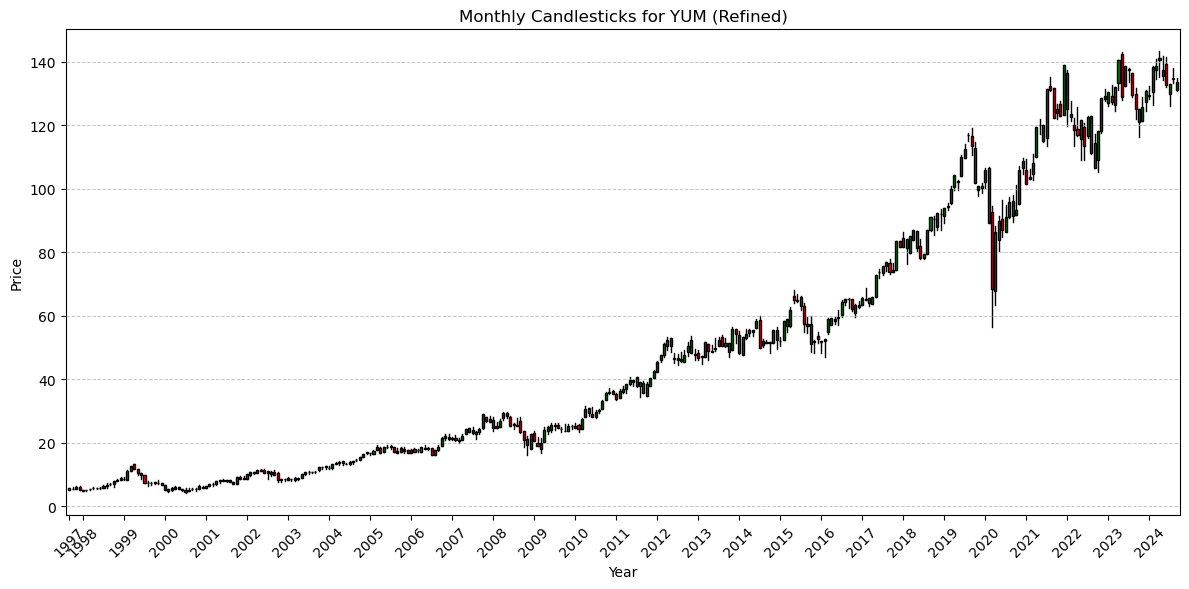

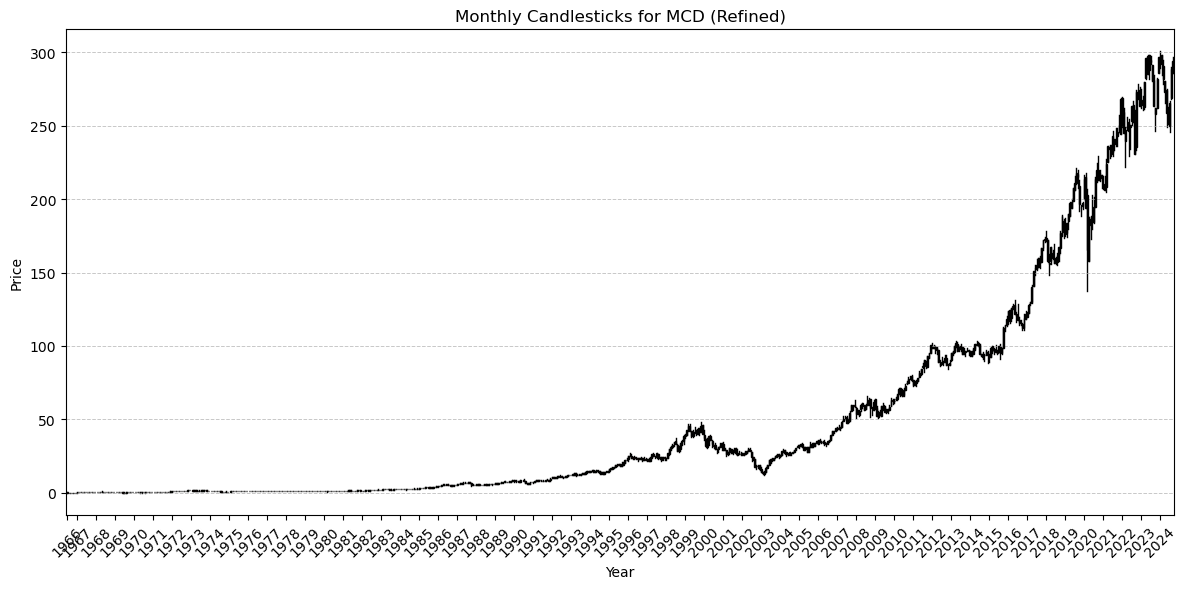

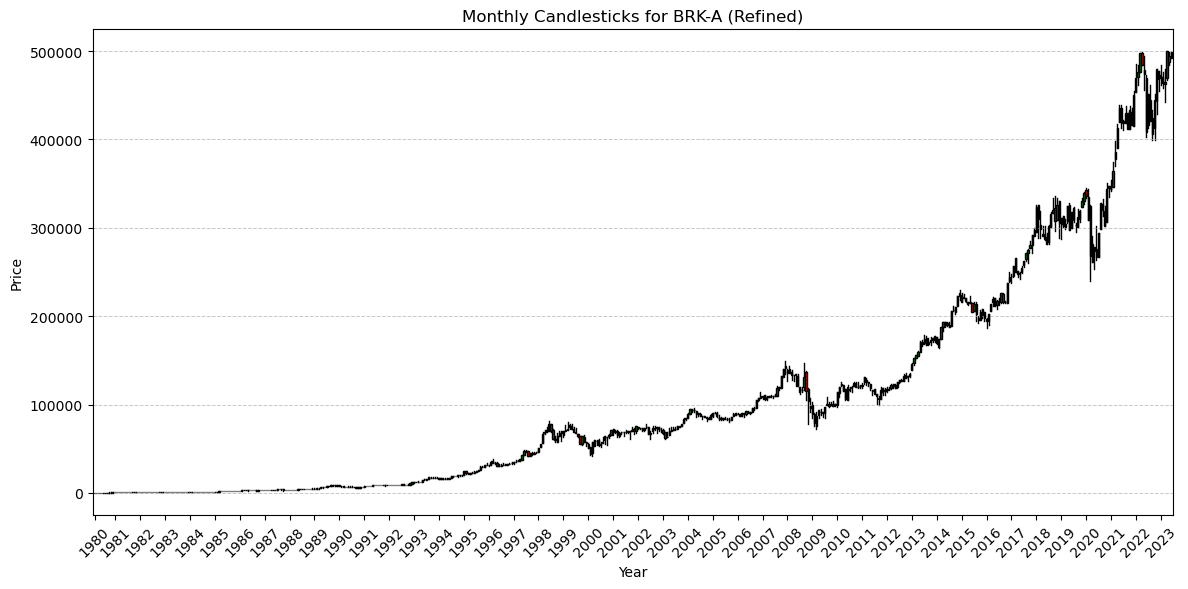

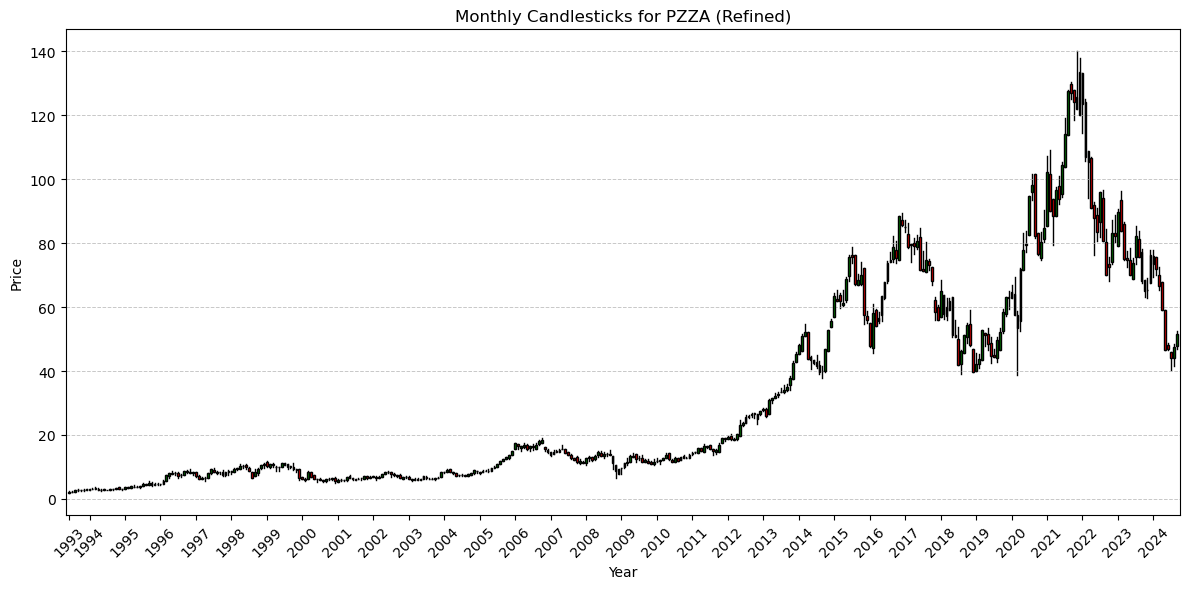

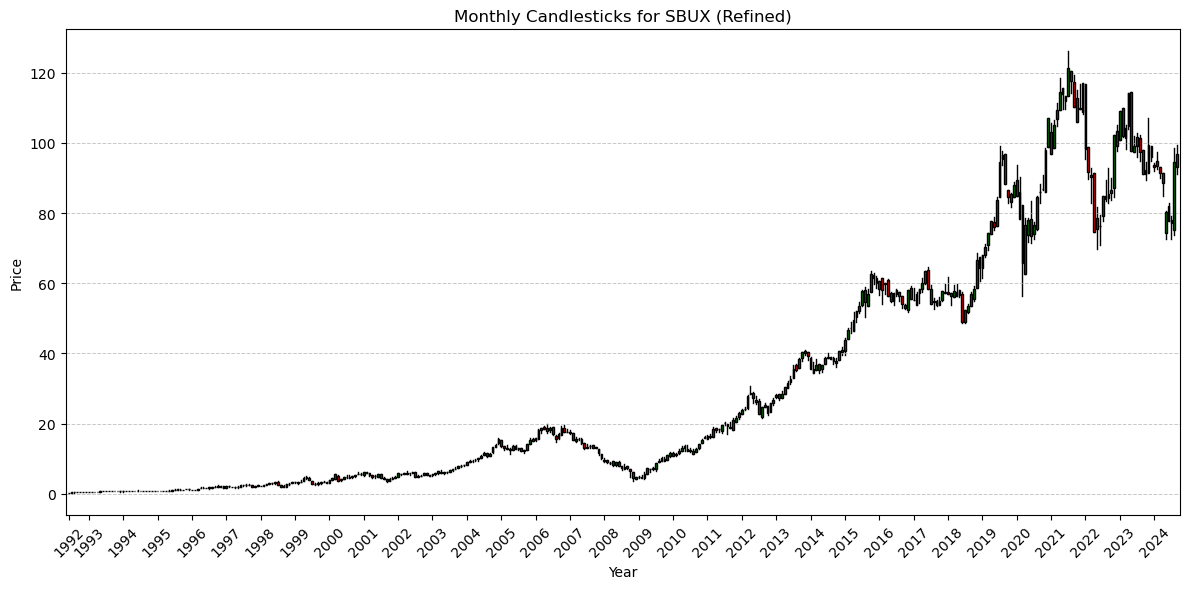

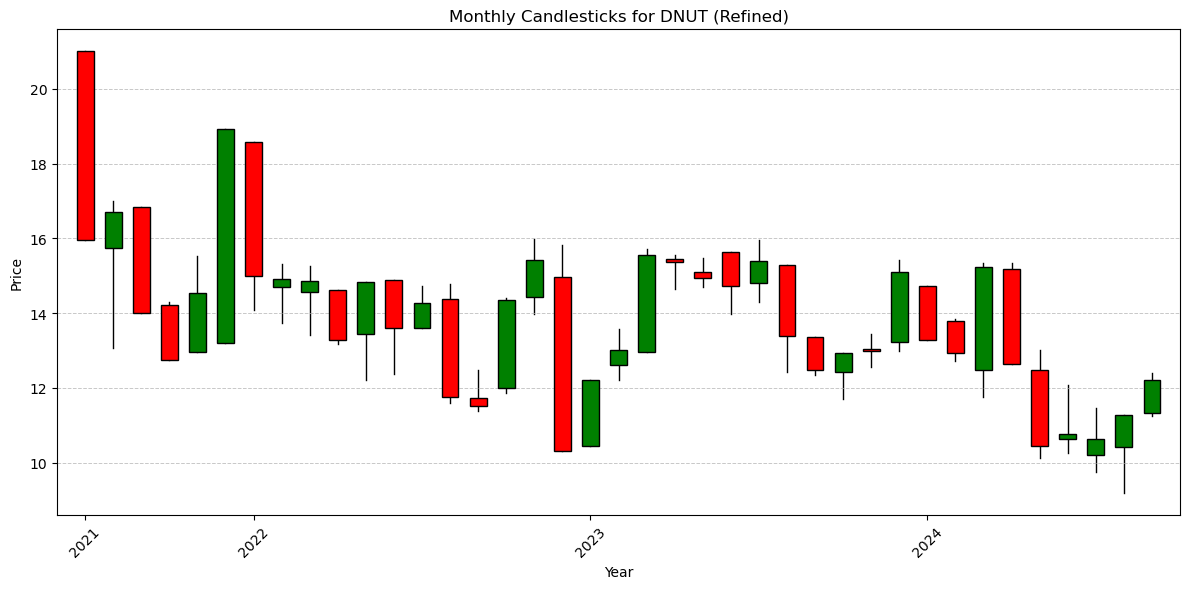

In [87]:


# Adjusting the candlestick charts to show only the year on the x-axis and refine BRK-A visualization
def plot_candlesticks_refined(data, company_name, threshold):
    # Convert Date to datetime and extract year-month for grouping
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year  # Extract year for simpler x-axis labels
    data['YearMonth'] = data['Date'].dt.to_period('M')
    
    # Remove data points above the threshold
    data = data[data['Close'] <= threshold]
    
    if data.empty:
        print(f"No data to plot for {company_name} after filtering.")
        return
    
    # Group by year-month and calculate open, close, high, and low prices
    monthly_data = data.groupby('YearMonth').agg(
        Open=('Close', 'first'),
        Close=('Close', 'last'),
        High=('Close', 'max'),
        Low=('Close', 'min'),
        Year=('Year', 'first')  # Keep year for x-axis labeling
    ).reset_index()
    
    # Determine colors based on monthly performance
    monthly_data['Color'] = ['green' if close > open_ else 'red' 
                             for open_, close in zip(monthly_data['Open'], monthly_data['Close'])]
    
    # Plot candlesticks
    plt.figure(figsize=(12, 6))
    for i, row in monthly_data.iterrows():
        # Plot wick (high-low) in black
        plt.plot([i, i], [row['Low'], row['High']], color='black', linewidth=1, zorder=1)
        # Plot candle body (open-close) in green/red
        plt.gca().add_patch(plt.Rectangle((i - 0.3, min(row['Open'], row['Close'])),
                                          0.6, abs(row['Close'] - row['Open']),
                                          color=row['Color'], ec='black', zorder=2))
    
    # Formatting the plot
    plt.title(f"Monthly Candlesticks for {company_name} (Refined)")
    plt.xlabel("Year")
    plt.ylabel("Price")
    
    # Simplify x-axis to show only years
    years = monthly_data['Year'].unique()
    year_positions = [monthly_data[monthly_data['Year'] == year].index[0] for year in years]
    plt.xticks(ticks=year_positions, labels=years, rotation=45)
    
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.xlim(-1, len(monthly_data))  # Add some spacing for visual appeal
    plt.tight_layout()
    plt.show()

# Generate the refined candlestick charts
outlier_thresholds = {
    "BRK-A": 500000  # Add thresholds for outliers if necessary
}

for df in dataframes:
    company_name = df['Company'].iloc[0]
    
    # Apply special handling for thresholds or BRK-A
    threshold = outlier_thresholds.get(company_name, float('inf'))  # Default to no threshold
    plot_candlesticks_refined(df, company_name, threshold)


### Why Candlesticks? 

We chose **candlestick charts** as our chart selection because they provide the most comprehensive visualization of monthly trading data, offering insights that go beyond simple averages or trends. A candlestick chart conveys multiple layers of information in a single visualization, making it particularly effective for analyzing stock performance over time.

The **color of the candle** immediately indicates whether a stock increased or decreased in value during the month. Specifically, a green candle shows that the stock's value increased (the closing price was higher than the opening price), while a red candle signifies a decrease in value (the closing price was lower than the opening price). This visual distinction allows users to quickly identify positive or negative trends without needing to analyze numerical data.

The **body of the candle** represents the difference between the opening and closing prices for the month. A tall body indicates significant price movement, suggesting a month of strong activity, while a short body reflects relatively stable performance. This feature highlights the degree of change in stock value within a given month.

The **wicks** (also known as shadows) of the candlestick add further detail by showing the stock's high and low prices during the month. The top wick represents the highest price reached, while the bottom wick shows the lowest price. These elements provide critical insights into the volatility of the stock, revealing how much its price fluctuated over the month.



### 7. Create a plot showing the relationship between trading volume and the `Close` price for a selected company.
- Add insights about the pattern and justify your chart selection.

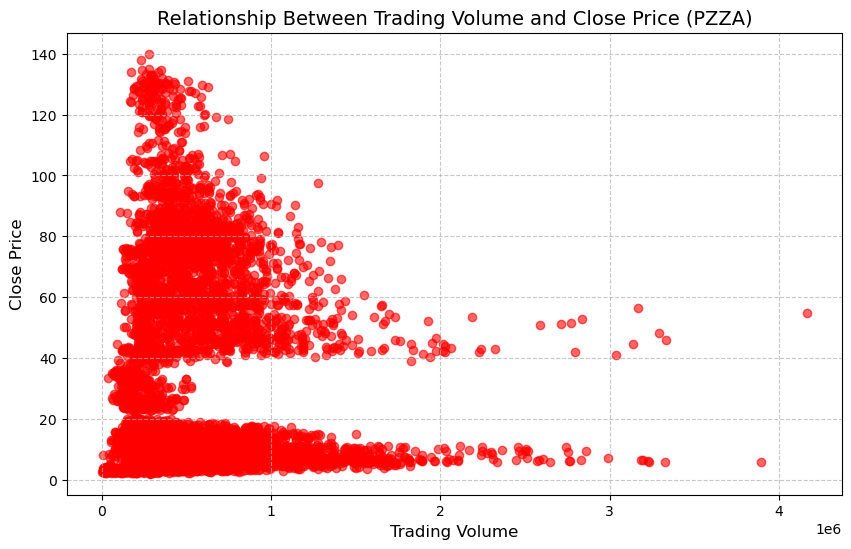

In [88]:
# Find the DataFrame for the company "PZZA"
pzza_data = [df for df in dataframes if df['Company'].iloc[0] == 'PZZA'][0]  # Filter by company name

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pzza_data['Volume'], pzza_data['Close'], alpha=0.6, color='red')
plt.title('Relationship Between Trading Volume and Close Price (PZZA)', fontsize=14)
plt.xlabel('Trading Volume', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Insights about the pattern :- 

1. **Relationship Observation:**

    - The scatter plot reveals a non linear pattern and most data points are clustered at lower trading values (close to 0) and lower Close Prices (under 100), indicating that low trading activity is common for PZZA. 

2. **Distinct Clusters:**

    - There are horizontal clusters in the data such as around Close Prices of 20, 60 and 100, suggesting that these prices levels may be recurring or significant for the company. 

3. **Spare High Volume Activity:**

    - Trading volumes exceeding 2.5 million are rare and such instances occur accross a broad range of Close Prices. 


#### Justification for Chart Selection:

1. **Shows Relationships Carefully:**

    -  A scatter plot is the best choice for visualizing the relationship between two continuous variables—Trading Volume and Close Price—allowing us to observe patterns, clusters, and outliers effectively.
    
2.  **Highlights Trends and Anomalies:** 

    - It enables easy identification of trends and outliers which are critical for analysis.

3.  **Avoids Misrepresentation:**

    -  Other charts, like bar or line plots, would not work well since the data does not follow a time sequence or a category-based structure. 



### 8. For each company, identify the month with the highest total trading volume.
- Display the results in a summary table, showing the month and total volume.

In [103]:
# Dictionary to store results
results = {"Company": [], "Month-Year": [], "Total Volume": []}

for df in dataframes:
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract the company name
    company_name = df["Company"].iloc[0]
    
    # Extract 'Year' and 'Month' from the 'Date' column
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    
    # Group by 'Year' and 'Month' and calculate total volume
    monthly_volume = df.groupby(['Year', 'Month'])['Volume'].sum()
    
    # Find the (Year, Month) with the highest trading volume
    max_volume_period = monthly_volume.idxmax()  # Tuple (Year, Month)
    max_volume = monthly_volume[max_volume_period]
    
    # Convert (Year, Month) to a readable format
    max_volume_year_month = pd.to_datetime(f"{max_volume_period[0]}-{max_volume_period[1]}", format='%Y-%m').strftime('%B %Y')
    
    # Append to results dictionary
    results["Company"].append(company_name)
    results["Month-Year"].append(max_volume_year_month)
    results["Total Volume"].append(f"{round(max_volume / 1e6, 2)}M")  # Convert to millions and append 'M'

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))


Company   Month-Year Total Volume
  LKNCY January 2020      315.51M
    DPZ  August 2011       27.29M
    QSR   March 2020      110.31M
    WEN    June 2009        5.09M
    YUM January 2008      170.39M
    MCD October 2008      319.16M
  BRK-A   April 2024       31.27M
   PZZA  August 2018       40.22M
   SBUX January 2008      790.03M
   DNUT     May 2024       52.34M


### 9. Merge the datasets for all companies into a single dataset, one for each year.
- Print the structure of the combined dataset.
- Ensure proper alignment and handling of missing values.

In [90]:
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df

Date   Open   High     Low  Close  Adj Close     Volume Company  \
0     2019-05-17  21.02  21.02  18.810  20.38      20.38  8186600.0   LKNCY   
1     2019-05-20  21.02  21.02  18.400  18.61      18.61  8186600.0   LKNCY   
2     2019-05-21  18.59  18.74  17.330  17.33      17.33  8186600.0   LKNCY   
3     2019-05-22  17.00  17.33  14.700  14.75      14.75  8186600.0   LKNCY   
4     2019-05-23  14.47  15.95  14.735  15.79      15.79  8186600.0   LKNCY   
...          ...    ...    ...     ...    ...        ...        ...     ...   
69589 2024-09-13  11.64  11.93  11.570  11.75      11.75  1249600.0    DNUT   
69590 2024-09-16  11.77  12.31  11.730  12.19      12.19  1481600.0    DNUT   
69591 2024-09-17  12.29  12.53  12.250  12.40      12.40  1350800.0    DNUT   
69592 2024-09-18  12.29  12.49  12.080  12.20      12.20  1080400.0    DNUT   
69593 2024-09-19  12.45  12.46  12.150  12.22      12.22  1320250.0    DNUT   

      YearMonth  Year  Month  
0       2019-05  2019      5  
1       2019-05  2019      5  
2       2019-05  2019      5  
3       2019-05  2019      5  
4       2019-05  2019      5  
...         ...   ...    ...  
69589   2024-09  2024      9  
69590   2024-09  2024      9  
69591   2024-09  2024      9  
69592   2024-09  2024      9  
69593   2024-09  2024      9  

[69594 rows x 11 columns]

In [91]:
first_year = merged_df['Date'].dt.year.min()  # Get the first year in the dataset
recent_year = merged_df['Date'].dt.year.max()
merged_df['Year'] = merged_df['Date'].dt.year # Add year column

# Create a dictionary to hold the dataframes for each year
year_dfs = {}

# Loop through each year and create a dataframe for that year
for year in range(first_year, recent_year + 1):
    year_dfs[year] = merged_df[merged_df['Year'] == year].copy()


We can access each years specific dataset by calling the year dictionary with the desired year as the key. Here is an example for year 2024:

In [92]:
year_dfs[2024]

Date   Open    High    Low  Close  Adj Close     Volume Company  \
1169  2024-01-02  26.75  26.830  26.02  26.25      26.25  2098200.0   LKNCY   
1170  2024-01-03  26.11  26.645  24.65  25.42      25.42  4725100.0   LKNCY   
1171  2024-01-04  25.43  26.460  24.93  26.15      26.15  3175700.0   LKNCY   
1172  2024-01-05  26.15  26.670  25.00  25.20      25.20  2706000.0   LKNCY   
1173  2024-01-08  25.16  25.310  23.68  24.50      24.50  2216400.0   LKNCY   
...          ...    ...     ...    ...    ...        ...        ...     ...   
69589 2024-09-13  11.64  11.930  11.57  11.75      11.75  1249600.0    DNUT   
69590 2024-09-16  11.77  12.310  11.73  12.19      12.19  1481600.0    DNUT   
69591 2024-09-17  12.29  12.530  12.25  12.40      12.40  1350800.0    DNUT   
69592 2024-09-18  12.29  12.490  12.08  12.20      12.20  1080400.0    DNUT   
69593 2024-09-19  12.45  12.460  12.15  12.22      12.22  1320250.0    DNUT   

      YearMonth  Year  Month  
1169    2024-01  2024      1  
1170    2024-01  2024      1  
1171    2024-01  2024      1  
1172    2024-01  2024      1  
1173    2024-01  2024      1  
...         ...   ...    ...  
69589   2024-09  2024      9  
69590   2024-09  2024      9  
69591   2024-09  2024      9  
69592   2024-09  2024      9  
69593   2024-09  2024      9  

[1812 rows x 11 columns]

Here is an example of the stucture of these yearly datasets. You can see there are only missing values for the volume which is discussed above.

In [93]:
year_dfs[2024].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1812 entries, 1169 to 69593
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1812 non-null   datetime64[ns]
 1   Open       1812 non-null   float64       
 2   High       1812 non-null   float64       
 3   Low        1812 non-null   float64       
 4   Close      1812 non-null   float64       
 5   Adj Close  1812 non-null   float64       
 6   Volume     1812 non-null   float64       
 7   Company    1812 non-null   object        
 8   YearMonth  1812 non-null   period[M]     
 9   Year       1812 non-null   int32         
 10  Month      1812 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(2), object(1), period[M](1)
memory usage: 155.7+ KB


Here is a visualization of what is now avaliable through these yearly datasets. The variable `High` is charted for each company in 2024 below excluding BRK-A for better visualization.

/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_40939/845033574.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Log_High'] = np.log(df_filtered['High'])


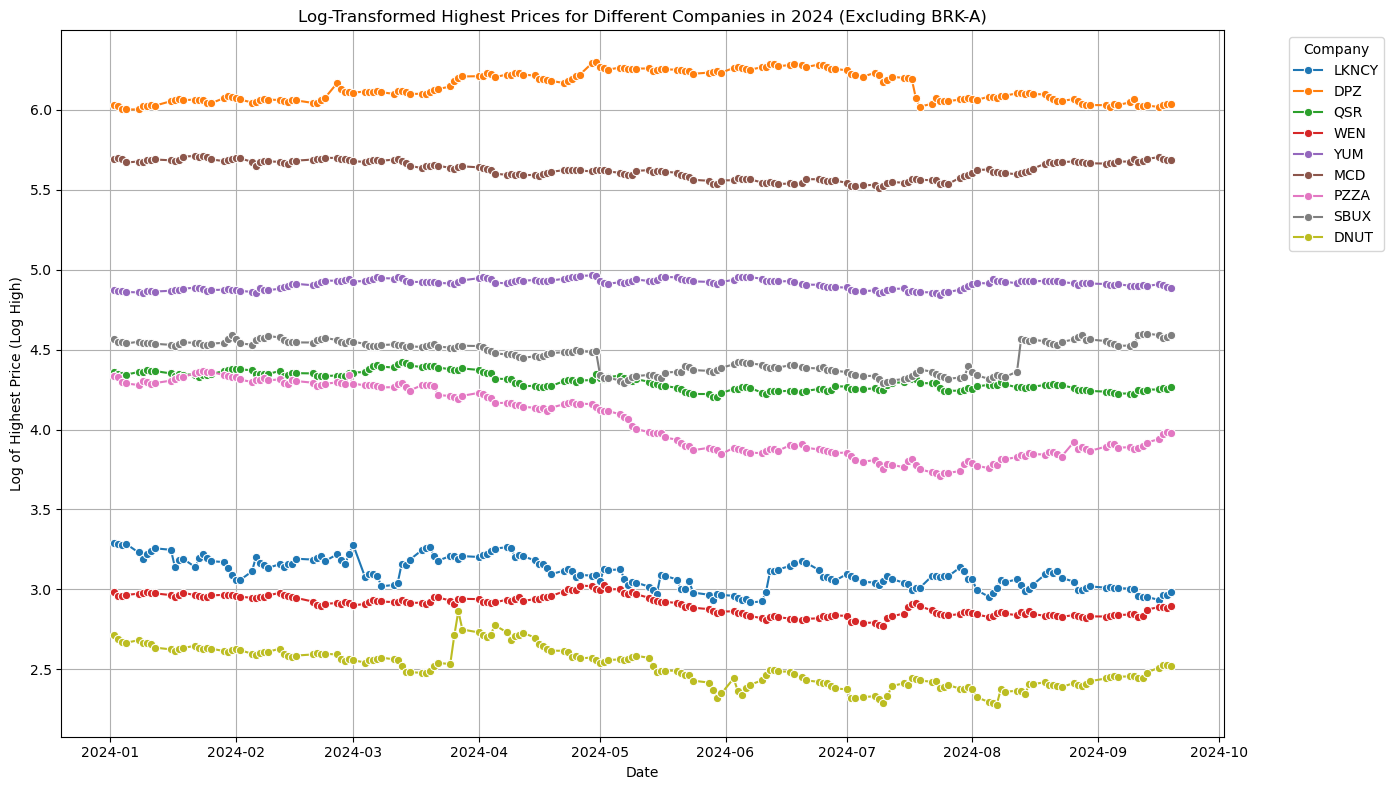

In [94]:
import seaborn as sns

# Extract the DataFrame for 2024
df_2024 = year_dfs[2024]

# Ensure 'Date' is in datetime format
df_2024['Date'] = pd.to_datetime(df_2024['Date'])

# Find the company with the highest average 'High' value
top_company = df_2024.groupby('Company')['High'].mean().idxmax()

# Filter out the top company
df_filtered = df_2024[df_2024['Company'] != top_company]

# Apply log transformation to the 'High' values
df_filtered.loc[:, 'Log_High'] = np.log(df_filtered['High'])

# Create the Seaborn lineplot with the log-transformed 'High' values
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_filtered, x='Date', y='Log_High', hue='Company', marker='o')

# Customize the plot
plt.title(f'Log-Transformed Highest Prices for Different Companies in 2024 (Excluding {top_company})')
plt.xlabel('Date')
plt.ylabel('Log of Highest Price (Log High)')

plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside the plot
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()



### 10. For each company:
- Calculate the spread between the `High` and `Low` prices for each day.
- Calculate the average spread for each company and visualize the result in a chart.
- Justify the chart selection.
- Identify which companies exhibit the largest spreads and provide insights into their values.


In [95]:
average_spreads = {}

for df in dataframes:
    df['Spread'] = df['High'] - df['Low']
    # Calculate the average spread for the current dataframe
    avg_spread = df['Spread'].mean()
    average_spreads[df['Company'].iloc[0]] = avg_spread
    
    print(f"{df['Company'].iloc[0]} average daily spread between High and Low prices is: {avg_spread:.2f}")
    print("=============================================\n")

# The dictionary `average_spreads` now contains the average spread for each company
print("Average spreads for all companies:")
print(average_spreads)

LKNCY average daily spread between High and Low prices is: 1.03

DPZ average daily spread between High and Low prices is: 3.74

QSR average daily spread between High and Low prices is: 1.21

WEN average daily spread between High and Low prices is: 0.35

YUM average daily spread between High and Low prices is: 0.90

MCD average daily spread between High and Low prices is: 0.82

BRK-A average daily spread between High and Low prices is: 1730.36

PZZA average daily spread between High and Low prices is: 0.93

SBUX average daily spread between High and Low prices is: 0.62

DNUT average daily spread between High and Low prices is: 0.54

Average spreads for all companies:
{'LKNCY': 1.0302925925925925, 'DPZ': 3.737757468553459, 'QSR': 1.2071492476616512, 'WEN': 0.3523199606862044, 'YUM': 0.8994206734303779, 'MCD': 0.8165173637169953, 'BRK-A': 1730.3610492562573, 'PZZA': 0.9296422681720157, 'SBUX': 0.615880940655011, 'DNUT': 0.5405950920245399}


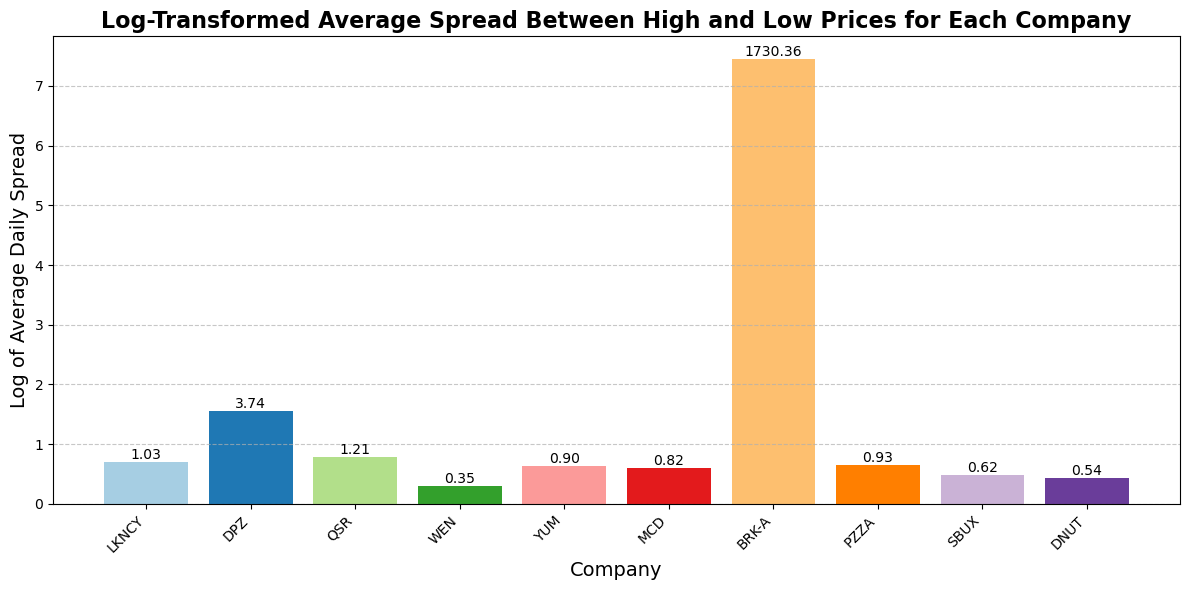

In [96]:
companies = list(average_spreads.keys())
spreads = list(average_spreads.values())

# Apply log transformation to the spreads, adding a small constant to avoid log(0) errors
log_spreads = np.log(np.array(spreads) + 1)

# Set up Seaborn color palette and figure size
colors = sns.color_palette("Paired", len(companies))  # Use a different palette
plt.figure(figsize=(12, 6))  # Wider figure for better spacing

# Create a bar chart with different colors for each bar
bars = plt.bar(companies, log_spreads, color=colors)

# Add titles and labels
plt.title('Log-Transformed Average Spread Between High and Low Prices for Each Company', fontsize=16, fontweight='bold')
plt.xlabel('Company', fontsize=14)
plt.ylabel('Log of Average Daily Spread', fontsize=14)

# Annotate the actual spread value (not log-transformed) on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    actual_value = spreads[i]
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{actual_value:.2f}', ha='center', va='bottom', fontsize=10)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Optionally add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [97]:
import pandas as pd

# Assuming 'dataframes' is a list of your 10 dataframes for each company
volatility = []
average_volume = []
companies = [df['Company'].iloc[0] for df in dataframes]

# Calculate volatility and average volume for each company
for df in dataframes:
    # Calculate daily returns
    df['Daily Return'] = df['Close'].pct_change()

    # Add Volatility (30-day rolling window)
    df['Volatility'] = df['Daily Return'].rolling(window=30).std()

    # Add Average Volume (30-day rolling window, ignoring NaN values)
    df['Average Volume'] = df['Volume'].rolling(window=30, min_periods=1).mean()

    # Store the average volatility and average volume for each company
    volatility.append(df['Volatility'].mean())
    average_volume.append(df['Average Volume'].mean())

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Company': companies,
    'Average Volatility': volatility,
    'Average Volume': average_volume
})

# Display the summary
summary_df


Company  Average Volatility  Average Volume
0   LKNCY            0.054042    2.889685e+06
1     DPZ            0.019901    5.562360e+05
2     QSR            0.015868    1.378860e+06
3     WEN            0.027345    5.729684e+04
4     YUM            0.016398    3.505338e+06
5     MCD            0.016181    3.879979e+06
6   BRK-A            0.012365    6.275457e+04
7    PZZA            0.021972    5.571917e+05
8    SBUX            0.021056    1.275786e+07
9    DNUT            0.026776    1.064506e+06

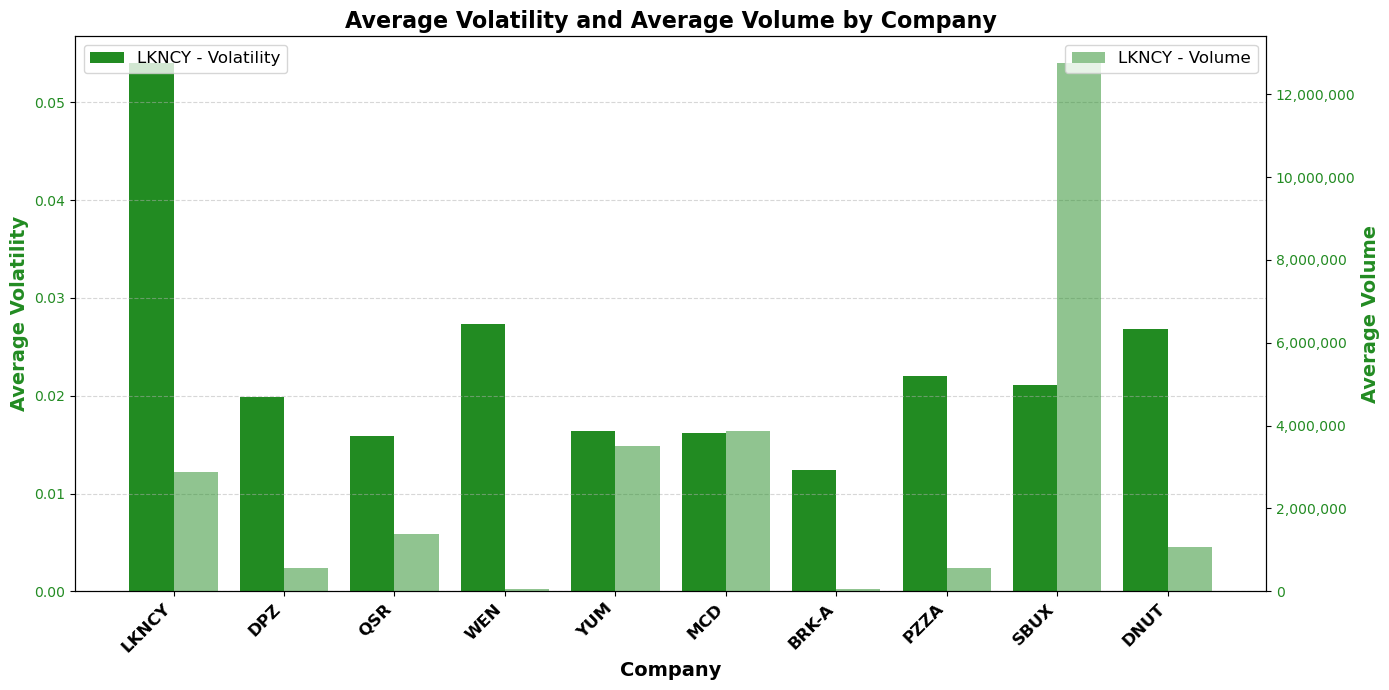

In [98]:
from matplotlib.ticker import MaxNLocator

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Set the x positions for each company
x = np.arange(len(summary_df))

# Use a normal green color for both volatility and volume
common_color = '#228B22'  # Forest Green

# Plot Average Volatility with higher opacity
for i, company in enumerate(summary_df['Company']):
    ax1.bar(x[i] - 0.2, summary_df['Average Volatility'][i], width=0.4, color=common_color, alpha=1, label=f'{company} - Volatility' if i == 0 else "")

# Create another axis for Average Volume with lower opacity
ax2 = ax1.twinx()
for i, company in enumerate(summary_df['Company']):
    ax2.bar(x[i] + 0.2, summary_df['Average Volume'][i], width=0.4, color=common_color, alpha=0.5, label=f'{company} - Volume' if i == 0 else "")

# Set the labels and title with larger font sizes
ax1.set_xlabel('Company', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Volatility', color=common_color, fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Volume', color=common_color, fontsize=14, fontweight='bold')
ax1.set_title('Average Volatility and Average Volume by Company', fontsize=16, fontweight='bold')

# Set the company names on the x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(summary_df['Company'], rotation=45, ha='right', fontsize=12, fontweight='bold')

# Match the tick label colors with their respective axis label
ax1.tick_params(axis='y', labelcolor=common_color)
ax2.tick_params(axis='y', labelcolor=common_color)

# Set the right y-axis to show numbers in normal format (not scientific notation)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Add legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Add grid lines with a lighter style
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Tight layout to make sure everything fits
plt.tight_layout()
plt.show()

